usingcpudevice
torch.Size([1, 1, 800])

 the MAE is 1.0000

 Total convolution layers:4
Conv_layers
torch.Size([32, 780])


C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1715839063.py:238: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_4.show()


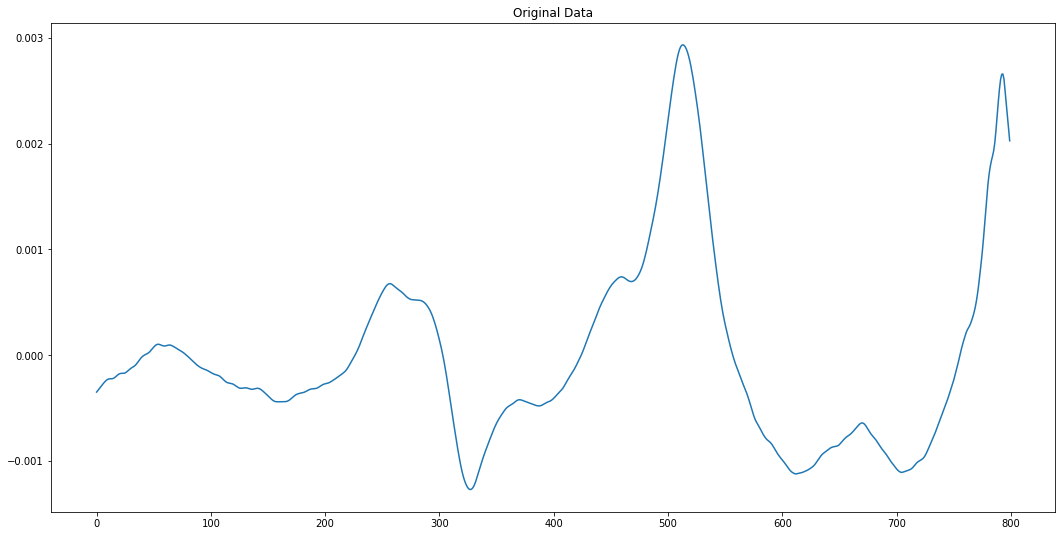

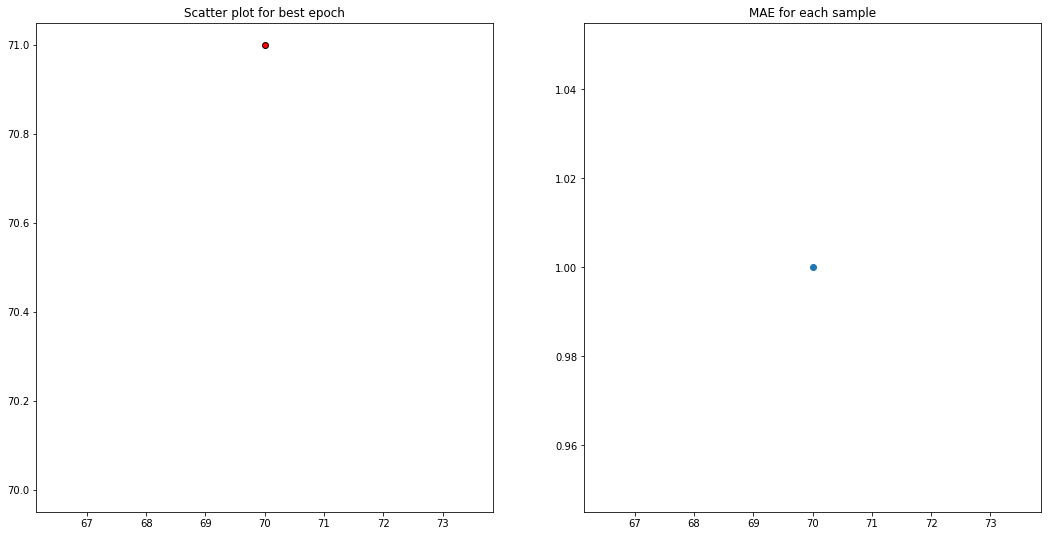

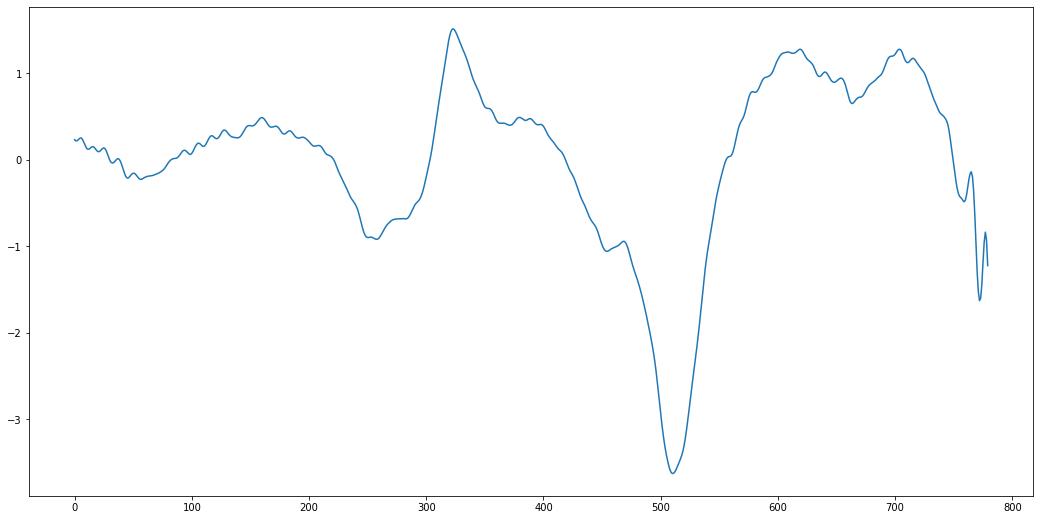

In [134]:
import numpy as np
import pandas as pd
import random
import torch
import sys
from torch import nn
from torch import optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from datetime import datetime
import matplotlib.pyplot as plt
import sklearn.metrics
#from google.colab import files
import io
from scipy import signal as sg
from scipy.signal import savgol_filter
from torch.autograd import Function
from scipy.stats import chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from scipy.ndimage import convolve1d
from scipy.signal.windows import triang
from scipy.ndimage import gaussian_filter1d
import torch.nn.functional as F
import sys

# pynvml import *

b_size = 32 #batch size
np.random.seed(100)

# the 1DCNN model on Asta for regression with added ANN layer and 0.00001 learning rate and with SNV preprocessing with Huberloss and adam optimizer with changed window length =11, polyorder = 2
class D1CNN(nn.Module):
    def __init__(self):
        super(D1CNN,self).__init__()
        self.features = nn.Sequential()
        self.features.add_module('1_conv1d',nn.Conv1d(in_channels=1,out_channels=32,kernel_size=21))
        self.features.add_module('1_relu',nn.ReLU())            
        self.features.add_module('1_batchnorm',nn.BatchNorm1d(32))
        self.features.add_module('1_maxpool',nn.MaxPool1d(kernel_size=2))
    
        self.features.add_module('2_conv1d',nn.Conv1d(in_channels=32,out_channels=64,kernel_size=21))
        self.features.add_module('2_relu',nn.ReLU())
        self.features.add_module('2_batchnorm',nn.BatchNorm1d(64))
        self.features.add_module('2_maxpool',nn.MaxPool1d(kernel_size=3))

        self.features.add_module('3_conv1d',nn.Conv1d(in_channels=64,out_channels=128,kernel_size=21))
        self.features.add_module('3_relu',nn.ReLU())
        self.features.add_module('3_batchnorm',nn.BatchNorm1d(128))
        self.features.add_module('3_maxpool',nn.MaxPool1d(kernel_size=3))

        self.features.add_module('4_conv1d',nn.Conv1d(in_channels=128,out_channels=256,kernel_size=21))
        self.features.add_module('4_relu',nn.ReLU())
        self.features.add_module('4_batchnorm',nn.BatchNorm1d(256))
        self.features.add_module('4_maxpool',nn.MaxPool1d(kernel_size=3))
        
        self.features.add_module('drop_1',nn.Dropout(p=0.4))
    
        self.regress = nn.Sequential()
        self.regress.add_module('an_1',nn.Linear(1024,512))
        self.regress.add_module('an_Relu_1',nn.ReLU())
        self.regress.add_module('an_drop_1',nn.Dropout(p=0.2))
        self.regress.add_module('an_2',nn.Linear(512,512))
        self.regress.add_module('an_Relu_2',nn.ReLU())
        self.regress.add_module('an_drop_2',nn.Dropout(p=0.2))
        self.regress.add_module('an_3',nn.Linear(512,128))
        self.regress.add_module('an_Relu_3',nn.ReLU())
        self.regress.add_module('an_drop_3',nn.Dropout(p=0.2))
        self.regress.add_module('an_4',nn.Linear(128,128))
        self.regress.add_module('an_Relu_4',nn.ReLU())
        self.regress.add_module('an_drop_4',nn.Dropout(p=0.2))
        self.regress.add_module('an_5',nn.Linear(128,64))
        self.regress.add_module('an_Relu_5',nn.ReLU())
        self.regress.add_module('an_drop_5',nn.Dropout(p=0.2))
        self.regress.add_module('an_6',nn.Linear(64,1))

    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x,start_dim=1)
        x_out = self.regress(x)
        return x_out

# preprocessing functions
def moving_smoothing(input_array, window_length):

    m_rows = len(range(window_length, input_array.shape[1] - window_length))
    m_cols = 2*window_length
    matrix = np.zeros((m_rows,m_cols),dtype=int)
    for j in range(0, len(matrix)):
        k = j+1
        matrix[j] = [x for x in range(k,k+2*window_length)]
    #Smoothing spectra using matrix operations:
    n_cols = m_rows
    newspectra = np.zeros((len(input_array),n_cols))
    for i in range(len(matrix)):
        newspectra[:,i] = np.mean(input_array[: ,matrix[i]],axis=1)
    #Add front and end tails (not smoothed):
    #new_spectra = np.asarray(newspectra)
    fronttail = newspectra[:,:1]
    endtail = newspectra[:,-1:]
    for k in range(1,window_length):
        fronttail=np.append(fronttail,newspectra[:,:1], axis=1)
        endtail = np.append(endtail,newspectra[:,-1:], axis =1)
    data = np.concatenate((fronttail, newspectra, endtail), axis=1)
    return data

def derivate_first(input_array, window_length, polyorder):
    der1 = savgol_filter(input_array, window_length, polyorder,deriv = 1)
    return der1

def MSC(input_array, reference = None):
    ''' Perform Multiplicative scatter correction'''

    #Mean correction
    for i in range(input_array.shape[0]):
        input_array[i,:] -= input_array[i,:].mean()

    # Get the reference spectrum. If not given, estimate from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_array, axis=0)
    else:
        ref = reference

    # Define a new data matrix and populate it with the corrected data    
    output_data = np.zeros_like(input_array)
    for i in range(input_array.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_array[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_array[i,:] - fit[0][1]) / fit[0][0] 
    #print(fit)
    return output_data

def detrending(input_array):
    X = np.arange(input_array.shape[1])
    base = np.zeros((len(input_array),len(X)))
    for i in range(len(input_array)):
        c = np.polyfit(X, input_array[i], 2)
        base[i] = np.polyval(c, X)
    #Baseline removal
    base_remove = input_array - base
    return base_remove

def savitzky(input_array, window_length, polyorder):
    savgol = savgol_filter(input_array, window_length, polyorder)
    return savgol

def weighted_l1_loss(inputs, targets, weights=None):
    '''You need to correct this'''
    loss = F.l1_loss(inputs, targets, reduction='none')
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

def data_1D(f):
    sed = 100
    d_asta = pd.read_csv(f,encoding='utf-8')
    d_asta = d_asta.loc[:, ~d_asta.columns.str.contains('^Unnamed')]
    #col = [str(x) for x in range(0,151)]+[str(x) for x in range(751,801)]+['Sample ID','Cap']
    #col = ['Sample ID','Cap','800']
    #d_asta = df.drop(columns=col)
    #d_asta = d_asta.dropna(subset=['ASTA'])
    #d_asta['ASTA'] = d_asta['ASTA'].round()
    #d_asta = d_asta[d_asta['ASTA']>=50]
    #d_asta = d_asta[d_asta['ASTA']<120]

    X_val = np.array(d_asta.drop(columns = ['ASTA']))
    Y_val = np.array(d_asta['ASTA'])

    X_val = savitzky(X_val,11,2)
    X_val = MSC(X_val)
    X_val = detrending(X_val)
    X_val = derivate_first(X_val,11,2)


    return X_val[30],Y_val[30]

def run():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print('using'+device+'device')
    man_seed = 100
    torch.manual_seed(man_seed)
    model = D1CNN()
    model.load_state_dict(torch.load('model_asta_40_120_lds_dataaug_5_20220309_182454_659.pth',map_location = torch.device(device)))
    model.to(device)
    '''if float 64 is allowed then you can go with that too'''
    model.to(torch.float32)
    loss = weighted_l1_loss
    file_name = 'test_chili_asta.csv'
    x_val,y_val = data_1D(file_name)
    fig_1 = plt.figure(figsize =(18,9))
    ax = fig_1.add_subplot(1,1,1)
    ax.plot(x_val.transpose())
    ax.title.set_text('Original Data')
    model.eval()
    
    with torch.no_grad():

        v_x_dt = torch.from_numpy(x_val)
        v_x_dt = torch.unsqueeze(v_x_dt,dim=0)
        v_x_dt = torch.unsqueeze(v_x_dt,dim=0)
        
        v_x_dt = Variable(v_x_dt,requires_grad=False).to(device,dtype = torch.float32)
        print(v_x_dt.shape)
        v_y_dt = torch.from_numpy(np.array(y_val))
        v_y_dt = Variable(v_y_dt,requires_grad = False).to(device,dtype = torch.float32)
        v_yhat = model.forward(v_x_dt)
        v_yhat = torch.squeeze(v_yhat)
        v_yhat = torch.round(v_yhat)
        v_loss = loss(v_yhat,v_y_dt).item()

        b_yhat = v_yhat.to('cpu')
        b_y_t_1 = v_y_dt.to('cpu')
        #r2_score = sklearn.metrics.r2_score(b_y_t_1,b_yhat)
        
    
        v_x_dt.detach()
        v_y_dt.detach()
        v_yhat.detach()
        
    print("\n the MAE is %.4f\n"%(v_loss)),#r2_score))
    
    ttt = abs(b_yhat - b_y_t_1)
    
    
    fig_4 = plt.figure(figsize =(18,9))
    ax4 = fig_4.add_subplot(1,2,1)
    ax5 = fig_4.add_subplot(1,2,2)
    ax4.title.set_text('Scatter plot for best epoch')
    ax5.title.set_text('MAE for each sample')
    ax5.plot(b_y_t_1,ttt,marker ='o',linestyle='')
    ax4.scatter(b_y_t_1,b_yhat,c='red',edgecolors='k')
    ax4.plot(b_y_t_1,b_y_t_1,c='blue',linewidth = 1)
    fig_4.show()
    
    model_weights =[]
    conv_layers = []

    model_children = list(model.children())
    counter = 0

    #print(model_children)

    for i in range(len(model_children)):        

        if type(model_children[i])==nn.Sequential:
            for child in model_children[i].children():
                if type(child) == nn.Conv1d:
                    counter +=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
    
    print(f" Total convolution layers:{counter}")
    print("Conv_layers")
    
    test_x = v_x_dt
    outputs =[]
    names = []
    for layer in conv_layers[0:]:
        test_x = layer(test_x)
        outputs.append(test_x)
        names.append(str(layer))
    
    for feature_map in outputs:
        feature_map = feature_map.squeeze(0)
        print(feature_map.shape)
        fig = plt.figure(figsize=(18,9))
        for i in range(feature_map.shape[0]):
            ss = feature_map[i].data.cpu().numpy()
            ss -= ss.mean()
            ss /= ss.std()
            plt.plot(ss.transpose())
            break
        break
        
    #print(np.array(outputs).shape)

    """prcess= []
    for feature_map in outputs:
        feature_map = feature_map.squeeze(0)
        
        
        
        
        
        feature_map = feature_map.squeeze(0)
        gray_scale = torch.sum(feature_map,0)
        gray_scale = gray_scale/feature_map.shape[0]
        prcess.append(gray_scale.data.cpu().numpy())

    fig = plt.figure(figsize=(72, 36))
    for i in range(len(prcess)):
        a = fig.add_subplot(4, 2, 2*(i+1))
        imgplot = plt.plot(prcess[i])
        #a.axis("off")
        a.set_title(names[i].split('(')[0]+'layer'+str(i+1), fontsize=10)
        a_2 = fig.add_subplot(4, 2, (2*i)+1)
        plt.plot(x_val.transpose())
        #a.axis("off")
        a_2.set_title('input spectra', fontsize=0)
        
    
    plt.show()"""
    #plt.savefig(str('feature_maps_asta.jpg'), bbox_inches='tight')
        
        
    
    #y_data = pd.DataFrame()
    #y_data['actual'] = b_y_t_1
    #y_data['predcted'] = b_yhat
    #y_data.to_csv('chili_val_test_data.csv')
    
if __name__ == '__main__':
    run()

usingcpudevice
torch.Size([1, 1, 800])

 the MAE is 3.0000

 Total convolution layers:4
Conv_layers


C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/4215119096.py:238: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_4.show()


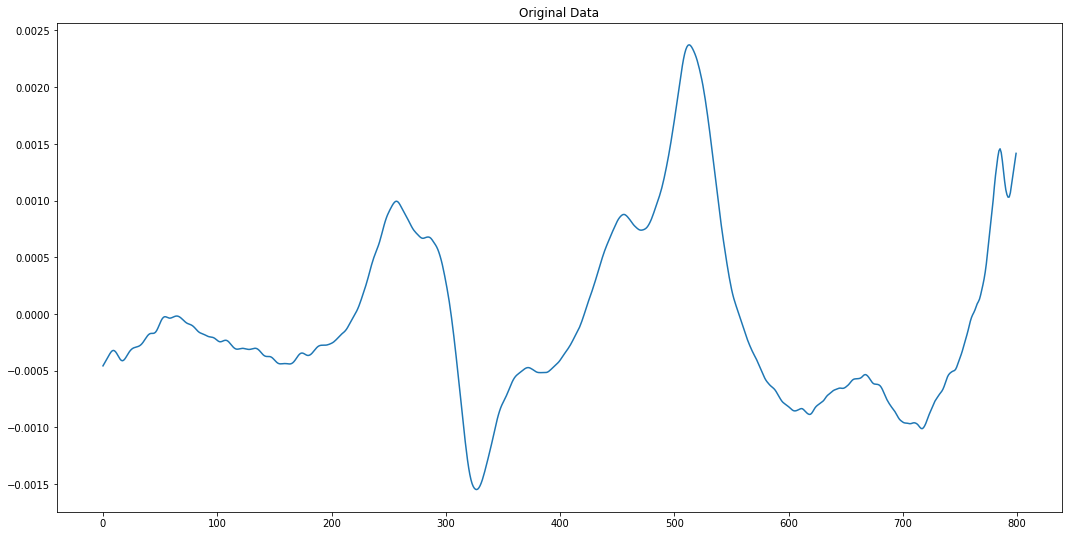

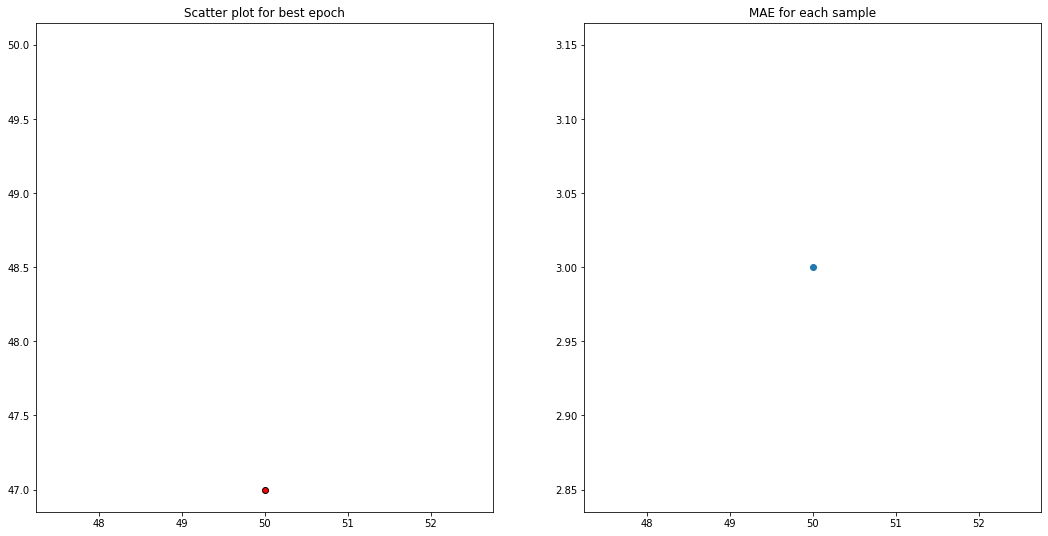

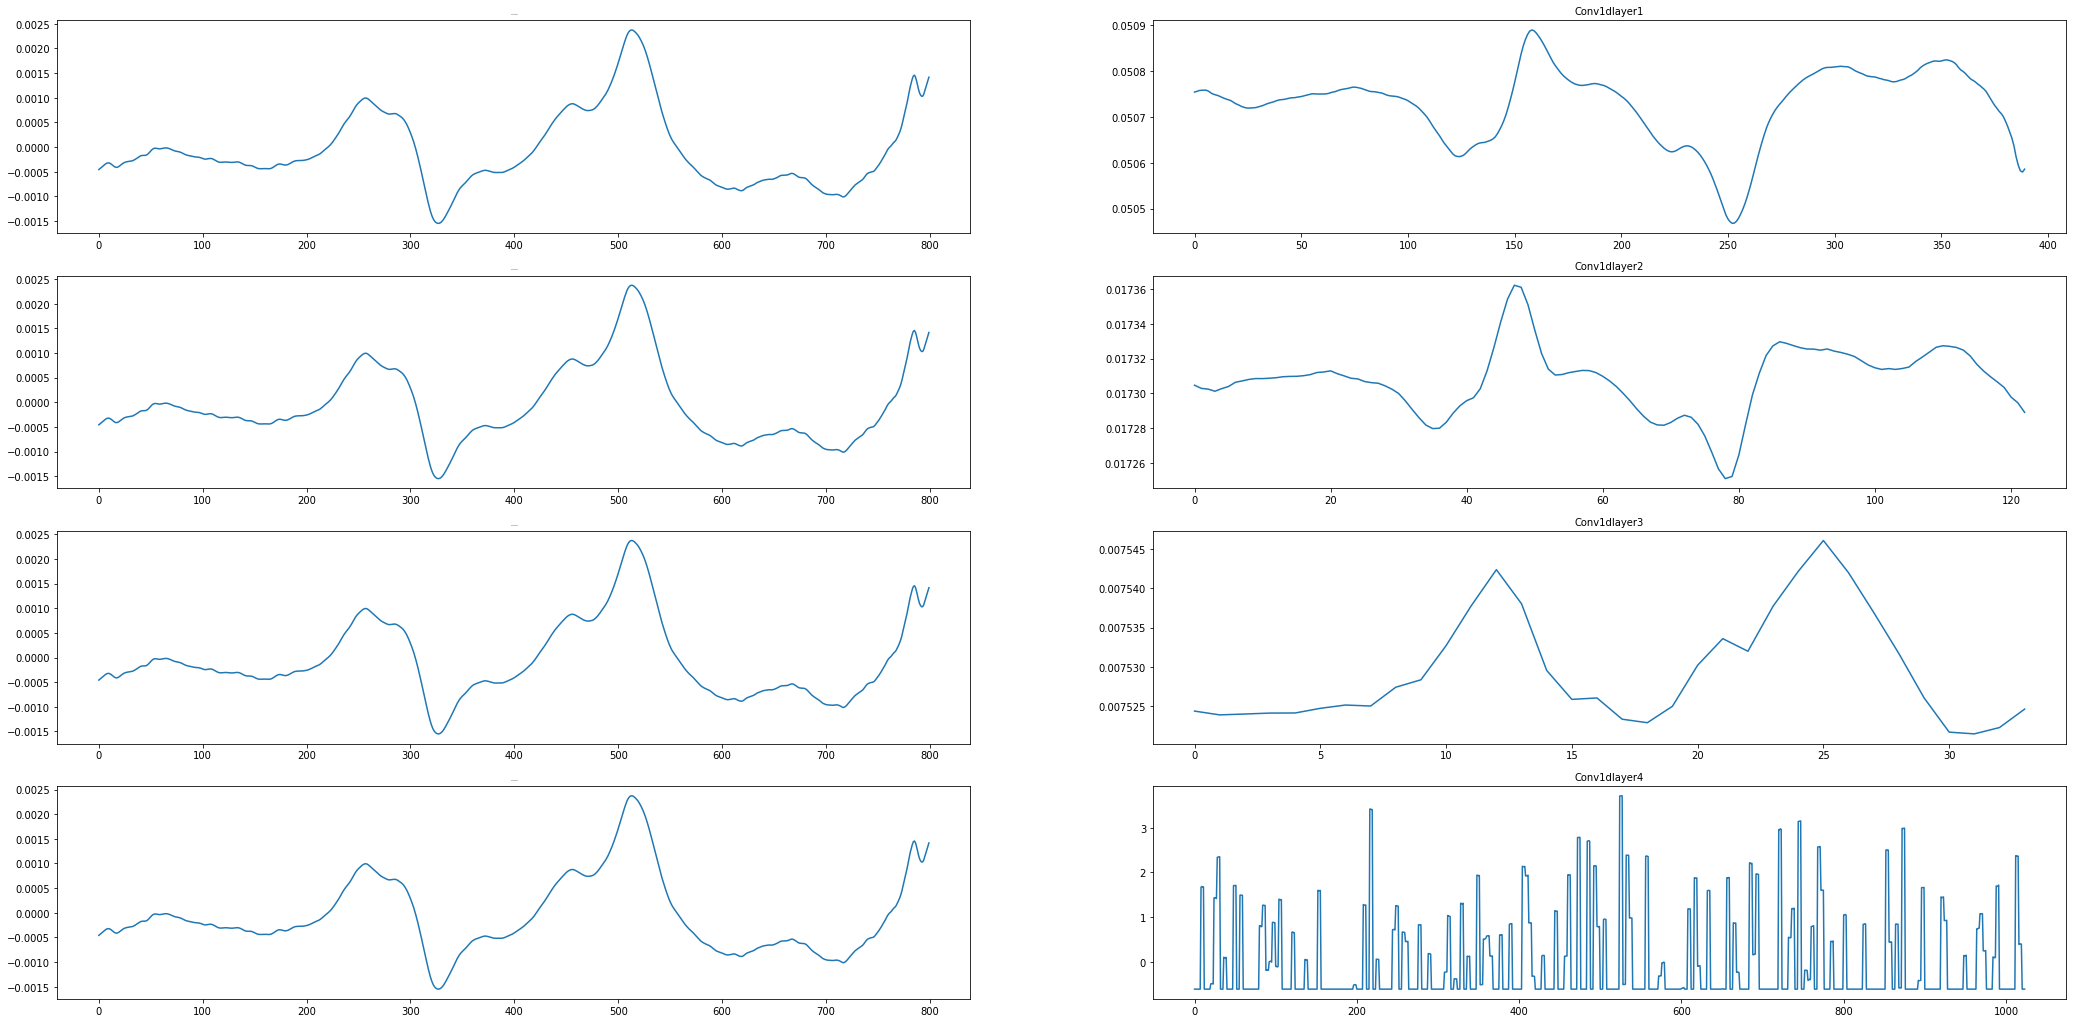

<Figure size 432x288 with 0 Axes>

In [152]:
import numpy as np
import pandas as pd
import random
import torch
import sys
from torch import nn
from torch import optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from datetime import datetime
import matplotlib.pyplot as plt
import sklearn.metrics
#from google.colab import files
import io
from scipy import signal as sg
from scipy.signal import savgol_filter
from torch.autograd import Function
from scipy.stats import chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from scipy.ndimage import convolve1d
from scipy.signal.windows import triang
from scipy.ndimage import gaussian_filter1d
import torch.nn.functional as F
import sys

# pynvml import *

b_size = 32 #batch size
np.random.seed(100)

# the 1DCNN model on Asta for regression with added ANN layer and 0.00001 learning rate and with SNV preprocessing with Huberloss and adam optimizer with changed window length =11, polyorder = 2
class D1CNN(nn.Module):
    def __init__(self):
        super(D1CNN,self).__init__()
        self.features = nn.Sequential()
        self.features.add_module('1_conv1d',nn.Conv1d(in_channels=1,out_channels=32,kernel_size=21))
        self.features.add_module('1_relu',nn.ReLU())            
        self.features.add_module('1_batchnorm',nn.BatchNorm1d(32))
        self.features.add_module('1_maxpool',nn.MaxPool1d(kernel_size=2))
    
        self.features.add_module('2_conv1d',nn.Conv1d(in_channels=32,out_channels=64,kernel_size=21))
        self.features.add_module('2_relu',nn.ReLU())
        self.features.add_module('2_batchnorm',nn.BatchNorm1d(64))
        self.features.add_module('2_maxpool',nn.MaxPool1d(kernel_size=3))

        self.features.add_module('3_conv1d',nn.Conv1d(in_channels=64,out_channels=128,kernel_size=21))
        self.features.add_module('3_relu',nn.ReLU())
        self.features.add_module('3_batchnorm',nn.BatchNorm1d(128))
        self.features.add_module('3_maxpool',nn.MaxPool1d(kernel_size=3))

        self.features.add_module('4_conv1d',nn.Conv1d(in_channels=128,out_channels=256,kernel_size=21))
        self.features.add_module('4_relu',nn.ReLU())
        self.features.add_module('4_batchnorm',nn.BatchNorm1d(256))
        self.features.add_module('4_maxpool',nn.MaxPool1d(kernel_size=3))
        
        self.features.add_module('drop_1',nn.Dropout(p=0.4))
    
        self.regress = nn.Sequential()
        self.regress.add_module('an_1',nn.Linear(1024,512))
        self.regress.add_module('an_Relu_1',nn.ReLU())
        self.regress.add_module('an_drop_1',nn.Dropout(p=0.2))
        self.regress.add_module('an_2',nn.Linear(512,512))
        self.regress.add_module('an_Relu_2',nn.ReLU())
        self.regress.add_module('an_drop_2',nn.Dropout(p=0.2))
        self.regress.add_module('an_3',nn.Linear(512,128))
        self.regress.add_module('an_Relu_3',nn.ReLU())
        self.regress.add_module('an_drop_3',nn.Dropout(p=0.2))
        self.regress.add_module('an_4',nn.Linear(128,128))
        self.regress.add_module('an_Relu_4',nn.ReLU())
        self.regress.add_module('an_drop_4',nn.Dropout(p=0.2))
        self.regress.add_module('an_5',nn.Linear(128,64))
        self.regress.add_module('an_Relu_5',nn.ReLU())
        self.regress.add_module('an_drop_5',nn.Dropout(p=0.2))
        self.regress.add_module('an_6',nn.Linear(64,1))

    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x,start_dim=1)
        x_out = self.regress(x)
        return x_out

# preprocessing functions
def moving_smoothing(input_array, window_length):

    m_rows = len(range(window_length, input_array.shape[1] - window_length))
    m_cols = 2*window_length
    matrix = np.zeros((m_rows,m_cols),dtype=int)
    for j in range(0, len(matrix)):
        k = j+1
        matrix[j] = [x for x in range(k,k+2*window_length)]
    #Smoothing spectra using matrix operations:
    n_cols = m_rows
    newspectra = np.zeros((len(input_array),n_cols))
    for i in range(len(matrix)):
        newspectra[:,i] = np.mean(input_array[: ,matrix[i]],axis=1)
    #Add front and end tails (not smoothed):
    #new_spectra = np.asarray(newspectra)
    fronttail = newspectra[:,:1]
    endtail = newspectra[:,-1:]
    for k in range(1,window_length):
        fronttail=np.append(fronttail,newspectra[:,:1], axis=1)
        endtail = np.append(endtail,newspectra[:,-1:], axis =1)
    data = np.concatenate((fronttail, newspectra, endtail), axis=1)
    return data

def derivate_first(input_array, window_length, polyorder):
    der1 = savgol_filter(input_array, window_length, polyorder,deriv = 1)
    return der1

def MSC(input_array, reference = None):
    ''' Perform Multiplicative scatter correction'''

    #Mean correction
    for i in range(input_array.shape[0]):
        input_array[i,:] -= input_array[i,:].mean()

    # Get the reference spectrum. If not given, estimate from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_array, axis=0)
    else:
        ref = reference

    # Define a new data matrix and populate it with the corrected data    
    output_data = np.zeros_like(input_array)
    for i in range(input_array.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_array[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_array[i,:] - fit[0][1]) / fit[0][0] 
    #print(fit)
    return output_data

def detrending(input_array):
    X = np.arange(input_array.shape[1])
    base = np.zeros((len(input_array),len(X)))
    for i in range(len(input_array)):
        c = np.polyfit(X, input_array[i], 2)
        base[i] = np.polyval(c, X)
    #Baseline removal
    base_remove = input_array - base
    return base_remove

def savitzky(input_array, window_length, polyorder):
    savgol = savgol_filter(input_array, window_length, polyorder)
    return savgol

def weighted_l1_loss(inputs, targets, weights=None):
    '''You need to correct this'''
    loss = F.l1_loss(inputs, targets, reduction='none')
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

def data_1D(f):
    sed = 100
    d_asta = pd.read_csv(f,encoding='utf-8')
    d_asta = d_asta.loc[:, ~d_asta.columns.str.contains('^Unnamed')]
    #col = [str(x) for x in range(0,151)]+[str(x) for x in range(751,801)]+['Sample ID','Cap']
    #col = ['Sample ID','Cap','800']
    #d_asta = df.drop(columns=col)
    #d_asta = d_asta.dropna(subset=['ASTA'])
    #d_asta['ASTA'] = d_asta['ASTA'].round()
    #d_asta = d_asta[d_asta['ASTA']>=50]
    #d_asta = d_asta[d_asta['ASTA']<120]

    X_val = np.array(d_asta.drop(columns = ['ASTA']))
    Y_val = np.array(d_asta['ASTA'])

    X_val = savitzky(X_val,11,2)
    X_val = MSC(X_val)
    X_val = detrending(X_val)
    X_val = derivate_first(X_val,11,2)


    return X_val[10],Y_val[10]

def run():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print('using'+device+'device')
    man_seed = 100
    torch.manual_seed(man_seed)
    model = D1CNN()
    model.load_state_dict(torch.load('model_asta_40_120_lds_dataaug_5_20220309_182454_659.pth',map_location = torch.device(device)))
    model.to(device)
    '''if float 64 is allowed then you can go with that too'''
    model.to(torch.float32)
    loss = weighted_l1_loss
    file_name = 'test_chili_asta.csv'
    x_val,y_val = data_1D(file_name)
    fig_1 = plt.figure(figsize =(18,9))
    ax = fig_1.add_subplot(1,1,1)
    ax.plot(x_val.transpose())
    ax.title.set_text('Original Data')
    model.eval()
    
    with torch.no_grad():

        v_x_dt = torch.from_numpy(x_val)
        v_x_dt = torch.unsqueeze(v_x_dt,dim=0)
        v_x_dt = torch.unsqueeze(v_x_dt,dim=0)
        
        v_x_dt = Variable(v_x_dt,requires_grad=False).to(device,dtype = torch.float32)
        print(v_x_dt.shape)
        v_y_dt = torch.from_numpy(np.array(y_val))
        v_y_dt = Variable(v_y_dt,requires_grad = False).to(device,dtype = torch.float32)
        v_yhat = model.forward(v_x_dt)
        v_yhat = torch.squeeze(v_yhat)
        v_yhat = torch.round(v_yhat)
        v_loss = loss(v_yhat,v_y_dt).item()

        b_yhat = v_yhat.to('cpu')
        b_y_t_1 = v_y_dt.to('cpu')
        #r2_score = sklearn.metrics.r2_score(b_y_t_1,b_yhat)
        
    
        v_x_dt.detach()
        v_y_dt.detach()
        v_yhat.detach()
        
    print("\n the MAE is %.4f\n"%(v_loss)),#r2_score))
    
    ttt = abs(b_yhat - b_y_t_1)
    
    
    fig_4 = plt.figure(figsize =(18,9))
    ax4 = fig_4.add_subplot(1,2,1)
    ax5 = fig_4.add_subplot(1,2,2)
    ax4.title.set_text('Scatter plot for best epoch')
    ax5.title.set_text('MAE for each sample')
    ax5.plot(b_y_t_1,ttt,marker ='o',linestyle='')
    ax4.scatter(b_y_t_1,b_yhat,c='red',edgecolors='k')
    ax4.plot(b_y_t_1,b_y_t_1,c='blue',linewidth = 1)
    fig_4.show()
    
    model_weights =[]
    conv_layers = []

    model_children = list(model.children())
    counter = 0

    #print(model_children)

    for i in range(len(model_children)):        

        if type(model_children[i])==nn.Sequential:
            for child in model_children[i].children():
                if type(child) == nn.Conv1d:
                    counter +=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
    
    print(f" Total convolution layers:{counter}")
    print("Conv_layers")
    
    test_x = v_x_dt
    outputs =[]
    names = []
    sdm = 0
    for layer in conv_layers[0:]:
        test_x = layer(test_x)
        m = nn.ReLU()
        test_x = m(test_x)
        if(sdm == 0):
            m = nn.MaxPool1d(kernel_size = 2)
        else:
            m = nn.MaxPool1d(kernel_size = 3)
        test_x = m(test_x)
        names.append(str(layer))
        if(sdm == 3):
            outputs.append(torch.flatten(test_x,start_dim = 1))
            #print(torch.flatten(test_x,start_dim = 1).shape)
        else:
            outputs.append(test_x)
            #print(test_x.shape)
        sdm = sdm + 1
        
    
    """for feature_map in outputs:
        feature_map = feature_map.squeeze(0)
        print(feature_map.shape)
        fig = plt.figure(figsize=(18,9))
        for i in range(feature_map.shape[0]):
            ss = feature_map[i].data.cpu().numpy()
            ss -= ss.mean()
            ss /= ss.std()
            plt.plot(ss.transpose())
            break
        break"""
        
    #print(np.array(outputs).shape)

    prcess= []
    jk = 0
    for feature_map in outputs:
        #feature_map = feature_map.squeeze(0)
        if(jk == 3):
            ss = feature_map.data.cpu().numpy()
            ss -= ss.mean()
            ss /= ss.std()
            prcess.append(ss.transpose())
        else:
            feature_map = feature_map.squeeze(0)
            gray_scale = torch.sum(feature_map,0)
            gray_scale = gray_scale/feature_map.shape[0]
            prcess.append(gray_scale.data.cpu().numpy())
        jk = jk + 1

    fig = plt.figure(figsize=(36, 18))
    for i in range(len(prcess)):
        a = fig.add_subplot(4, 2, 2*(i+1))
        imgplot = plt.plot(prcess[i])
        #a.axis("off")
        a.set_title(names[i].split('(')[0]+'layer'+str(i+1), fontsize=10)
        a_2 = fig.add_subplot(4, 2, (2*i)+1)
        plt.plot(x_val.transpose())
        #a.axis("off")
        a_2.set_title('input spectra', fontsize=0)
        
    
    plt.show()
    plt.savefig(str('feature_maps_asta.jpg'), bbox_inches='tight')
        
        
    
    #y_data = pd.DataFrame()
    #y_data['actual'] = b_y_t_1
    #y_data['predcted'] = b_yhat
    #y_data.to_csv('chili_val_test_data.csv')
    
if __name__ == '__main__':
    run()

#### Getting plots from all the layers in the model, to find the activations

usingcpudevice
torch.Size([1, 1, 800])

 the MAE is 8.0000


 the asta value is 85


C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/2882643300.py:239: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_4.show()


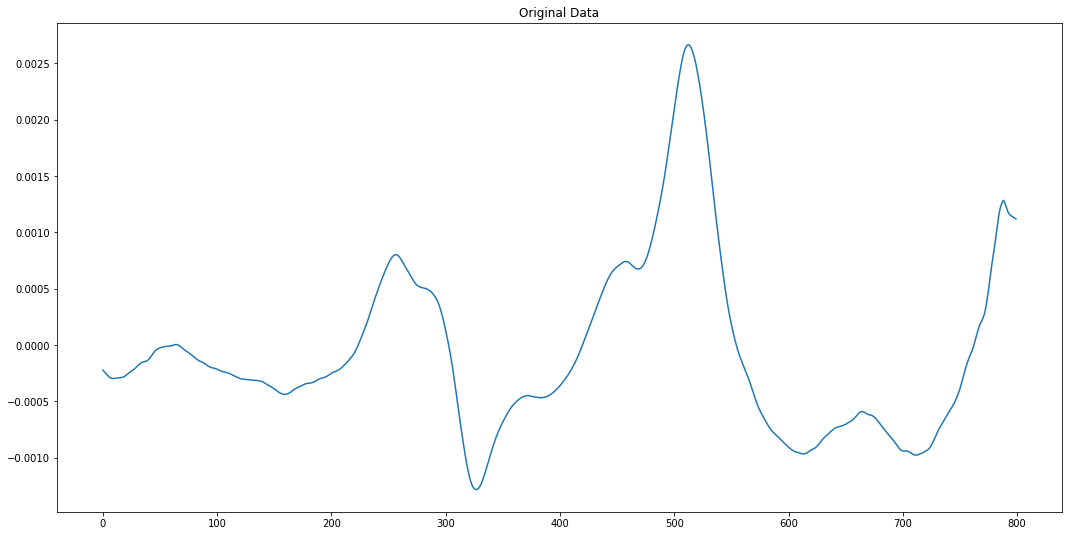

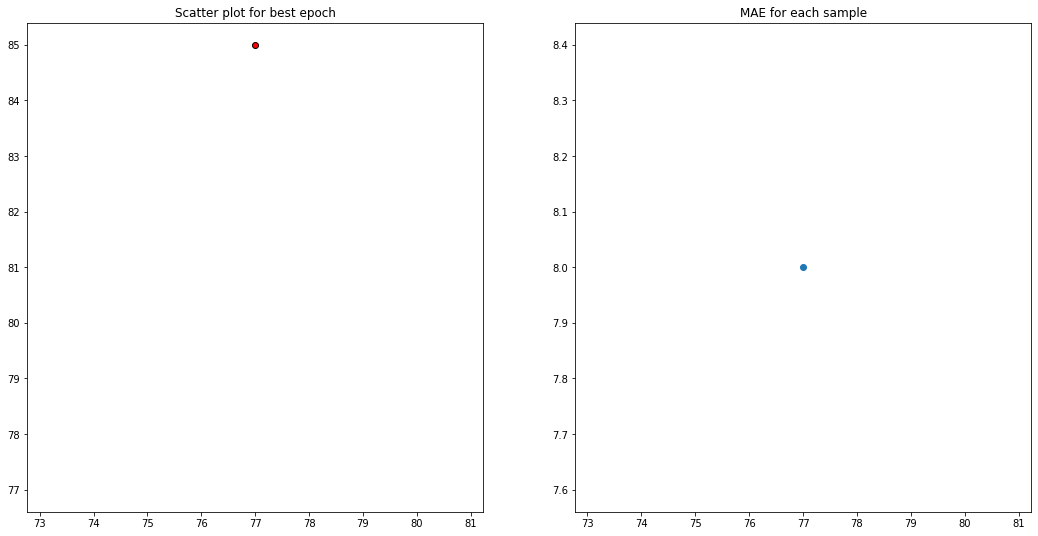

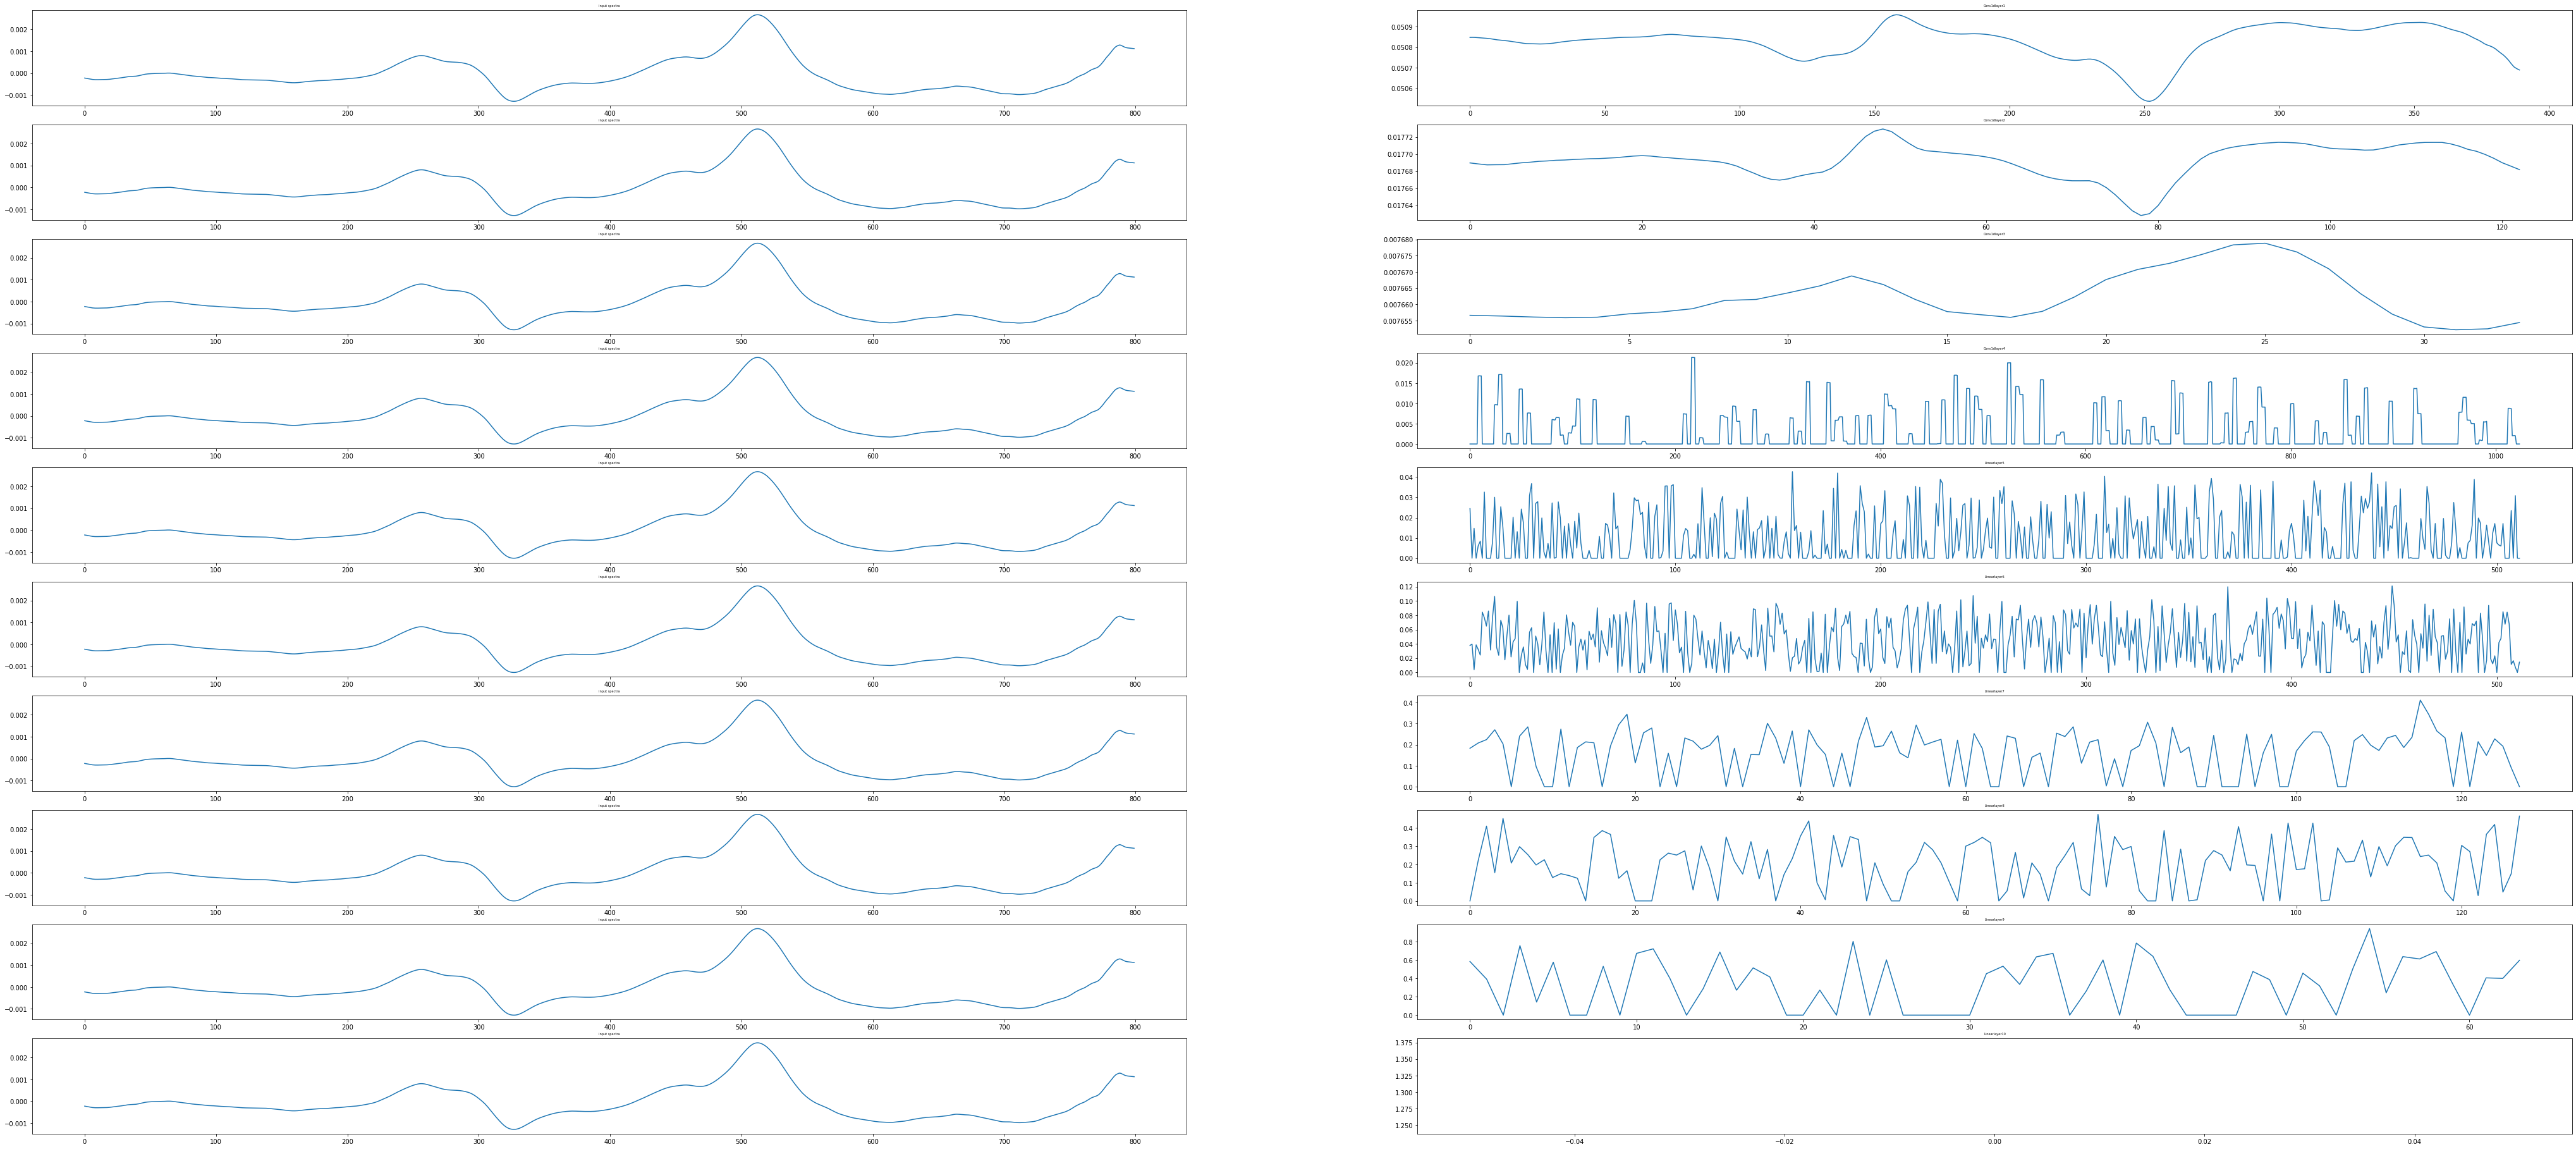

<Figure size 432x288 with 0 Axes>

In [167]:
import numpy as np
import pandas as pd
import random
import torch
import sys
from torch import nn
from torch import optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from datetime import datetime
import matplotlib.pyplot as plt
import sklearn.metrics
#from google.colab import files
import io
from scipy import signal as sg
from scipy.signal import savgol_filter
from torch.autograd import Function
from scipy.stats import chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from scipy.ndimage import convolve1d
from scipy.signal.windows import triang
from scipy.ndimage import gaussian_filter1d
import torch.nn.functional as F
import sys

# pynvml import *

b_size = 32 #batch size
np.random.seed(100)

# the 1DCNN model on Asta for regression with added ANN layer and 0.00001 learning rate and with SNV preprocessing with Huberloss and adam optimizer with changed window length =11, polyorder = 2
class D1CNN(nn.Module):
    def __init__(self):
        super(D1CNN,self).__init__()
        self.features = nn.Sequential()
        self.features.add_module('1_conv1d',nn.Conv1d(in_channels=1,out_channels=32,kernel_size=21))
        self.features.add_module('1_relu',nn.ReLU())            
        self.features.add_module('1_batchnorm',nn.BatchNorm1d(32))
        self.features.add_module('1_maxpool',nn.MaxPool1d(kernel_size=2))
    
        self.features.add_module('2_conv1d',nn.Conv1d(in_channels=32,out_channels=64,kernel_size=21))
        self.features.add_module('2_relu',nn.ReLU())
        self.features.add_module('2_batchnorm',nn.BatchNorm1d(64))
        self.features.add_module('2_maxpool',nn.MaxPool1d(kernel_size=3))

        self.features.add_module('3_conv1d',nn.Conv1d(in_channels=64,out_channels=128,kernel_size=21))
        self.features.add_module('3_relu',nn.ReLU())
        self.features.add_module('3_batchnorm',nn.BatchNorm1d(128))
        self.features.add_module('3_maxpool',nn.MaxPool1d(kernel_size=3))

        self.features.add_module('4_conv1d',nn.Conv1d(in_channels=128,out_channels=256,kernel_size=21))
        self.features.add_module('4_relu',nn.ReLU())
        self.features.add_module('4_batchnorm',nn.BatchNorm1d(256))
        self.features.add_module('4_maxpool',nn.MaxPool1d(kernel_size=3))
        
        self.features.add_module('drop_1',nn.Dropout(p=0.4))
    
        self.regress = nn.Sequential()
        self.regress.add_module('an_1',nn.Linear(1024,512))
        self.regress.add_module('an_Relu_1',nn.ReLU())
        self.regress.add_module('an_drop_1',nn.Dropout(p=0.2))
        self.regress.add_module('an_2',nn.Linear(512,512))
        self.regress.add_module('an_Relu_2',nn.ReLU())
        self.regress.add_module('an_drop_2',nn.Dropout(p=0.2))
        self.regress.add_module('an_3',nn.Linear(512,128))
        self.regress.add_module('an_Relu_3',nn.ReLU())
        self.regress.add_module('an_drop_3',nn.Dropout(p=0.2))
        self.regress.add_module('an_4',nn.Linear(128,128))
        self.regress.add_module('an_Relu_4',nn.ReLU())
        self.regress.add_module('an_drop_4',nn.Dropout(p=0.2))
        self.regress.add_module('an_5',nn.Linear(128,64))
        self.regress.add_module('an_Relu_5',nn.ReLU())
        self.regress.add_module('an_drop_5',nn.Dropout(p=0.2))
        self.regress.add_module('an_6',nn.Linear(64,1))

    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x,start_dim=1)
        x_out = self.regress(x)
        return x_out

# preprocessing functions
def moving_smoothing(input_array, window_length):

    m_rows = len(range(window_length, input_array.shape[1] - window_length))
    m_cols = 2*window_length
    matrix = np.zeros((m_rows,m_cols),dtype=int)
    for j in range(0, len(matrix)):
        k = j+1
        matrix[j] = [x for x in range(k,k+2*window_length)]
    #Smoothing spectra using matrix operations:
    n_cols = m_rows
    newspectra = np.zeros((len(input_array),n_cols))
    for i in range(len(matrix)):
        newspectra[:,i] = np.mean(input_array[: ,matrix[i]],axis=1)
    #Add front and end tails (not smoothed):
    #new_spectra = np.asarray(newspectra)
    fronttail = newspectra[:,:1]
    endtail = newspectra[:,-1:]
    for k in range(1,window_length):
        fronttail=np.append(fronttail,newspectra[:,:1], axis=1)
        endtail = np.append(endtail,newspectra[:,-1:], axis =1)
    data = np.concatenate((fronttail, newspectra, endtail), axis=1)
    return data

def derivate_first(input_array, window_length, polyorder):
    der1 = savgol_filter(input_array, window_length, polyorder,deriv = 1)
    return der1

def MSC(input_array, reference = None):
    ''' Perform Multiplicative scatter correction'''

    #Mean correction
    for i in range(input_array.shape[0]):
        input_array[i,:] -= input_array[i,:].mean()

    # Get the reference spectrum. If not given, estimate from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_array, axis=0)
    else:
        ref = reference

    # Define a new data matrix and populate it with the corrected data    
    output_data = np.zeros_like(input_array)
    for i in range(input_array.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_array[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_array[i,:] - fit[0][1]) / fit[0][0] 
    #print(fit)
    return output_data

def detrending(input_array):
    X = np.arange(input_array.shape[1])
    base = np.zeros((len(input_array),len(X)))
    for i in range(len(input_array)):
        c = np.polyfit(X, input_array[i], 2)
        base[i] = np.polyval(c, X)
    #Baseline removal
    base_remove = input_array - base
    return base_remove

def savitzky(input_array, window_length, polyorder):
    savgol = savgol_filter(input_array, window_length, polyorder)
    return savgol

def weighted_l1_loss(inputs, targets, weights=None):
    '''You need to correct this'''
    loss = F.l1_loss(inputs, targets, reduction='none')
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

def data_1D(f):
    sed = 100
    d_asta = pd.read_csv(f,encoding='utf-8')
    d_asta = d_asta.loc[:, ~d_asta.columns.str.contains('^Unnamed')]
    #col = [str(x) for x in range(0,151)]+[str(x) for x in range(751,801)]+['Sample ID','Cap']
    #col = ['Sample ID','Cap','800']
    #d_asta = df.drop(columns=col)
    #d_asta = d_asta.dropna(subset=['ASTA'])
    #d_asta['ASTA'] = d_asta['ASTA'].round()
    #d_asta = d_asta[d_asta['ASTA']>=50]
    #d_asta = d_asta[d_asta['ASTA']<120]

    X_val = np.array(d_asta.drop(columns = ['ASTA']))
    Y_val = np.array(d_asta['ASTA'])

    X_val = savitzky(X_val,11,2)
    X_val = MSC(X_val)
    X_val = detrending(X_val)
    X_val = derivate_first(X_val,11,2)


    return X_val[37],Y_val[37]

def run():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print('using'+device+'device')
    man_seed = 100
    torch.manual_seed(man_seed)
    model = D1CNN()
    model.load_state_dict(torch.load('model_asta_40_120_lds_dataaug_7_20220311_152247_568.pth',map_location = torch.device(device)))
    model.to(device)
    '''if float 64 is allowed then you can go with that too'''
    model.to(torch.float32)
    loss = weighted_l1_loss
    file_name = 'test_chili_asta.csv'
    x_val,y_val = data_1D(file_name)
    fig_1 = plt.figure(figsize =(18,9))
    ax = fig_1.add_subplot(1,1,1)
    ax.plot(x_val.transpose())
    ax.title.set_text('Original Data')
    model.eval()
    
    with torch.no_grad():

        v_x_dt = torch.from_numpy(x_val)
        v_x_dt = torch.unsqueeze(v_x_dt,dim=0)
        v_x_dt = torch.unsqueeze(v_x_dt,dim=0)
        
        v_x_dt = Variable(v_x_dt,requires_grad=False).to(device,dtype = torch.float32)
        print(v_x_dt.shape)
        v_y_dt = torch.from_numpy(np.array(y_val))
        v_y_dt = Variable(v_y_dt,requires_grad = False).to(device,dtype = torch.float32)
        v_yhat = model.forward(v_x_dt)
        v_yhat = torch.squeeze(v_yhat)
        v_yhat = torch.round(v_yhat)
        v_loss = loss(v_yhat,v_y_dt).item()

        b_yhat = v_yhat.to('cpu')
        b_y_t_1 = v_y_dt.to('cpu')
        #r2_score = sklearn.metrics.r2_score(b_y_t_1,b_yhat)
        
    
        v_x_dt.detach()
        v_y_dt.detach()
        v_yhat.detach()
        
    print("\n the MAE is %.4f\n"%(v_loss)),#r2_score))
    print('\n the asta value is %d'%(b_yhat))
    
    ttt = abs(b_yhat - b_y_t_1)
    
    
    fig_4 = plt.figure(figsize =(18,9))
    ax4 = fig_4.add_subplot(1,2,1)
    ax5 = fig_4.add_subplot(1,2,2)
    ax4.title.set_text('Scatter plot for best epoch')
    ax5.title.set_text('MAE for each sample')
    ax5.plot(b_y_t_1,ttt,marker ='o',linestyle='')
    ax4.scatter(b_y_t_1,b_yhat,c='red',edgecolors='k')
    ax4.plot(b_y_t_1,b_y_t_1,c='blue',linewidth = 1)
    fig_4.show()
    
    model_weights_conv = []
    model_weights_ann = []
    conv_layers = []
    ann_layers = []
    
    model_children = list(model.children())
    count_conv = 0
    count_ann = 0

    #print(model_children)

    for i in range(len(model_children)):        

        if type(model_children[i])==nn.Sequential:
            for child in model_children[i].children():
                if type(child) == nn.Conv1d:
                    count_conv +=1
                    model_weights_conv.append(child.weight)
                    conv_layers.append(child)
                
                if type(child) == nn.Linear:
                    count_ann +=1
                    model_weights_ann.append(child.weight)
                    ann_layers.append(child)
                    
    #print(conv_layers)
    #print(ann_layers)
    
    test_x = v_x_dt
    outputs =[]
    names = []
    sdm = 0
    for layer in conv_layers[0:]:
        test_x = layer(test_x)
        m = nn.ReLU()
        test_x = m(test_x)
        if(sdm == 0):
            m = nn.MaxPool1d(kernel_size = 2)
        else:
            m = nn.MaxPool1d(kernel_size = 3)
        test_x = m(test_x)
        names.append(str(layer))
        if(sdm == 3):
            test_x = torch.flatten(test_x,start_dim = 1)
            outputs.append(test_x)
            #print(torch.flatten(test_x,start_dim = 1).shape)
        else:
            outputs.append(test_x)
            #print(test_x.shape)
        sdm = sdm + 1
    
    outputs_ann = []
    for layer in ann_layers[0:]:
        test_x = layer(test_x)
        m = nn.ReLU()
        test_x = m(test_x)
        names.append(str(layer))
        outputs_ann.append(test_x)
        
    prcess= []
    jk = 0
    for feature_map in outputs:
        #feature_map = feature_map.squeeze(0)
        if(jk == 3):
            ss = feature_map.data.cpu().numpy()
            #ss -= ss.mean()
            #ss /= ss.std()
            prcess.append(ss.transpose())
        else:
            feature_map = feature_map.squeeze(0)
            gray_scale = torch.sum(feature_map,0)
            gray_scale = gray_scale/feature_map.shape[0]
            prcess.append(gray_scale.data.cpu().numpy())
        jk = jk + 1
    
    for feature_map in outputs_ann:
        ss = feature_map.data.cpu().numpy()
        #ss -= ss.mean()
        #ss /= ss.std()
        prcess.append(ss.transpose())
    
    fig = plt.figure(figsize=(72, 36))
    g = len(prcess)
    for i in range(g):
        a = fig.add_subplot(g+1, 2, 2*(i+1))
        imgplot = plt.plot(prcess[i])
        #a.axis("off")
        a.set_title(names[i].split('(')[0]+'layer'+str(i+1), fontsize=5)
        a_2 = fig.add_subplot(g+1, 2, (2*i)+1)
        plt.plot(x_val.transpose())
        #a.axis("off")
        a_2.set_title('input spectra', fontsize=5)
        
    
    plt.show()
    plt.savefig(str('all_feature_maps_asta.jpg'), bbox_inches='tight')
    
if __name__ == '__main__':
    run()    
    
    

#### Checking with two samples of same asta value and predicition

usingcpudevice
torch.Size([3, 1, 800])

 the MAE is 2.3333

[53. 57. 57.]
[51. 55. 60.]


C:\Users\Admin\AppData\Local\Temp/ipykernel_3896/2464844671.py:240: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_4.show()


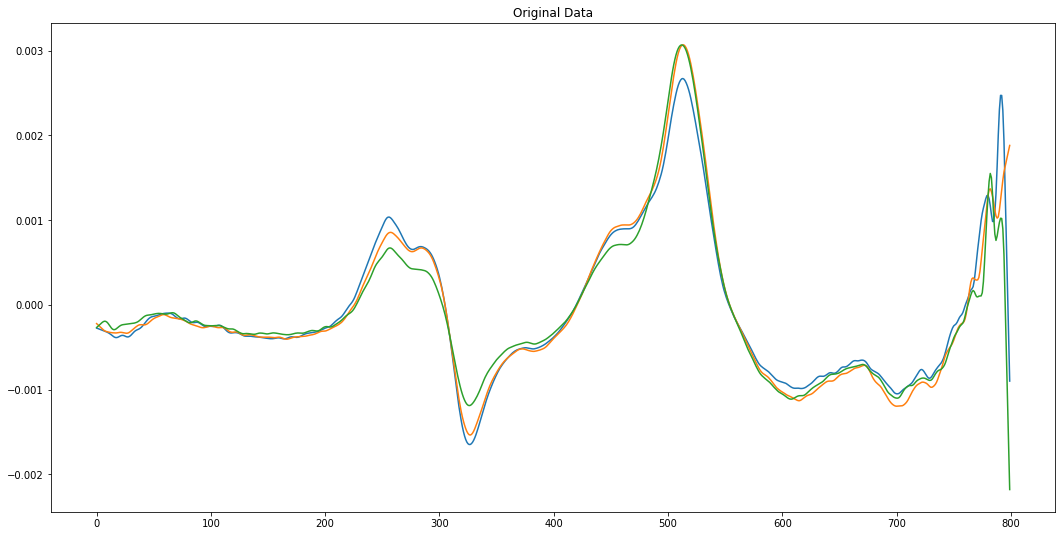

<Figure size 1296x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [1]:
import numpy as np
import pandas as pd
import random
import torch
import sys
from torch import nn
from torch import optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from datetime import datetime
import matplotlib.pyplot as plt
import sklearn.metrics
#from google.colab import files
import io
from scipy import signal as sg
from scipy.signal import savgol_filter
from torch.autograd import Function
from scipy.stats import chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from scipy.ndimage import convolve1d
from scipy.signal.windows import triang
from scipy.ndimage import gaussian_filter1d
import torch.nn.functional as F
import sys

# pynvml import *

b_size = 32 #batch size
np.random.seed(100)

# the 1DCNN model on Asta for regression with added ANN layer and 0.00001 learning rate and with SNV preprocessing with Huberloss and adam optimizer with changed window length =11, polyorder = 2
class D1CNN(nn.Module):
    def __init__(self):
        super(D1CNN,self).__init__()
        self.features = nn.Sequential()
        self.features.add_module('1_conv1d',nn.Conv1d(in_channels=1,out_channels=32,kernel_size=21))
        self.features.add_module('1_relu',nn.ReLU())            
        self.features.add_module('1_batchnorm',nn.BatchNorm1d(32))
        self.features.add_module('1_maxpool',nn.MaxPool1d(kernel_size=2))
    
        self.features.add_module('2_conv1d',nn.Conv1d(in_channels=32,out_channels=64,kernel_size=21))
        self.features.add_module('2_relu',nn.ReLU())
        self.features.add_module('2_batchnorm',nn.BatchNorm1d(64))
        self.features.add_module('2_maxpool',nn.MaxPool1d(kernel_size=3))

        self.features.add_module('3_conv1d',nn.Conv1d(in_channels=64,out_channels=128,kernel_size=21))
        self.features.add_module('3_relu',nn.ReLU())
        self.features.add_module('3_batchnorm',nn.BatchNorm1d(128))
        self.features.add_module('3_maxpool',nn.MaxPool1d(kernel_size=3))

        self.features.add_module('4_conv1d',nn.Conv1d(in_channels=128,out_channels=256,kernel_size=21))
        self.features.add_module('4_relu',nn.ReLU())
        self.features.add_module('4_batchnorm',nn.BatchNorm1d(256))
        self.features.add_module('4_maxpool',nn.MaxPool1d(kernel_size=3))
        
        self.features.add_module('drop_1',nn.Dropout(p=0.4))
    
        self.regress = nn.Sequential()
        self.regress.add_module('an_1',nn.Linear(1024,512))
        self.regress.add_module('an_Relu_1',nn.ReLU())
        self.regress.add_module('an_drop_1',nn.Dropout(p=0.2))
        self.regress.add_module('an_2',nn.Linear(512,512))
        self.regress.add_module('an_Relu_2',nn.ReLU())
        self.regress.add_module('an_drop_2',nn.Dropout(p=0.2))
        self.regress.add_module('an_3',nn.Linear(512,128))
        self.regress.add_module('an_Relu_3',nn.ReLU())
        self.regress.add_module('an_drop_3',nn.Dropout(p=0.2))
        self.regress.add_module('an_4',nn.Linear(128,128))
        self.regress.add_module('an_Relu_4',nn.ReLU())
        self.regress.add_module('an_drop_4',nn.Dropout(p=0.2))
        self.regress.add_module('an_5',nn.Linear(128,64))
        self.regress.add_module('an_Relu_5',nn.ReLU())
        self.regress.add_module('an_drop_5',nn.Dropout(p=0.2))
        self.regress.add_module('an_6',nn.Linear(64,1))

    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x,start_dim=1)
        x_out = self.regress(x)
        return x_out

# preprocessing functions
def moving_smoothing(input_array, window_length):

    m_rows = len(range(window_length, input_array.shape[1] - window_length))
    m_cols = 2*window_length
    matrix = np.zeros((m_rows,m_cols),dtype=int)
    for j in range(0, len(matrix)):
        k = j+1
        matrix[j] = [x for x in range(k,k+2*window_length)]
    #Smoothing spectra using matrix operations:
    n_cols = m_rows
    newspectra = np.zeros((len(input_array),n_cols))
    for i in range(len(matrix)):
        newspectra[:,i] = np.mean(input_array[: ,matrix[i]],axis=1)
    #Add front and end tails (not smoothed):
    #new_spectra = np.asarray(newspectra)
    fronttail = newspectra[:,:1]
    endtail = newspectra[:,-1:]
    for k in range(1,window_length):
        fronttail=np.append(fronttail,newspectra[:,:1], axis=1)
        endtail = np.append(endtail,newspectra[:,-1:], axis =1)
    data = np.concatenate((fronttail, newspectra, endtail), axis=1)
    return data

def derivate_first(input_array, window_length, polyorder):
    der1 = savgol_filter(input_array, window_length, polyorder,deriv = 1)
    return der1

def MSC(input_array, reference = None):
    ''' Perform Multiplicative scatter correction'''

    #Mean correction
    for i in range(input_array.shape[0]):
        input_array[i,:] -= input_array[i,:].mean()

    # Get the reference spectrum. If not given, estimate from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_array, axis=0)
    else:
        ref = reference

    # Define a new data matrix and populate it with the corrected data    
    output_data = np.zeros_like(input_array)
    for i in range(input_array.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_array[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_array[i,:] - fit[0][1]) / fit[0][0] 
    #print(fit)
    return output_data

def detrending(input_array):
    X = np.arange(input_array.shape[1])
    base = np.zeros((len(input_array),len(X)))
    for i in range(len(input_array)):
        c = np.polyfit(X, input_array[i], 2)
        base[i] = np.polyval(c, X)
    #Baseline removal
    base_remove = input_array - base
    return base_remove

def savitzky(input_array, window_length, polyorder):
    savgol = savgol_filter(input_array, window_length, polyorder)
    return savgol

def weighted_l1_loss(inputs, targets, weights=None):
    '''You need to correct this'''
    loss = F.l1_loss(inputs, targets, reduction='none')
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

def data_1D(f):
    sed = 100
    d_asta = pd.read_csv(f,encoding='utf-8')
    d_asta = d_asta.loc[:, ~d_asta.columns.str.contains('^Unnamed')]
    #col = [str(x) for x in range(0,151)]+[str(x) for x in range(751,801)]+['Sample ID','Cap']
    #col = ['Sample ID','Cap','800']
    #d_asta = df.drop(columns=col)
    #d_asta = d_asta.dropna(subset=['ASTA'])
    #d_asta['ASTA'] = d_asta['ASTA'].round()
    #d_asta = d_asta[d_asta['ASTA']>=50]
    #d_asta = d_asta[d_asta['ASTA']<120]

    X_val = np.array(d_asta.drop(columns = ['ASTA']))
    Y_val = np.array(d_asta['ASTA'])

    X_val = savitzky(X_val,11,2)
    X_val = MSC(X_val)
    X_val = detrending(X_val)
    X_val = derivate_first(X_val,11,2)


    return X_val[58:60],Y_val[58:60]

def run():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print('using'+device+'device')
    man_seed = 100
    torch.manual_seed(man_seed)
    model = D1CNN()
    model.load_state_dict(torch.load('model_asta_40_120_lds_dataaug_7_20220311_152247_568.pth',map_location = torch.device(device)))
    model.to(device)
    '''if float 64 is allowed then you can go with that too'''
    model.to(torch.float32)
    loss = weighted_l1_loss
    file_name = 'train_aug_test.csv'
    x_val,y_val = data_1D(file_name)
    fig_1 = plt.figure(figsize =(18,9))
    ax = fig_1.add_subplot(1,1,1)
    ax.plot(x_val.transpose())
    ax.title.set_text('Original Data')
    model.eval()
    
    with torch.no_grad():

        v_x_dt = torch.from_numpy(x_val)
        v_x_dt = torch.unsqueeze(v_x_dt,dim=1)
        #v_x_dt = torch.unsqueeze(v_x_dt,dim=0)
        
        v_x_dt = Variable(v_x_dt,requires_grad=False).to(device,dtype = torch.float32)
        print(v_x_dt.shape)
        v_y_dt = torch.from_numpy(np.array(y_val))
        v_y_dt = Variable(v_y_dt,requires_grad = False).to(device,dtype = torch.float32)
        v_yhat = model.forward(v_x_dt)
        v_yhat = torch.squeeze(v_yhat)
        v_yhat = torch.round(v_yhat)
        v_loss = loss(v_yhat,v_y_dt).item()

        b_yhat = v_yhat.to('cpu')
        b_y_t_1 = v_y_dt.to('cpu')
        #r2_score = sklearn.metrics.r2_score(b_y_t_1,b_yhat)
        
    
        v_x_dt.detach()
        v_y_dt.detach()
        v_yhat.detach()
        
    print("\n the MAE is %.4f\n"%(v_loss)),#r2_score))
    print(np.array(b_yhat))
    print(np.array(b_y_t_1))
    
    ttt = abs(b_yhat - b_y_t_1)
    
    
    fig_4 = plt.figure(figsize =(18,9))
    ax4 = fig_4.add_subplot(1,2,1)
    ax5 = fig_4.add_subplot(1,2,2)
    ax4.title.set_text('Scatter plot for best epoch')
    ax5.title.set_text('MAE for each sample')
    ax5.plot(b_y_t_1,ttt,marker ='o',linestyle='')
    ax4.scatter(b_y_t_1,b_yhat,c='red',edgecolors='k')
    ax4.plot(b_y_t_1,b_y_t_1,c='blue',linewidth = 1)
    fig_4.show()
    
    model_weights_conv = []
    model_weights_ann = []
    conv_layers = []
    ann_layers = []
    
    model_children = list(model.children())
    count_conv = 0
    count_ann = 0

    #print(model_children)

    for i in range(len(model_children)):        

        if type(model_children[i])==nn.Sequential:
            for child in model_children[i].children():
                if type(child) == nn.Conv1d:
                    count_conv +=1
                    model_weights_conv.append(child.weight)
                    conv_layers.append(child)
                
                if type(child) == nn.Linear:
                    count_ann +=1
                    model_weights_ann.append(child.weight)
                    ann_layers.append(child)
                    
    #print(conv_layers)
    #print(ann_layers)
    
    test_x = v_x_dt
    outputs =[]
    names = []
    sdm = 0
    for layer in conv_layers[0:]:
        test_x = layer(test_x)
        m = nn.ReLU()
        test_x = m(test_x)
        if(sdm == 0):
            m = nn.MaxPool1d(kernel_size = 2)
        else:
            m = nn.MaxPool1d(kernel_size = 3)
        test_x = m(test_x)
        names.append(str(layer))
        if(sdm == 3):
            test_x = torch.flatten(test_x,start_dim = 1)
            #print(test_x.shape)
            outputs.append(test_x)
            #print(torch.flatten(test_x,start_dim = 1).shape)
        else:
            outputs.append(test_x)
            #print(test_x.shape)
        sdm = sdm + 1
    
    outputs_ann = []
    for layer in ann_layers[0:]:
        test_x = layer(test_x)
        m = nn.ReLU()
        test_x = m(test_x)
        names.append(str(layer))
        #print(test_x.shape)
        outputs_ann.append(test_x)
        
    prcess= []
    jk = 0
    for feature_map in outputs:
        #feature_map = feature_map.squeeze(0)
        if(jk == 3):
            ss = feature_map.data.cpu().numpy()
            ss -= ss.mean()
            ss /= ss.std()
            prcess.append(ss.transpose())
        else:
            feature_map = feature_map.squeeze(0)
            #print (feature_map.shape)
            gray_scale = torch.sum(feature_map,1)
            gray_scale = gray_scale/feature_map.shape[1]
            ss = gray_scale.data.cpu().numpy()
            ss -= ss.mean()
            ss /= ss.std()
            #print(gray_scale.shape)
            prcess.append(ss.transpose())
        jk = jk + 1
    
    fig = plt.figure(figsize=(18,4))
    for feature_map in outputs_ann:
        #print(feature_map.shape)
        ss = feature_map.data.cpu().numpy().transpose()
        #print(ss[:,2])
        #for i in range(feature_map.shape[0]):
            #plt.plot(ss[:,i])
            #plt.plot(ss[:])
        ss -= ss.mean()
        ss /= ss.std()
        prcess.append(ss)
    
    fig = plt.figure(figsize=(72, 36))
    g = len(prcess)
    for i in range(g):
        a = fig.add_subplot(g, 2, 2*(i+1))
        imgplot = plt.plot(prcess[i])
        #a.axis("off")
        a.set_title(names[i].split('(')[0]+'layer'+str(i+1), fontsize=5)
        a_2 = fig.add_subplot(g, 2, (2*i)+1)
        plt.plot(x_val.transpose())
        #a.axis("off")
        a_2.set_title('input spectra', fontsize=5)
        
    
    plt.show()
    plt.savefig(str('all_feature_maps_asta.jpg'), bbox_inches='tight')
    
if __name__ == '__main__':
    run()

usingcpudevice
torch.Size([32, 1, 21])


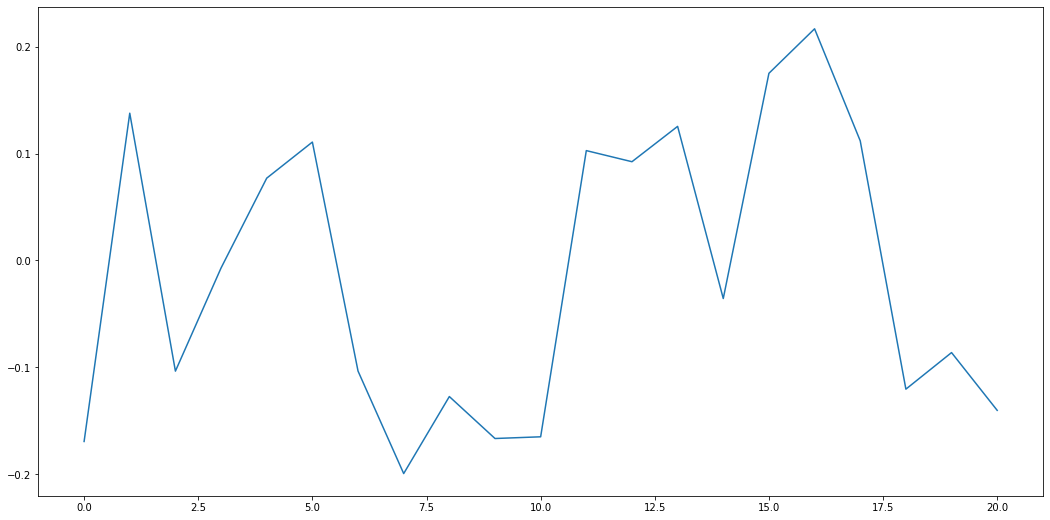

In [133]:
import numpy as np
import pandas as pd
import random
import torch
import sys
from torch import nn
from torch import optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from datetime import datetime
import matplotlib.pyplot as plt
import sklearn.metrics
#from google.colab import files
import io
from scipy import signal as sg
from scipy.signal import savgol_filter
from torch.autograd import Function
from scipy.stats import chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from scipy.ndimage import convolve1d
from scipy.signal.windows import triang
from scipy.ndimage import gaussian_filter1d
import torch.nn.functional as F
import sys

def savitzky(input_array, window_length, polyorder):
    savgol = savgol_filter(input_array, window_length, polyorder)
    return savgol

def run():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print('using'+device+'device')
    man_seed = 100
    torch.manual_seed(man_seed)
    model = D1CNN()
    model.load_state_dict(torch.load('model_asta_40_120_lds_dataaug_5_20220309_182454_659.pth',map_location = torch.device(device)))
    model.to(device)
    '''if float 64 is allowed then you can go with that too'''
    model.to(torch.float32)
    
    model_weights =[]
    conv_layers = []

    model_children = list(model.children())
    counter = 0

    #print(model_children)

    for i in range(len(model_children)):        

        if type(model_children[i])==nn.Sequential:
            t = list(model_children[i].children())
            for i in range(len(t)):
                if type(t[i]) == nn.Conv1d:
                    counter +=1
                    model_weights.append(t[i].weight)
                    conv_layers.append(t[i])
    
    for feature_map in model_weights:
        feature_map = feature_map.squeeze(0)
        print(feature_map.shape)
        fig = plt.figure(figsize=(18,9))
        for i in range(feature_map.shape[0]):
            ss = feature_map[i].data.cpu().numpy()
            #ss = savitzky(ss,21,2)
            plt.plot(ss.transpose())
            break
        break

if __name__== '__main__':
    run()

In [131]:
import numpy as np
import pandas as pd
import random
import torch
import sys
from torch import nn
from torch import optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from datetime import datetime
import matplotlib.pyplot as plt
import sklearn.metrics
#from google.colab import files
import io
from scipy import signal as sg
from scipy.signal import savgol_filter
from torch.autograd import Function
from scipy.stats import chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from scipy.ndimage import convolve1d
from scipy.signal.windows import triang
from scipy.ndimage import gaussian_filter1d
import torch.nn.functional as F
import sys

def savitzky(input_array, window_length, polyorder):
    savgol = savgol_filter(input_array, window_length, polyorder)
    return savgol

def run():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print('using'+device+'device')
    man_seed = 100
    torch.manual_seed(man_seed)
    model = D1CNN()
    model.load_state_dict(torch.load('model_asta_40_120_lds_dataaug_5_20220309_182454_659.pth',map_location = torch.device(device)))
    model.to(device)
    '''if float 64 is allowed then you can go with that too'''
    model.to(torch.float32)
    
    model_weights =[]
    conv_layers = []

    model_children = list(model.children())
    counter = 0

    #print(model_children)

    for i in range(len(model_children)):        

        if type(model_children[i])==nn.Sequential:
            t = list(model_children[i].children())
            for i in range(len(t)):
                if type(t[i]) == nn.Conv1d:
                    counter +=1
                    model_weights.append(t[i].weight)
                    conv_layers.append(t[i])
    
    feature_map = model_weights[1]
    print(feature_map.shape)
    print(feature_map[2][2])
    print(feature_map[2][1])
    
    #for feature_map in model_weights:
        #feature_map = feature_map.squeeze(0)
        #print(feature_map.shape)
        #if (feature_map[][1] == feature_map[])
        #fig = plt.figure(figsize=(18,9))
        #for i in range(feature_map.shape[0]):
            #ss = feature_map[i].data.cpu().numpy()
            #ss = savitzky(ss,21,2)
            #plt.plot(ss.transpose())

if __name__== '__main__':
    run()

usingcpudevice
torch.Size([64, 32, 21])
tensor([ 0.0061, -0.0368,  0.0131,  0.0351, -0.0359, -0.0212,  0.0249, -0.0116,
        -0.0291,  0.0307,  0.0370,  0.0235,  0.0147,  0.0041,  0.0241, -0.0310,
        -0.0363, -0.0293,  0.0077,  0.0282, -0.0107],
       grad_fn=<SelectBackward0>)
tensor([-0.0259,  0.0161, -0.0059, -0.0202, -0.0218,  0.0384,  0.0045, -0.0347,
        -0.0167, -0.0104,  0.0043,  0.0360, -0.0224, -0.0163,  0.0043, -0.0111,
        -0.0301,  0.0086, -0.0066, -0.0200, -0.0055],
       grad_fn=<SelectBackward0>)


### Finding relu activations of each filter for the given sample

usingcpudevice
torch.Size([1, 1, 800])

 the MAE is 1.0000

 Total convolution layers:4
Conv_layers
torch.Size([32, 780])


C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:238: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_4.show()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281

torch.Size([64, 760])
torch.Size([128, 740])


C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Use

C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Use

torch.Size([256, 720])


C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Use

C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Use

C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1977824258.py:281: RuntimeWarning: invalid value encountered in true_divide
  ss /= ss.std()
C:\Use

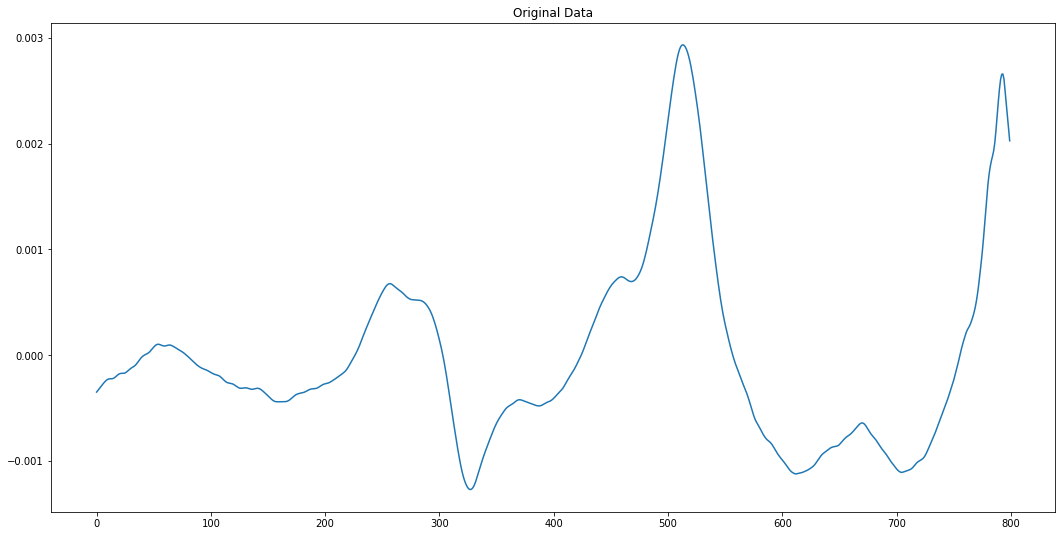

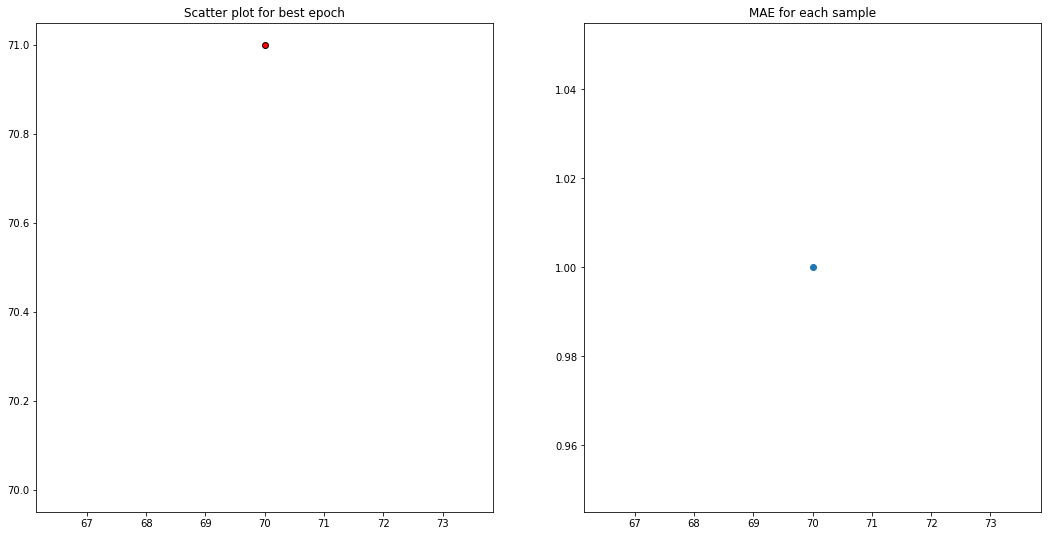

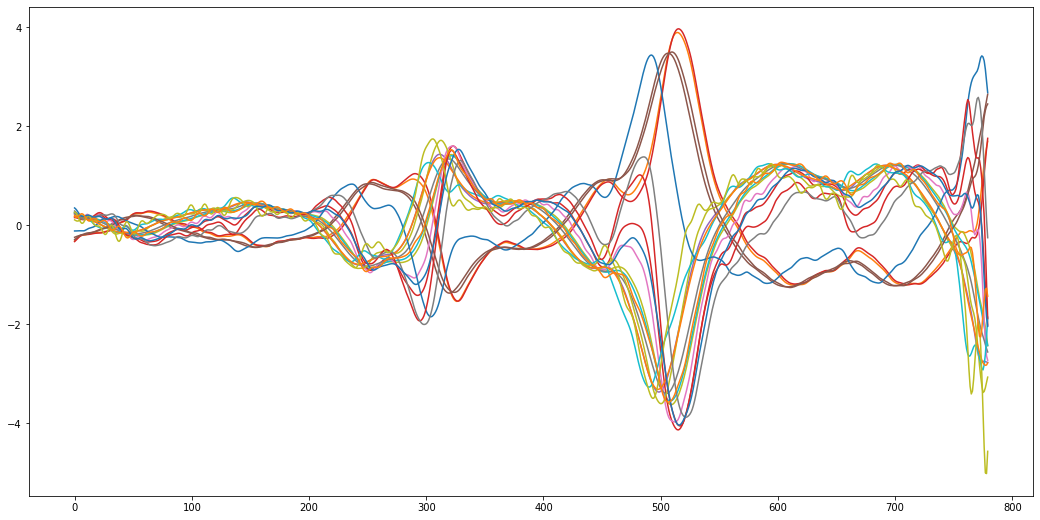

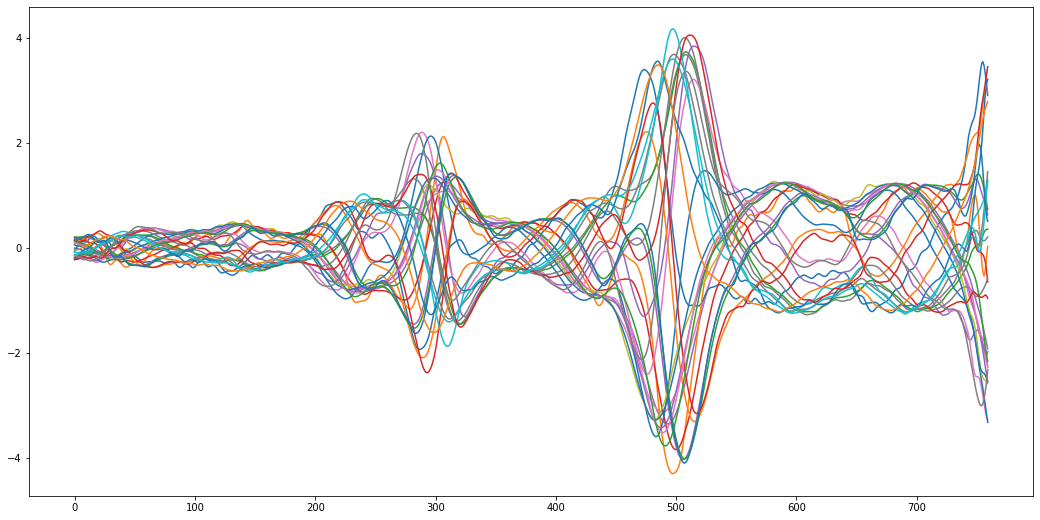

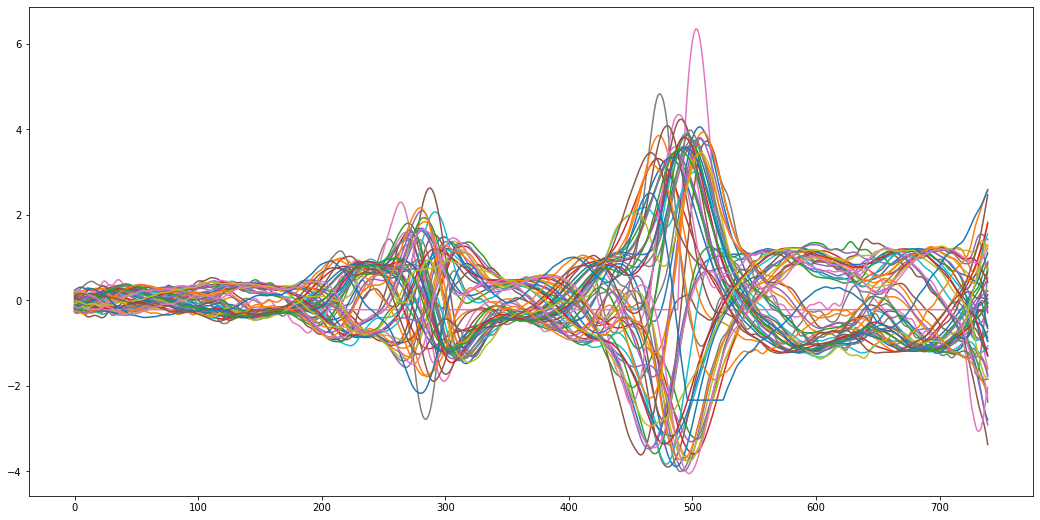

In [77]:
import numpy as np
import pandas as pd
import random
import torch
import sys
from torch import nn
from torch import optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from datetime import datetime
import matplotlib.pyplot as plt
import sklearn.metrics
#from google.colab import files
import io
from scipy import signal as sg
from scipy.signal import savgol_filter
from torch.autograd import Function
from scipy.stats import chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from scipy.ndimage import convolve1d
from scipy.signal.windows import triang
from scipy.ndimage import gaussian_filter1d
import torch.nn.functional as F
import sys

# pynvml import *

b_size = 32 #batch size
np.random.seed(100)

# the 1DCNN model on Asta for regression with added ANN layer and 0.00001 learning rate and with SNV preprocessing with Huberloss and adam optimizer with changed window length =11, polyorder = 2
class D1CNN(nn.Module):
    def __init__(self):
        super(D1CNN,self).__init__()
        self.features = nn.Sequential()
        self.features.add_module('1_conv1d',nn.Conv1d(in_channels=1,out_channels=32,kernel_size=21))
        self.features.add_module('1_relu',nn.ReLU())            
        self.features.add_module('1_batchnorm',nn.BatchNorm1d(32))
        self.features.add_module('1_maxpool',nn.MaxPool1d(kernel_size=2))
    
        self.features.add_module('2_conv1d',nn.Conv1d(in_channels=32,out_channels=64,kernel_size=21))
        self.features.add_module('2_relu',nn.ReLU())
        self.features.add_module('2_batchnorm',nn.BatchNorm1d(64))
        self.features.add_module('2_maxpool',nn.MaxPool1d(kernel_size=3))

        self.features.add_module('3_conv1d',nn.Conv1d(in_channels=64,out_channels=128,kernel_size=21))
        self.features.add_module('3_relu',nn.ReLU())
        self.features.add_module('3_batchnorm',nn.BatchNorm1d(128))
        self.features.add_module('3_maxpool',nn.MaxPool1d(kernel_size=3))

        self.features.add_module('4_conv1d',nn.Conv1d(in_channels=128,out_channels=256,kernel_size=21))
        self.features.add_module('4_relu',nn.ReLU())
        self.features.add_module('4_batchnorm',nn.BatchNorm1d(256))
        self.features.add_module('4_maxpool',nn.MaxPool1d(kernel_size=3))
        
        self.features.add_module('drop_1',nn.Dropout(p=0.4))
    
        self.regress = nn.Sequential()
        self.regress.add_module('an_1',nn.Linear(1024,512))
        self.regress.add_module('an_Relu_1',nn.ReLU())
        self.regress.add_module('an_drop_1',nn.Dropout(p=0.2))
        self.regress.add_module('an_2',nn.Linear(512,512))
        self.regress.add_module('an_Relu_2',nn.ReLU())
        self.regress.add_module('an_drop_2',nn.Dropout(p=0.2))
        self.regress.add_module('an_3',nn.Linear(512,128))
        self.regress.add_module('an_Relu_3',nn.ReLU())
        self.regress.add_module('an_drop_3',nn.Dropout(p=0.2))
        self.regress.add_module('an_4',nn.Linear(128,128))
        self.regress.add_module('an_Relu_4',nn.ReLU())
        self.regress.add_module('an_drop_4',nn.Dropout(p=0.2))
        self.regress.add_module('an_5',nn.Linear(128,64))
        self.regress.add_module('an_Relu_5',nn.ReLU())
        self.regress.add_module('an_drop_5',nn.Dropout(p=0.2))
        self.regress.add_module('an_6',nn.Linear(64,1))

    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x,start_dim=1)
        x_out = self.regress(x)
        return x_out

# preprocessing functions
def moving_smoothing(input_array, window_length):

    m_rows = len(range(window_length, input_array.shape[1] - window_length))
    m_cols = 2*window_length
    matrix = np.zeros((m_rows,m_cols),dtype=int)
    for j in range(0, len(matrix)):
        k = j+1
        matrix[j] = [x for x in range(k,k+2*window_length)]
    #Smoothing spectra using matrix operations:
    n_cols = m_rows
    newspectra = np.zeros((len(input_array),n_cols))
    for i in range(len(matrix)):
        newspectra[:,i] = np.mean(input_array[: ,matrix[i]],axis=1)
    #Add front and end tails (not smoothed):
    #new_spectra = np.asarray(newspectra)
    fronttail = newspectra[:,:1]
    endtail = newspectra[:,-1:]
    for k in range(1,window_length):
        fronttail=np.append(fronttail,newspectra[:,:1], axis=1)
        endtail = np.append(endtail,newspectra[:,-1:], axis =1)
    data = np.concatenate((fronttail, newspectra, endtail), axis=1)
    return data

def derivate_first(input_array, window_length, polyorder):
    der1 = savgol_filter(input_array, window_length, polyorder,deriv = 1)
    return der1

def MSC(input_array, reference = None):
    ''' Perform Multiplicative scatter correction'''

    #Mean correction
    for i in range(input_array.shape[0]):
        input_array[i,:] -= input_array[i,:].mean()

    # Get the reference spectrum. If not given, estimate from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_array, axis=0)
    else:
        ref = reference

    # Define a new data matrix and populate it with the corrected data    
    output_data = np.zeros_like(input_array)
    for i in range(input_array.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_array[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_array[i,:] - fit[0][1]) / fit[0][0] 
    #print(fit)
    return output_data

def detrending(input_array):
    X = np.arange(input_array.shape[1])
    base = np.zeros((len(input_array),len(X)))
    for i in range(len(input_array)):
        c = np.polyfit(X, input_array[i], 2)
        base[i] = np.polyval(c, X)
    #Baseline removal
    base_remove = input_array - base
    return base_remove

def savitzky(input_array, window_length, polyorder):
    savgol = savgol_filter(input_array, window_length, polyorder)
    return savgol

def weighted_l1_loss(inputs, targets, weights=None):
    '''You need to correct this'''
    loss = F.l1_loss(inputs, targets, reduction='none')
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

def data_1D(f):
    sed = 100
    d_asta = pd.read_csv(f,encoding='utf-8')
    d_asta = d_asta.loc[:, ~d_asta.columns.str.contains('^Unnamed')]
    #col = [str(x) for x in range(0,151)]+[str(x) for x in range(751,801)]+['Sample ID','Cap']
    #col = ['Sample ID','Cap','800']
    #d_asta = df.drop(columns=col)
    #d_asta = d_asta.dropna(subset=['ASTA'])
    #d_asta['ASTA'] = d_asta['ASTA'].round()
    #d_asta = d_asta[d_asta['ASTA']>=50]
    #d_asta = d_asta[d_asta['ASTA']<120]

    X_val = np.array(d_asta.drop(columns = ['ASTA']))
    Y_val = np.array(d_asta['ASTA'])

    X_val = savitzky(X_val,11,2)
    X_val = MSC(X_val)
    X_val = detrending(X_val)
    X_val = derivate_first(X_val,11,2)


    return X_val[30],Y_val[30]

def run():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print('using'+device+'device')
    man_seed = 100
    torch.manual_seed(man_seed)
    model = D1CNN()
    model.load_state_dict(torch.load('model_asta_40_120_lds_dataaug_5_20220309_182454_659.pth',map_location = torch.device(device)))
    model.to(device)
    '''if float 64 is allowed then you can go with that too'''
    model.to(torch.float32)
    loss = weighted_l1_loss
    file_name = 'test_chili_asta.csv'
    x_val,y_val = data_1D(file_name)
    fig_1 = plt.figure(figsize =(18,9))
    ax = fig_1.add_subplot(1,1,1)
    ax.plot(x_val.transpose())
    ax.title.set_text('Original Data')
    model.eval()
    
    with torch.no_grad():

        v_x_dt = torch.from_numpy(x_val)
        v_x_dt = torch.unsqueeze(v_x_dt,dim=0)
        v_x_dt = torch.unsqueeze(v_x_dt,dim=0)
        
        v_x_dt = Variable(v_x_dt,requires_grad=False).to(device,dtype = torch.float32)
        print(v_x_dt.shape)
        v_y_dt = torch.from_numpy(np.array(y_val))
        v_y_dt = Variable(v_y_dt,requires_grad = False).to(device,dtype = torch.float32)
        v_yhat = model.forward(v_x_dt)
        v_yhat = torch.squeeze(v_yhat)
        v_yhat = torch.round(v_yhat)
        v_loss = loss(v_yhat,v_y_dt).item()

        b_yhat = v_yhat.to('cpu')
        b_y_t_1 = v_y_dt.to('cpu')
        #r2_score = sklearn.metrics.r2_score(b_y_t_1,b_yhat)
        
    
        v_x_dt.detach()
        v_y_dt.detach()
        v_yhat.detach()
        
    print("\n the MAE is %.4f\n"%(v_loss)),#r2_score))
    
    ttt = abs(b_yhat - b_y_t_1)
    
    
    fig_4 = plt.figure(figsize =(18,9))
    ax4 = fig_4.add_subplot(1,2,1)
    ax5 = fig_4.add_subplot(1,2,2)
    ax4.title.set_text('Scatter plot for best epoch')
    ax5.title.set_text('MAE for each sample')
    ax5.plot(b_y_t_1,ttt,marker ='o',linestyle='')
    ax4.scatter(b_y_t_1,b_yhat,c='red',edgecolors='k')
    ax4.plot(b_y_t_1,b_y_t_1,c='blue',linewidth = 1)
    fig_4.show()
    
    model_weights =[]
    conv_layers = []
    relu_layers = []

    model_children = list(model.children())
    counter = 0

    #print(model_children)

    for i in range(len(model_children)):        

        if type(model_children[i])==nn.Sequential:
            t = list(model_children[i].children())
            for i in range(len(t)):
                if type(t[i]) == nn.Conv1d:
                    counter +=1
                    model_weights.append(t[i].weight)
                    conv_layers.append(t[i])
                    
                    if type(t[i+1]) == nn.ReLU:
                        relu_layers.append(t[i+1])
    
    print(f" Total convolution layers:{counter}")
    print("Conv_layers")
    
    test_x = v_x_dt
    outputs =[]
    names = []
    for i in range(len(conv_layers)):
        test_x = conv_layers[i](test_x)
        test_x = relu_layers[i](test_x)
        outputs.append(test_x)
        names.append(str(conv_layers[i]))
    
    for feature_map in outputs:
        feature_map = feature_map.squeeze(0)
        print(feature_map.shape)
        fig = plt.figure(figsize=(18,9))
        for i in range(feature_map.shape[0]):
            ss = feature_map[i].data.cpu().numpy()
            ss -= ss.mean()
            ss /= ss.std()
            plt.plot(ss)
        
    #print(np.array(outputs).shape)

    """prcess= []
    for feature_map in outputs:
        feature_map = feature_map.squeeze(0)
        
        
        
        
        
        feature_map = feature_map.squeeze(0)
        gray_scale = torch.sum(feature_map,0)
        gray_scale = gray_scale/feature_map.shape[0]
        prcess.append(gray_scale.data.cpu().numpy())

    fig = plt.figure(figsize=(72, 36))
    for i in range(len(prcess)):
        a = fig.add_subplot(4, 2, 2*(i+1))
        imgplot = plt.plot(prcess[i])
        #a.axis("off")
        a.set_title(names[i].split('(')[0]+'layer'+str(i+1), fontsize=10)
        a_2 = fig.add_subplot(4, 2, (2*i)+1)
        plt.plot(x_val.transpose())
        #a.axis("off")
        a_2.set_title('input spectra', fontsize=0)
        
    
    plt.show()"""
    #plt.savefig(str('feature_maps_asta.jpg'), bbox_inches='tight')
        
        
    
    #y_data = pd.DataFrame()
    #y_data['actual'] = b_y_t_1
    #y_data['predcted'] = b_yhat
    #y_data.to_csv('chili_val_test_data.csv')
    
if __name__ == '__main__':
    run()

## Testing on a slight different test and train data , Almost same

### testing the training set accuracy

usingcpudevice
torch.Size([740, 1, 800])

 the MAE is 5.0419


 the r2score is 0.8842



C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/3990005123.py:239: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_4.show()


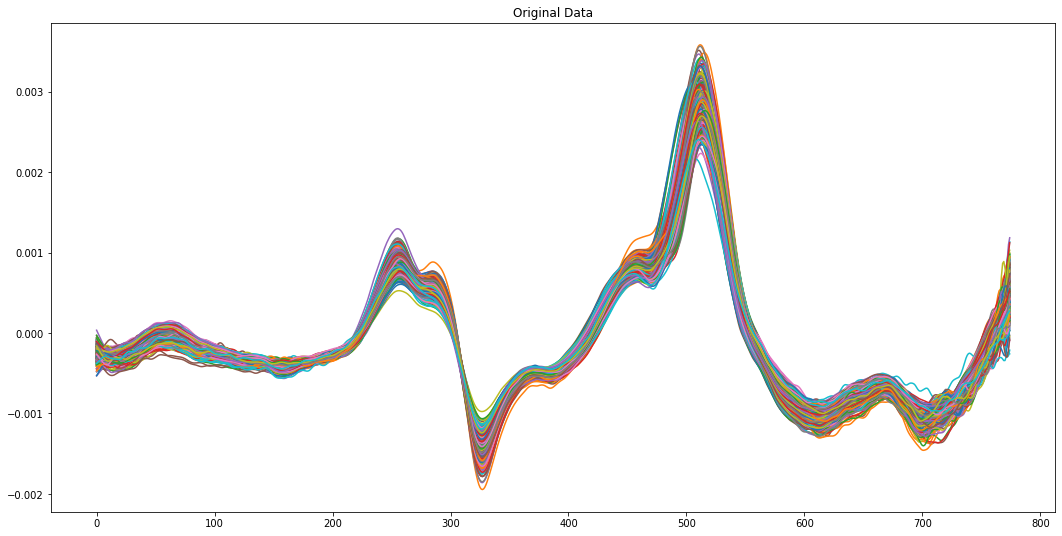

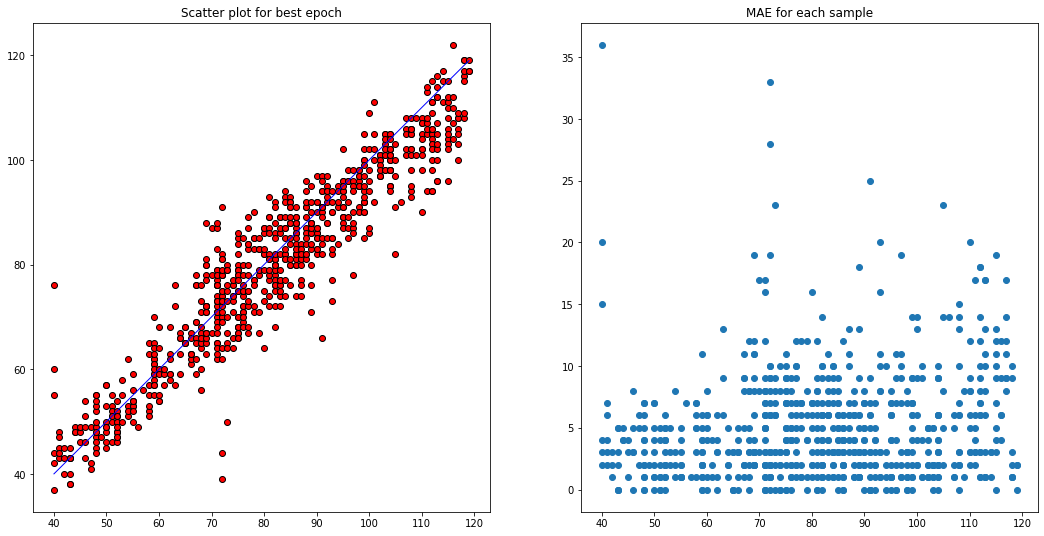

In [25]:
import numpy as np
import pandas as pd
import random
import torch
import sys
from torch import nn
from torch import optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from datetime import datetime
import matplotlib.pyplot as plt
import sklearn.metrics
#from google.colab import files
import io
from scipy import signal as sg
from scipy.signal import savgol_filter
from torch.autograd import Function
from scipy.stats import chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from scipy.ndimage import convolve1d
from scipy.signal.windows import triang
from scipy.ndimage import gaussian_filter1d
import torch.nn.functional as F
import sys

# pynvml import *

b_size = 32 #batch size
np.random.seed(100)

# the 1DCNN model on Asta for regression with added ANN layer and 0.00001 learning rate and with SNV preprocessing with Huberloss and adam optimizer with changed window length =11, polyorder = 2
class D1CNN(nn.Module):
    def __init__(self):
        super(D1CNN,self).__init__()
        self.features = nn.Sequential()
        self.features.add_module('1_conv1d',nn.Conv1d(in_channels=1,out_channels=32,kernel_size=21))
        self.features.add_module('1_relu',nn.ReLU())            
        self.features.add_module('1_batchnorm',nn.BatchNorm1d(32))
        self.features.add_module('1_maxpool',nn.MaxPool1d(kernel_size=2))
    
        self.features.add_module('2_conv1d',nn.Conv1d(in_channels=32,out_channels=64,kernel_size=21))
        self.features.add_module('2_relu',nn.ReLU())
        self.features.add_module('2_batchnorm',nn.BatchNorm1d(64))
        self.features.add_module('2_maxpool',nn.MaxPool1d(kernel_size=3))

        self.features.add_module('3_conv1d',nn.Conv1d(in_channels=64,out_channels=128,kernel_size=21))
        self.features.add_module('3_relu',nn.ReLU())
        self.features.add_module('3_batchnorm',nn.BatchNorm1d(128))
        self.features.add_module('3_maxpool',nn.MaxPool1d(kernel_size=3))

        self.features.add_module('4_conv1d',nn.Conv1d(in_channels=128,out_channels=256,kernel_size=21))
        self.features.add_module('4_relu',nn.ReLU())
        self.features.add_module('4_batchnorm',nn.BatchNorm1d(256))
        self.features.add_module('4_maxpool',nn.MaxPool1d(kernel_size=3))
        
        self.features.add_module('drop_1',nn.Dropout(p=0.4))
    
        self.regress = nn.Sequential()
        self.regress.add_module('an_1',nn.Linear(1024,512))
        self.regress.add_module('an_Relu_1',nn.ReLU())
        self.regress.add_module('an_drop_1',nn.Dropout(p=0.2))
        self.regress.add_module('an_2',nn.Linear(512,512))
        self.regress.add_module('an_Relu_2',nn.ReLU())
        self.regress.add_module('an_drop_2',nn.Dropout(p=0.2))
        self.regress.add_module('an_3',nn.Linear(512,128))
        self.regress.add_module('an_Relu_3',nn.ReLU())
        self.regress.add_module('an_drop_3',nn.Dropout(p=0.2))
        self.regress.add_module('an_4',nn.Linear(128,128))
        self.regress.add_module('an_Relu_4',nn.ReLU())
        self.regress.add_module('an_drop_4',nn.Dropout(p=0.2))
        self.regress.add_module('an_5',nn.Linear(128,64))
        self.regress.add_module('an_Relu_5',nn.ReLU())
        self.regress.add_module('an_drop_5',nn.Dropout(p=0.2))
        self.regress.add_module('an_6',nn.Linear(64,1))

    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x,start_dim=1)
        x_out = self.regress(x)
        return x_out

# preprocessing functions
def moving_smoothing(input_array, window_length):

    m_rows = len(range(window_length, input_array.shape[1] - window_length))
    m_cols = 2*window_length
    matrix = np.zeros((m_rows,m_cols),dtype=int)
    for j in range(0, len(matrix)):
        k = j+1
        matrix[j] = [x for x in range(k,k+2*window_length)]
    #Smoothing spectra using matrix operations:
    n_cols = m_rows
    newspectra = np.zeros((len(input_array),n_cols))
    for i in range(len(matrix)):
        newspectra[:,i] = np.mean(input_array[: ,matrix[i]],axis=1)
    #Add front and end tails (not smoothed):
    #new_spectra = np.asarray(newspectra)
    fronttail = newspectra[:,:1]
    endtail = newspectra[:,-1:]
    for k in range(1,window_length):
        fronttail=np.append(fronttail,newspectra[:,:1], axis=1)
        endtail = np.append(endtail,newspectra[:,-1:], axis =1)
    data = np.concatenate((fronttail, newspectra, endtail), axis=1)
    return data

def derivate_first(input_array, window_length, polyorder):
    der1 = savgol_filter(input_array, window_length, polyorder,deriv = 1)
    return der1

def MSC(input_array, reference = None):
    ''' Perform Multiplicative scatter correction'''

    #Mean correction
    for i in range(input_array.shape[0]):
        input_array[i,:] -= input_array[i,:].mean()

    # Get the reference spectrum. If not given, estimate from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_array, axis=0)
    else:
        ref = reference

    # Define a new data matrix and populate it with the corrected data    
    output_data = np.zeros_like(input_array)
    for i in range(input_array.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_array[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_array[i,:] - fit[0][1]) / fit[0][0] 
    #print(fit)
    return output_data

def detrending(input_array):
    X = np.arange(input_array.shape[1])
    base = np.zeros((len(input_array),len(X)))
    for i in range(len(input_array)):
        c = np.polyfit(X, input_array[i], 2)
        base[i] = np.polyval(c, X)
    #Baseline removal
    base_remove = input_array - base
    return base_remove

def savitzky(input_array, window_length, polyorder):
    savgol = savgol_filter(input_array, window_length, polyorder)
    return savgol

def weighted_l1_loss(inputs, targets, weights=None):
    '''You need to correct this'''
    loss = F.l1_loss(inputs, targets, reduction='none')
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

def data_1D(f):
    sed = 100
    d_asta = pd.read_csv(f,encoding='utf-8')
    d_asta = d_asta.loc[:, ~d_asta.columns.str.contains('^Unnamed')]
    #col = [str(x) for x in range(0,151)]+[str(x) for x in range(751,801)]+['Sample ID','Cap']
    #col = ['Sample ID','Cap','800']
    #d_asta = df.drop(columns=col)
    #d_asta = d_asta.dropna(subset=['ASTA'])
    #d_asta['ASTA'] = d_asta['ASTA'].round()
    #d_asta = d_asta[d_asta['ASTA']>=50]
    #d_asta = d_asta[d_asta['ASTA']<120]

    X_val = np.array(d_asta.drop(columns = ['ASTA']))
    Y_val = np.array(d_asta['ASTA'])

    X_val = savitzky(X_val,11,2)
    X_val = MSC(X_val)
    X_val = detrending(X_val)
    X_val = derivate_first(X_val,11,2)


    return X_val,Y_val

def run():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print('using'+device+'device')
    man_seed = 100
    torch.manual_seed(man_seed)
    model = D1CNN()
    model.load_state_dict(torch.load('model_asta_40_120_lds_dataaug_5_20220309_182454_659.pth',map_location = torch.device(device)))
    model.to(device)
    '''if float 64 is allowed then you can go with that too'''
    model.to(torch.float32)
    loss = weighted_l1_loss
    file_name = 'train_aug_test.csv'
    x_val,y_val = data_1D(file_name)
    fig_1 = plt.figure(figsize =(18,9))
    ax = fig_1.add_subplot(1,1,1)
    ax.plot(x_val[:,0:775].transpose())
    ax.title.set_text('Original Data')
    model.eval()
    
    with torch.no_grad():

        v_x_dt = torch.from_numpy(x_val)
        v_x_dt = torch.unsqueeze(v_x_dt,dim=1)
        #v_x_dt = torch.unsqueeze(v_x_dt,dim=0)
        
        v_x_dt = Variable(v_x_dt,requires_grad=False).to(device,dtype = torch.float32)
        print(v_x_dt.shape)
        v_y_dt = torch.from_numpy(np.array(y_val))
        v_y_dt = Variable(v_y_dt,requires_grad = False).to(device,dtype = torch.float32)
        v_yhat = model.forward(v_x_dt)
        v_yhat = torch.squeeze(v_yhat)
        v_yhat = torch.round(v_yhat)
        v_loss = loss(v_yhat,v_y_dt).item()

        b_yhat = v_yhat.to('cpu')
        b_y_t_1 = v_y_dt.to('cpu')
        r2_score = sklearn.metrics.r2_score(b_y_t_1,b_yhat)
        
    
        v_x_dt.detach()
        v_y_dt.detach()
        v_yhat.detach()
        
    print("\n the MAE is %.4f\n"%(v_loss)),#r2_score))
    print("\n the r2score is %.4f\n"%(r2_score)),#r2_score))
    
    ttt = abs(b_yhat - b_y_t_1)
    
    
    fig_4 = plt.figure(figsize =(18,9))
    ax4 = fig_4.add_subplot(1,2,1)
    ax5 = fig_4.add_subplot(1,2,2)
    ax4.title.set_text('Scatter plot for best epoch')
    ax5.title.set_text('MAE for each sample')
    ax5.plot(b_y_t_1,ttt,marker ='o',linestyle='')
    ax4.scatter(b_y_t_1,b_yhat,c='red',edgecolors='k')
    ax4.plot(b_y_t_1,b_y_t_1,c='blue',linewidth = 1)
    fig_4.show()
    
if __name__ == '__main__':
    run()

## testing on a kind of unseen dataset

usingcpudevice
torch.Size([80, 1, 800])

 the MAE is 8.3000


 the r2_score is 0.7994



C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/1264438395.py:239: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_4.show()


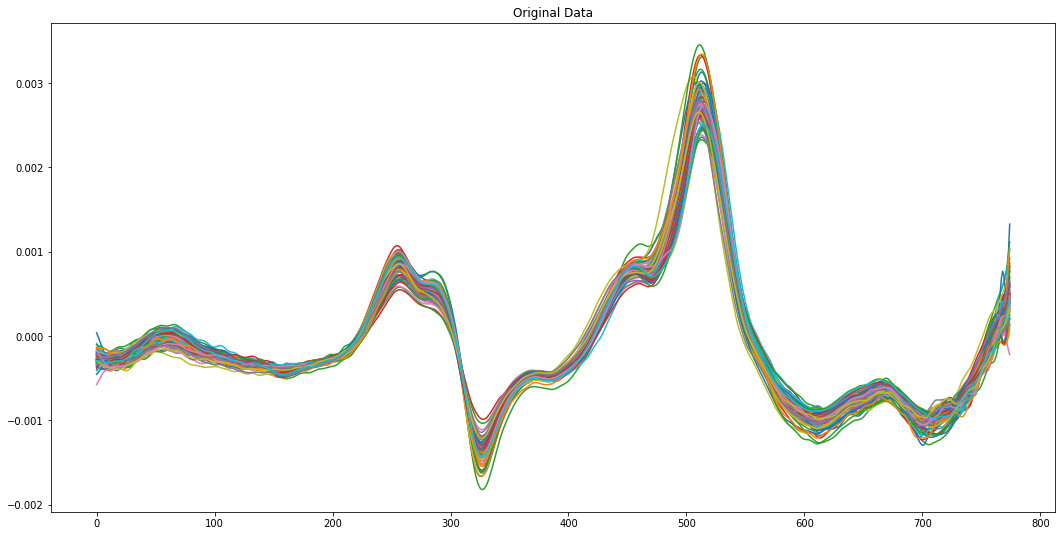

In [26]:
import numpy as np
import pandas as pd
import random
import torch
import sys
from torch import nn
from torch import optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from datetime import datetime
import matplotlib.pyplot as plt
import sklearn.metrics
#from google.colab import files
import io
from scipy import signal as sg
from scipy.signal import savgol_filter
from torch.autograd import Function
from scipy.stats import chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from scipy.ndimage import convolve1d
from scipy.signal.windows import triang
from scipy.ndimage import gaussian_filter1d
import torch.nn.functional as F
import sys

# pynvml import *

b_size = 32 #batch size
np.random.seed(100)

# the 1DCNN model on Asta for regression with added ANN layer and 0.00001 learning rate and with SNV preprocessing with Huberloss and adam optimizer with changed window length =11, polyorder = 2
class D1CNN(nn.Module):
    def __init__(self):
        super(D1CNN,self).__init__()
        self.features = nn.Sequential()
        self.features.add_module('1_conv1d',nn.Conv1d(in_channels=1,out_channels=32,kernel_size=21))
        self.features.add_module('1_relu',nn.ReLU())            
        self.features.add_module('1_batchnorm',nn.BatchNorm1d(32))
        self.features.add_module('1_maxpool',nn.MaxPool1d(kernel_size=2))
    
        self.features.add_module('2_conv1d',nn.Conv1d(in_channels=32,out_channels=64,kernel_size=21))
        self.features.add_module('2_relu',nn.ReLU())
        self.features.add_module('2_batchnorm',nn.BatchNorm1d(64))
        self.features.add_module('2_maxpool',nn.MaxPool1d(kernel_size=3))

        self.features.add_module('3_conv1d',nn.Conv1d(in_channels=64,out_channels=128,kernel_size=21))
        self.features.add_module('3_relu',nn.ReLU())
        self.features.add_module('3_batchnorm',nn.BatchNorm1d(128))
        self.features.add_module('3_maxpool',nn.MaxPool1d(kernel_size=3))

        self.features.add_module('4_conv1d',nn.Conv1d(in_channels=128,out_channels=256,kernel_size=21))
        self.features.add_module('4_relu',nn.ReLU())
        self.features.add_module('4_batchnorm',nn.BatchNorm1d(256))
        self.features.add_module('4_maxpool',nn.MaxPool1d(kernel_size=3))
        
        self.features.add_module('drop_1',nn.Dropout(p=0.4))
    
        self.regress = nn.Sequential()
        self.regress.add_module('an_1',nn.Linear(1024,512))
        self.regress.add_module('an_Relu_1',nn.ReLU())
        self.regress.add_module('an_drop_1',nn.Dropout(p=0.2))
        self.regress.add_module('an_2',nn.Linear(512,512))
        self.regress.add_module('an_Relu_2',nn.ReLU())
        self.regress.add_module('an_drop_2',nn.Dropout(p=0.2))
        self.regress.add_module('an_3',nn.Linear(512,128))
        self.regress.add_module('an_Relu_3',nn.ReLU())
        self.regress.add_module('an_drop_3',nn.Dropout(p=0.2))
        self.regress.add_module('an_4',nn.Linear(128,128))
        self.regress.add_module('an_Relu_4',nn.ReLU())
        self.regress.add_module('an_drop_4',nn.Dropout(p=0.2))
        self.regress.add_module('an_5',nn.Linear(128,64))
        self.regress.add_module('an_Relu_5',nn.ReLU())
        self.regress.add_module('an_drop_5',nn.Dropout(p=0.2))
        self.regress.add_module('an_6',nn.Linear(64,1))

    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x,start_dim=1)
        x_out = self.regress(x)
        return x_out

# preprocessing functions
def moving_smoothing(input_array, window_length):

    m_rows = len(range(window_length, input_array.shape[1] - window_length))
    m_cols = 2*window_length
    matrix = np.zeros((m_rows,m_cols),dtype=int)
    for j in range(0, len(matrix)):
        k = j+1
        matrix[j] = [x for x in range(k,k+2*window_length)]
    #Smoothing spectra using matrix operations:
    n_cols = m_rows
    newspectra = np.zeros((len(input_array),n_cols))
    for i in range(len(matrix)):
        newspectra[:,i] = np.mean(input_array[: ,matrix[i]],axis=1)
    #Add front and end tails (not smoothed):
    #new_spectra = np.asarray(newspectra)
    fronttail = newspectra[:,:1]
    endtail = newspectra[:,-1:]
    for k in range(1,window_length):
        fronttail=np.append(fronttail,newspectra[:,:1], axis=1)
        endtail = np.append(endtail,newspectra[:,-1:], axis =1)
    data = np.concatenate((fronttail, newspectra, endtail), axis=1)
    return data

def derivate_first(input_array, window_length, polyorder):
    der1 = savgol_filter(input_array, window_length, polyorder,deriv = 1)
    return der1

def MSC(input_array, reference = None):
    ''' Perform Multiplicative scatter correction'''

    #Mean correction
    for i in range(input_array.shape[0]):
        input_array[i,:] -= input_array[i,:].mean()

    # Get the reference spectrum. If not given, estimate from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_array, axis=0)
    else:
        ref = reference

    # Define a new data matrix and populate it with the corrected data    
    output_data = np.zeros_like(input_array)
    for i in range(input_array.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_array[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_array[i,:] - fit[0][1]) / fit[0][0] 
    #print(fit)
    return output_data

def detrending(input_array):
    X = np.arange(input_array.shape[1])
    base = np.zeros((len(input_array),len(X)))
    for i in range(len(input_array)):
        c = np.polyfit(X, input_array[i], 2)
        base[i] = np.polyval(c, X)
    #Baseline removal
    base_remove = input_array - base
    return base_remove

def savitzky(input_array, window_length, polyorder):
    savgol = savgol_filter(input_array, window_length, polyorder)
    return savgol

def weighted_l1_loss(inputs, targets, weights=None):
    '''You need to correct this'''
    loss = F.l1_loss(inputs, targets, reduction='none')
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

def data_1D(f):
    sed = 100
    d_asta = pd.read_csv(f,encoding='utf-8')
    d_asta = d_asta.loc[:, ~d_asta.columns.str.contains('^Unnamed')]
    #col = [str(x) for x in range(0,151)]+[str(x) for x in range(751,801)]+['Sample ID','Cap']
    #col = ['Sample ID','Cap','800']
    #d_asta = df.drop(columns=col)
    #d_asta = d_asta.dropna(subset=['ASTA'])
    #d_asta['ASTA'] = d_asta['ASTA'].round()
    #d_asta = d_asta[d_asta['ASTA']>=50]
    #d_asta = d_asta[d_asta['ASTA']<120]

    X_val = np.array(d_asta.drop(columns = ['ASTA']))
    Y_val = np.array(d_asta['ASTA'])

    X_val = savitzky(X_val,11,2)
    X_val = MSC(X_val)
    X_val = detrending(X_val)
    X_val = derivate_first(X_val,11,2)


    return X_val,Y_val

def run():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print('using'+device+'device')
    man_seed = 100
    torch.manual_seed(man_seed)
    model = D1CNN()
    model.load_state_dict(torch.load('model_asta_40_120_lds_dataaug_5_20220309_182454_659.pth',map_location = torch.device(device)))
    model.to(device)
    '''if float 64 is allowed then you can go with that too'''
    model.to(torch.float32)
    loss = weighted_l1_loss
    file_name = 'test_aug_test.csv'
    x_val,y_val = data_1D(file_name)
    fig_1 = plt.figure(figsize =(18,9))
    ax = fig_1.add_subplot(1,1,1)
    ax.plot(x_val[:,0:775].transpose())
    ax.title.set_text('Original Data')
    model.eval()
    
    with torch.no_grad():

        v_x_dt = torch.from_numpy(x_val)
        v_x_dt = torch.unsqueeze(v_x_dt,dim=1)
        #v_x_dt = torch.unsqueeze(v_x_dt,dim=0)
        
        v_x_dt = Variable(v_x_dt,requires_grad=False).to(device,dtype = torch.float32)
        print(v_x_dt.shape)
        v_y_dt = torch.from_numpy(np.array(y_val))
        v_y_dt = Variable(v_y_dt,requires_grad = False).to(device,dtype = torch.float32)
        v_yhat = model.forward(v_x_dt)
        v_yhat = torch.squeeze(v_yhat)
        v_yhat = torch.round(v_yhat)
        v_loss = loss(v_yhat,v_y_dt).item()

        b_yhat = v_yhat.to('cpu')
        b_y_t_1 = v_y_dt.to('cpu')
        r2_score = sklearn.metrics.r2_score(b_y_t_1,b_yhat)
        
    
        v_x_dt.detach()
        v_y_dt.detach()
        v_yhat.detach()
        
    print("\n the MAE is %.4f\n"%(v_loss)),#r2_score))
    print("\n the r2_score is %.4f\n"%(r2_score)),#r2_score))
    
    ttt = abs(b_yhat - b_y_t_1)
    
    
    fig_4 = plt.figure(figsize =(18,9))
    ax4 = fig_4.add_subplot(1,2,1)
    ax5 = fig_4.add_subplot(1,2,2)
    ax4.title.set_text('Scatter plot for best epoch')
    ax5.title.set_text('MAE for each sample')
    ax5.plot(b_y_t_1,ttt,marker ='o',linestyle='')
    ax4.scatter(b_y_t_1,b_yhat,c='red',edgecolors='k')
    ax4.plot(b_y_t_1,b_y_t_1,c='blue',linewidth = 1)
    fig_4.show()
    
if __name__ == '__main__':
    run()

### testing on the training set with augmented data

usingcpudevice
torch.Size([18500, 1, 800])

 the MAE is 35.1765



C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/2942779793.py:263: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_4.show()


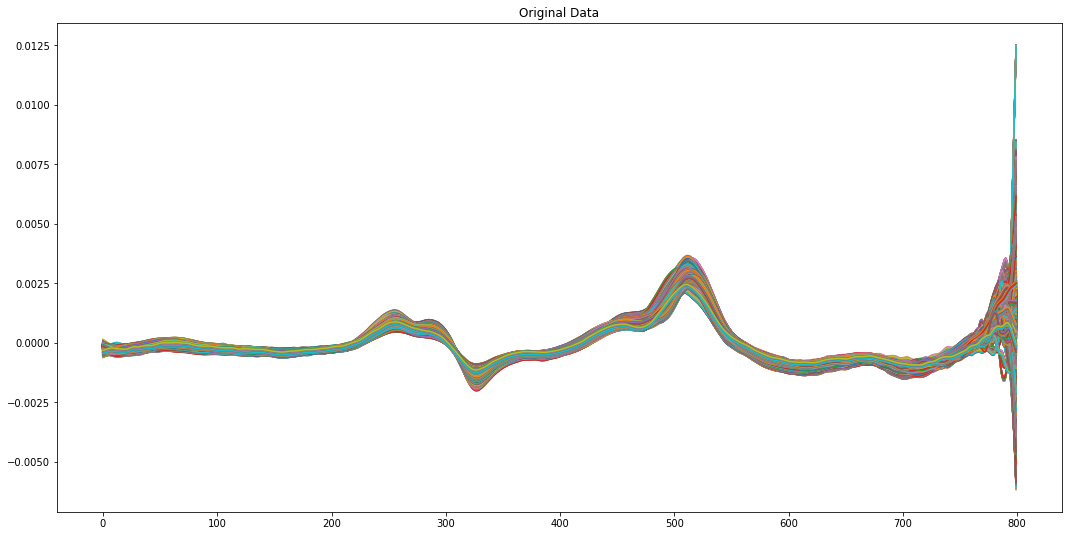

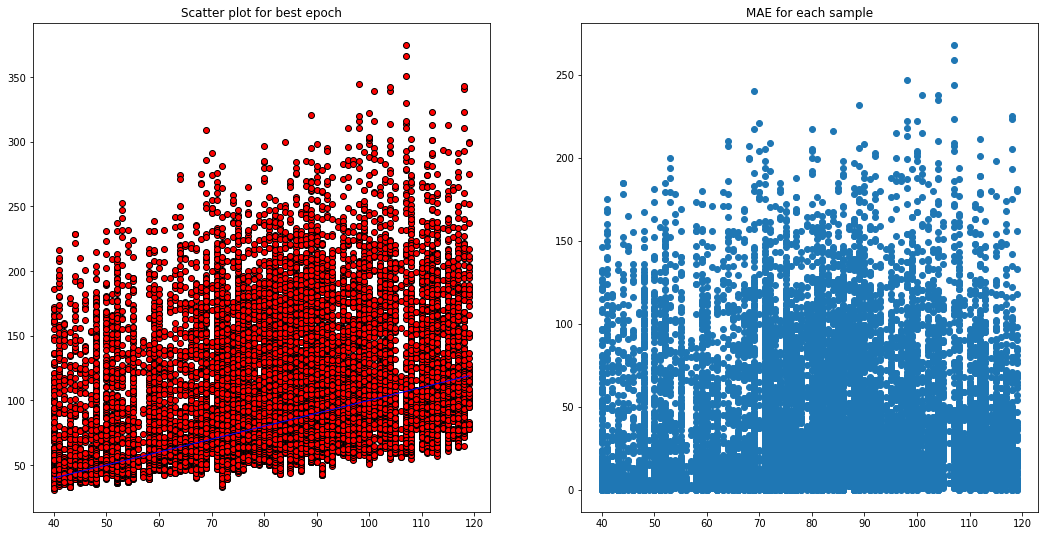

In [22]:
import numpy as np
import pandas as pd
import random
import torch
import sys
from torch import nn
from torch import optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from datetime import datetime
import matplotlib.pyplot as plt
import sklearn.metrics
#from google.colab import files
import io
from scipy import signal as sg
from scipy.signal import savgol_filter
from torch.autograd import Function
from scipy.stats import chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from scipy.ndimage import convolve1d
from scipy.signal.windows import triang
from scipy.ndimage import gaussian_filter1d
import torch.nn.functional as F
import sys

# pynvml import *

b_size = 32 #batch size
np.random.seed(100)

# the 1DCNN model on Asta for regression with added ANN layer and 0.00001 learning rate and with SNV preprocessing with Huberloss and adam optimizer with changed window length =11, polyorder = 2
class D1CNN(nn.Module):
    def __init__(self):
        super(D1CNN,self).__init__()
        self.features = nn.Sequential()
        self.features.add_module('1_conv1d',nn.Conv1d(in_channels=1,out_channels=32,kernel_size=21))
        self.features.add_module('1_relu',nn.ReLU())            
        self.features.add_module('1_batchnorm',nn.BatchNorm1d(32))
        self.features.add_module('1_maxpool',nn.MaxPool1d(kernel_size=2))
    
        self.features.add_module('2_conv1d',nn.Conv1d(in_channels=32,out_channels=64,kernel_size=21))
        self.features.add_module('2_relu',nn.ReLU())
        self.features.add_module('2_batchnorm',nn.BatchNorm1d(64))
        self.features.add_module('2_maxpool',nn.MaxPool1d(kernel_size=3))

        self.features.add_module('3_conv1d',nn.Conv1d(in_channels=64,out_channels=128,kernel_size=21))
        self.features.add_module('3_relu',nn.ReLU())
        self.features.add_module('3_batchnorm',nn.BatchNorm1d(128))
        self.features.add_module('3_maxpool',nn.MaxPool1d(kernel_size=3))

        self.features.add_module('4_conv1d',nn.Conv1d(in_channels=128,out_channels=256,kernel_size=21))
        self.features.add_module('4_relu',nn.ReLU())
        self.features.add_module('4_batchnorm',nn.BatchNorm1d(256))
        self.features.add_module('4_maxpool',nn.MaxPool1d(kernel_size=3))
        
        self.features.add_module('drop_1',nn.Dropout(p=0.4))
    
        self.regress = nn.Sequential()
        self.regress.add_module('an_1',nn.Linear(1024,512))
        self.regress.add_module('an_Relu_1',nn.ReLU())
        self.regress.add_module('an_drop_1',nn.Dropout(p=0.2))
        self.regress.add_module('an_2',nn.Linear(512,512))
        self.regress.add_module('an_Relu_2',nn.ReLU())
        self.regress.add_module('an_drop_2',nn.Dropout(p=0.2))
        self.regress.add_module('an_3',nn.Linear(512,128))
        self.regress.add_module('an_Relu_3',nn.ReLU())
        self.regress.add_module('an_drop_3',nn.Dropout(p=0.2))
        self.regress.add_module('an_4',nn.Linear(128,128))
        self.regress.add_module('an_Relu_4',nn.ReLU())
        self.regress.add_module('an_drop_4',nn.Dropout(p=0.2))
        self.regress.add_module('an_5',nn.Linear(128,64))
        self.regress.add_module('an_Relu_5',nn.ReLU())
        self.regress.add_module('an_drop_5',nn.Dropout(p=0.2))
        self.regress.add_module('an_6',nn.Linear(64,1))

    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x,start_dim=1)
        x_out = self.regress(x)
        return x_out

# preprocessing functions
def moving_smoothing(input_array, window_length):

    m_rows = len(range(window_length, input_array.shape[1] - window_length))
    m_cols = 2*window_length
    matrix = np.zeros((m_rows,m_cols),dtype=int)
    for j in range(0, len(matrix)):
        k = j+1
        matrix[j] = [x for x in range(k,k+2*window_length)]
    #Smoothing spectra using matrix operations:
    n_cols = m_rows
    newspectra = np.zeros((len(input_array),n_cols))
    for i in range(len(matrix)):
        newspectra[:,i] = np.mean(input_array[: ,matrix[i]],axis=1)
    #Add front and end tails (not smoothed):
    #new_spectra = np.asarray(newspectra)
    fronttail = newspectra[:,:1]
    endtail = newspectra[:,-1:]
    for k in range(1,window_length):
        fronttail=np.append(fronttail,newspectra[:,:1], axis=1)
        endtail = np.append(endtail,newspectra[:,-1:], axis =1)
    data = np.concatenate((fronttail, newspectra, endtail), axis=1)
    return data

def derivate_first(input_array, window_length, polyorder):
    der1 = savgol_filter(input_array, window_length, polyorder,deriv = 1)
    return der1

def MSC(input_array, reference = None):
    ''' Perform Multiplicative scatter correction'''

    #Mean correction
    for i in range(input_array.shape[0]):
        input_array[i,:] -= input_array[i,:].mean()

    # Get the reference spectrum. If not given, estimate from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_array, axis=0)
    else:
        ref = reference

    # Define a new data matrix and populate it with the corrected data    
    output_data = np.zeros_like(input_array)
    for i in range(input_array.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_array[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_array[i,:] - fit[0][1]) / fit[0][0] 
    #print(fit)
    return output_data

def detrending(input_array):
    X = np.arange(input_array.shape[1])
    base = np.zeros((len(input_array),len(X)))
    for i in range(len(input_array)):
        c = np.polyfit(X, input_array[i], 2)
        base[i] = np.polyval(c, X)
    #Baseline removal
    base_remove = input_array - base
    return base_remove

def savitzky(input_array, window_length, polyorder):
    savgol = savgol_filter(input_array, window_length, polyorder)
    return savgol

def weighted_l1_loss(inputs, targets, weights=None):
    '''You need to correct this'''
    loss = F.l1_loss(inputs, targets, reduction='none')
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

def dataaugment(x, betashift = 0.05, slopeshift = 0.05,multishift = 0.05):
    #Shift of baseline
    #calculate arrays
    beta = np.random.random(size=(x.shape[0],1))*2*betashift-betashift
    slope = np.random.random(size=(x.shape[0],1))*2*slopeshift-slopeshift + 1
    #Calculate relative position
    axis = np.array(range(x.shape[1]))/float(x.shape[1])
    #Calculate offset to be added
    offset = slope*(axis) + beta - axis - slope/2. + 0.5

    #Multiplicative
    multi = np.random.random(size=(x.shape[0],1))*2*multishift-multishift + 1

    x = multi*x + offset

    return x

def data_1D(f):
    sed = 100
    d_asta = pd.read_csv(f,encoding='utf-8')
    d_asta = d_asta.loc[:, ~d_asta.columns.str.contains('^Unnamed')]
    #col = [str(x) for x in range(0,151)]+[str(x) for x in range(751,801)]+['Sample ID','Cap']
    #col = ['Sample ID','Cap','800']
    #d_asta = df.drop(columns=col)
    #d_asta = d_asta.dropna(subset=['ASTA'])
    #d_asta['ASTA'] = d_asta['ASTA'].round()
    #d_asta = d_asta[d_asta['ASTA']>=50]
    #d_asta = d_asta[d_asta['ASTA']<120]

    X_val = np.array(d_asta.drop(columns = ['ASTA']))
    Y_val = np.array(d_asta['ASTA'])

    X_val = savitzky(X_val,11,2)
    X_val = MSC(X_val)
    X_val = detrending(X_val)
    X_val = derivate_first(X_val,11,2)
    
    X_val_aug = np.repeat(X_val,repeats = 24, axis = 0)
    shift = .1*np.std(X_val)
    X_val_aug = dataaugment(X_val_aug,betashift = shift,slopeshift = shift/2,multishift = shift)
    X_val = np.concatenate((X_val,X_val_aug),axis = 0)
    
    Y_val_aug = np.repeat(Y_val,repeats = 24 ,axis = 0)
    Y_val= np.concatenate((Y_val,Y_val_aug),axis = 0)


    return X_val,Y_val

def run():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print('using'+device+'device')
    man_seed = 100
    torch.manual_seed(man_seed)
    model = D1CNN()
    model.load_state_dict(torch.load('model_asta_40_120_lds_dataaug_5_20220309_182454_659.pth',map_location = torch.device(device)))
    model.to(device)
    '''if float 64 is allowed then you can go with that too'''
    model.to(torch.float32)
    loss = weighted_l1_loss
    file_name = 'train_aug_test.csv'
    x_val,y_val = data_1D(file_name)
    fig_1 = plt.figure(figsize =(18,9))
    ax = fig_1.add_subplot(1,1,1)
    ax.plot(x_val[:,0:775].transpose())
    ax.title.set_text('Original Data')
    model.eval()
    
    with torch.no_grad():

        v_x_dt = torch.from_numpy(x_val)
        v_x_dt = torch.unsqueeze(v_x_dt,dim=1)
        #v_x_dt = torch.unsqueeze(v_x_dt,dim=0)
        
        v_x_dt = Variable(v_x_dt,requires_grad=False).to(device,dtype = torch.float32)
        print(v_x_dt.shape)
        v_y_dt = torch.from_numpy(np.array(y_val))
        v_y_dt = Variable(v_y_dt,requires_grad = False).to(device,dtype = torch.float32)
        v_yhat = model.forward(v_x_dt)
        v_yhat = torch.squeeze(v_yhat)
        v_yhat = torch.round(v_yhat)
        v_loss = loss(v_yhat,v_y_dt).item()

        b_yhat = v_yhat.to('cpu')
        b_y_t_1 = v_y_dt.to('cpu')
        #r2_score = sklearn.metrics.r2_score(b_y_t_1,b_yhat)
        
    
        v_x_dt.detach()
        v_y_dt.detach()
        v_yhat.detach()
        
    print("\n the MAE is %.4f\n"%(v_loss)),#r2_score))
    
    ttt = abs(b_yhat - b_y_t_1)
    
    
    fig_4 = plt.figure(figsize =(18,9))
    ax4 = fig_4.add_subplot(1,2,1)
    ax5 = fig_4.add_subplot(1,2,2)
    ax4.title.set_text('Scatter plot for best epoch')
    ax5.title.set_text('MAE for each sample')
    ax5.plot(b_y_t_1,ttt,marker ='o',linestyle='')
    ax4.scatter(b_y_t_1,b_yhat,c='red',edgecolors='k')
    ax4.plot(b_y_t_1,b_y_t_1,c='blue',linewidth = 1)
    fig_4.show()
    
if __name__ == '__main__':
    run()

since not technically the same training set hence showing this many variation in MAE as the data is unseen also model is going out of range which is interesting to look.

#### print conv layers shape to print filter signals

In [62]:
import numpy as np
import pandas as pd
import random
import torch
import sys
from torch import nn
from torch import optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from datetime import datetime
import matplotlib.pyplot as plt
import sklearn.metrics
#from google.colab import files
import io
from scipy import signal as sg
from scipy.signal import savgol_filter
from torch.autograd import Function
from scipy.stats import chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from scipy.ndimage import convolve1d
from scipy.signal.windows import triang
from scipy.ndimage import gaussian_filter1d
import torch.nn.functional as F
import sys

# pynvml import *

b_size = 32 #batch size
np.random.seed(100)

# the 1DCNN model on Asta for regression with added ANN layer and 0.00001 learning rate and with SNV preprocessing with Huberloss and adam optimizer with changed window length =11, polyorder = 2
class D1CNN(nn.Module):
    def __init__(self):
        super(D1CNN,self).__init__()
        self.features = nn.Sequential()
        self.features.add_module('1_conv1d',nn.Conv1d(in_channels=1,out_channels=32,kernel_size=21))
        self.features.add_module('1_relu',nn.ReLU())            
        self.features.add_module('1_batchnorm',nn.BatchNorm1d(32))
        self.features.add_module('1_maxpool',nn.MaxPool1d(kernel_size=2))
    
        self.features.add_module('2_conv1d',nn.Conv1d(in_channels=32,out_channels=64,kernel_size=21))
        self.features.add_module('2_relu',nn.ReLU())
        self.features.add_module('2_batchnorm',nn.BatchNorm1d(64))
        self.features.add_module('2_maxpool',nn.MaxPool1d(kernel_size=3))

        self.features.add_module('3_conv1d',nn.Conv1d(in_channels=64,out_channels=128,kernel_size=21))
        self.features.add_module('3_relu',nn.ReLU())
        self.features.add_module('3_batchnorm',nn.BatchNorm1d(128))
        self.features.add_module('3_maxpool',nn.MaxPool1d(kernel_size=3))

        self.features.add_module('4_conv1d',nn.Conv1d(in_channels=128,out_channels=256,kernel_size=21))
        self.features.add_module('4_relu',nn.ReLU())
        self.features.add_module('4_batchnorm',nn.BatchNorm1d(256))
        self.features.add_module('4_maxpool',nn.MaxPool1d(kernel_size=3))
        
        self.features.add_module('drop_1',nn.Dropout(p=0.4))
    
        self.regress = nn.Sequential()
        self.regress.add_module('an_1',nn.Linear(1024,512))
        self.regress.add_module('an_Relu_1',nn.ReLU())
        self.regress.add_module('an_drop_1',nn.Dropout(p=0.2))
        self.regress.add_module('an_2',nn.Linear(512,512))
        self.regress.add_module('an_Relu_2',nn.ReLU())
        self.regress.add_module('an_drop_2',nn.Dropout(p=0.2))
        self.regress.add_module('an_3',nn.Linear(512,128))
        self.regress.add_module('an_Relu_3',nn.ReLU())
        self.regress.add_module('an_drop_3',nn.Dropout(p=0.2))
        self.regress.add_module('an_4',nn.Linear(128,128))
        self.regress.add_module('an_Relu_4',nn.ReLU())
        self.regress.add_module('an_drop_4',nn.Dropout(p=0.2))
        self.regress.add_module('an_5',nn.Linear(128,64))
        self.regress.add_module('an_Relu_5',nn.ReLU())
        self.regress.add_module('an_drop_5',nn.Dropout(p=0.2))
        self.regress.add_module('an_6',nn.Linear(64,1))

    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x,start_dim=1)
        x_out = self.regress(x)
        return x_out

def run():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print('using'+device+'device')
    man_seed = 100
    torch.manual_seed(man_seed)
    model = D1CNN()
    model.load_state_dict(torch.load('model_asta_40_120_lds_dataaug_5_20220309_182454_659.pth',map_location = torch.device(device)))
    model.to(device)
    '''if float 64 is allowed then you can go with that too'''
    model.to(torch.float32)
    
    model_weights =[]
    conv_layers = []
    relu_weights =[]
    relu_layers = []

    model_children = list(model.children())
    counter = 0

    #print(model_children)

    for i in range(len(model_children)):        

        if type(model_children[i])==nn.Sequential:
            t = list(model_children[i].children())
            for i in range(len(t)):
                if type(t[i]) == nn.Conv1d:
                    counter +=1
                    model_weights.append(t[i].weight)
                    conv_layers.append(t[i])
                    
                    if type(t[i+1]) == nn.ReLU:
                        relu_weights.append(t[i+1])
                        relu_layers.append(t[i+1])
                    
                
    
    print(f" Total convolution layers:{counter}")
    print("Conv_layers")
    print(conv_layers[0].weight.shape)
    print(relu_layers[0])
    print(conv_layers[0,:])
    
    """for feature_map in model_weights:
        feature_map = feature_map.squeeze(0)
        print(feature_map.shape)
        fig = plt.figure(figsize=(18,9))
        for i in range(feature_map.shape[0]):
            ss = feature_map[i].data.cpu().numpy()
            #ss -= ss.mean()
            #ss /= ss.std()
            plt.plot(ss.transpose())
        break"""
    
    """test_x = v_x_dt
    outputs =[]
    names = []
    for layer in conv_layers[0:]:
        test_x = layer(test_x)
        outputs.append(test_x)
        names.append(str(layer))
    
    for feature_map in outputs:
        feature_map = feature_map.squeeze(0)
        print(feature_map.shape)
        fig = plt.figure(figsize=(18,9))
        for i in range(feature_map.shape[0]):
            ss = feature_map[i].data.cpu().numpy()
            ss -= ss.mean()
            ss /= ss.std()
            plt.plot(ss.transpose())
        
    #print(np.array(outputs).shape)"""

    """prcess= []
    for feature_map in outputs:
        feature_map = feature_map.squeeze(0)
        
        
        
        
        
        feature_map = feature_map.squeeze(0)
        gray_scale = torch.sum(feature_map,0)
        gray_scale = gray_scale/feature_map.shape[0]
        prcess.append(gray_scale.data.cpu().numpy())

    fig = plt.figure(figsize=(72, 36))
    for i in range(len(prcess)):
        a = fig.add_subplot(4, 2, 2*(i+1))
        imgplot = plt.plot(prcess[i])
        #a.axis("off")
        a.set_title(names[i].split('(')[0]+'layer'+str(i+1), fontsize=10)
        a_2 = fig.add_subplot(4, 2, (2*i)+1)
        plt.plot(x_val.transpose())
        #a.axis("off")
        a_2.set_title('input spectra', fontsize=0)
        
    
    plt.show()"""
    #plt.savefig(str('feature_maps_asta.jpg'), bbox_inches='tight')
        
        
    
    #y_data = pd.DataFrame()
    #y_data['actual'] = b_y_t_1
    #y_data['predcted'] = b_yhat
    #y_data.to_csv('chili_val_test_data.csv')
    
if __name__ == '__main__':
    run()

usingcpudevice
 Total convolution layers:4
Conv_layers
torch.Size([32, 1, 21])
ReLU()


TypeError: list indices must be integers or slices, not tuple

### testing on training data with this trained model or r2 score = .789 something

usingcpudevice
torch.Size([740, 1, 800])

 the MAE is 6.6419


 the r2score is 0.8200



C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/167018594.py:239: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_4.show()


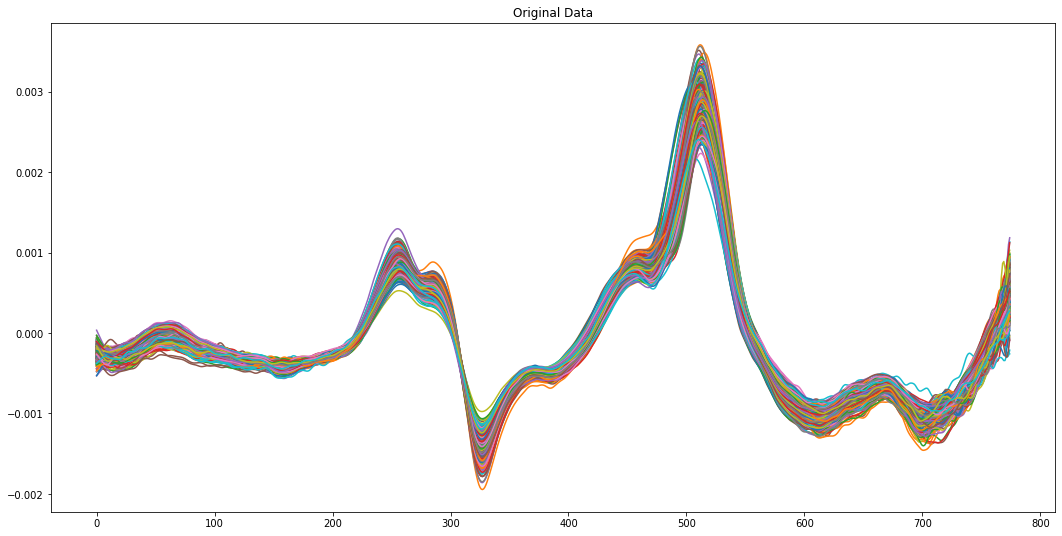

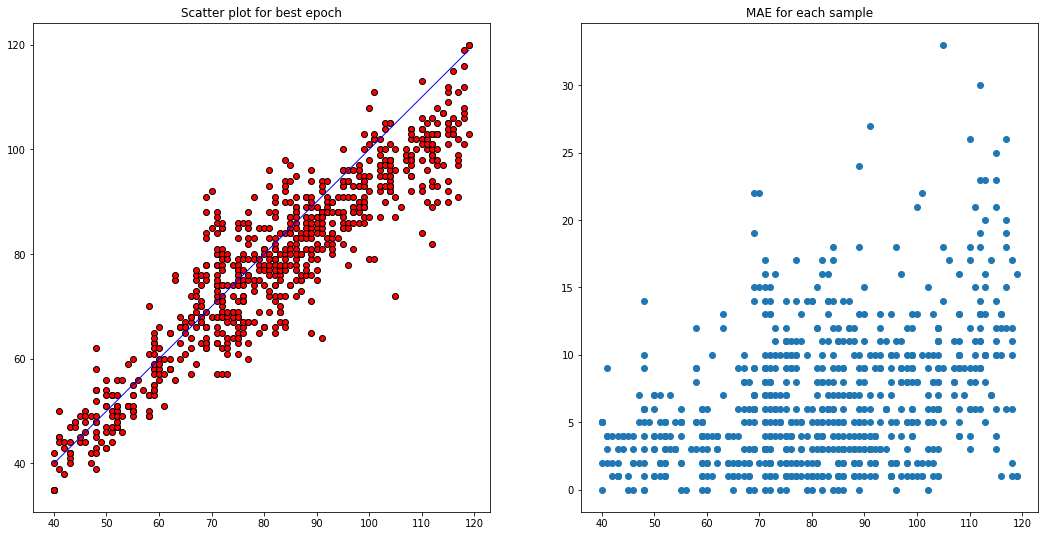

In [48]:
import numpy as np
import pandas as pd
import random
import torch
import sys
from torch import nn
from torch import optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from datetime import datetime
import matplotlib.pyplot as plt
import sklearn.metrics
#from google.colab import files
import io
from scipy import signal as sg
from scipy.signal import savgol_filter
from torch.autograd import Function
from scipy.stats import chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from scipy.ndimage import convolve1d
from scipy.signal.windows import triang
from scipy.ndimage import gaussian_filter1d
import torch.nn.functional as F
import sys

# pynvml import *

b_size = 32 #batch size
np.random.seed(100)

# the 1DCNN model on Asta for regression with added ANN layer and 0.00001 learning rate and with SNV preprocessing with Huberloss and adam optimizer with changed window length =11, polyorder = 2
class D1CNN(nn.Module):
    def __init__(self):
        super(D1CNN,self).__init__()
        self.features = nn.Sequential()
        self.features.add_module('1_conv1d',nn.Conv1d(in_channels=1,out_channels=32,kernel_size=21))
        self.features.add_module('1_relu',nn.ReLU())            
        self.features.add_module('1_batchnorm',nn.BatchNorm1d(32))
        self.features.add_module('1_maxpool',nn.MaxPool1d(kernel_size=2))
    
        self.features.add_module('2_conv1d',nn.Conv1d(in_channels=32,out_channels=64,kernel_size=21))
        self.features.add_module('2_relu',nn.ReLU())
        self.features.add_module('2_batchnorm',nn.BatchNorm1d(64))
        self.features.add_module('2_maxpool',nn.MaxPool1d(kernel_size=3))

        self.features.add_module('3_conv1d',nn.Conv1d(in_channels=64,out_channels=128,kernel_size=21))
        self.features.add_module('3_relu',nn.ReLU())
        self.features.add_module('3_batchnorm',nn.BatchNorm1d(128))
        self.features.add_module('3_maxpool',nn.MaxPool1d(kernel_size=3))

        self.features.add_module('4_conv1d',nn.Conv1d(in_channels=128,out_channels=256,kernel_size=21))
        self.features.add_module('4_relu',nn.ReLU())
        self.features.add_module('4_batchnorm',nn.BatchNorm1d(256))
        self.features.add_module('4_maxpool',nn.MaxPool1d(kernel_size=3))
        
        self.features.add_module('drop_1',nn.Dropout(p=0.4))
    
        self.regress = nn.Sequential()
        self.regress.add_module('an_1',nn.Linear(1024,512))
        self.regress.add_module('an_Relu_1',nn.ReLU())
        self.regress.add_module('an_drop_1',nn.Dropout(p=0.2))
        self.regress.add_module('an_2',nn.Linear(512,512))
        self.regress.add_module('an_Relu_2',nn.ReLU())
        self.regress.add_module('an_drop_2',nn.Dropout(p=0.2))
        self.regress.add_module('an_3',nn.Linear(512,128))
        self.regress.add_module('an_Relu_3',nn.ReLU())
        self.regress.add_module('an_drop_3',nn.Dropout(p=0.2))
        self.regress.add_module('an_4',nn.Linear(128,128))
        self.regress.add_module('an_Relu_4',nn.ReLU())
        self.regress.add_module('an_drop_4',nn.Dropout(p=0.2))
        self.regress.add_module('an_5',nn.Linear(128,64))
        self.regress.add_module('an_Relu_5',nn.ReLU())
        self.regress.add_module('an_drop_5',nn.Dropout(p=0.2))
        self.regress.add_module('an_6',nn.Linear(64,1))

    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x,start_dim=1)
        x_out = self.regress(x)
        return x_out

# preprocessing functions
def moving_smoothing(input_array, window_length):

    m_rows = len(range(window_length, input_array.shape[1] - window_length))
    m_cols = 2*window_length
    matrix = np.zeros((m_rows,m_cols),dtype=int)
    for j in range(0, len(matrix)):
        k = j+1
        matrix[j] = [x for x in range(k,k+2*window_length)]
    #Smoothing spectra using matrix operations:
    n_cols = m_rows
    newspectra = np.zeros((len(input_array),n_cols))
    for i in range(len(matrix)):
        newspectra[:,i] = np.mean(input_array[: ,matrix[i]],axis=1)
    #Add front and end tails (not smoothed):
    #new_spectra = np.asarray(newspectra)
    fronttail = newspectra[:,:1]
    endtail = newspectra[:,-1:]
    for k in range(1,window_length):
        fronttail=np.append(fronttail,newspectra[:,:1], axis=1)
        endtail = np.append(endtail,newspectra[:,-1:], axis =1)
    data = np.concatenate((fronttail, newspectra, endtail), axis=1)
    return data

def derivate_first(input_array, window_length, polyorder):
    der1 = savgol_filter(input_array, window_length, polyorder,deriv = 1)
    return der1

def MSC(input_array, reference = None):
    ''' Perform Multiplicative scatter correction'''

    #Mean correction
    for i in range(input_array.shape[0]):
        input_array[i,:] -= input_array[i,:].mean()

    # Get the reference spectrum. If not given, estimate from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_array, axis=0)
    else:
        ref = reference

    # Define a new data matrix and populate it with the corrected data    
    output_data = np.zeros_like(input_array)
    for i in range(input_array.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_array[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_array[i,:] - fit[0][1]) / fit[0][0] 
    #print(fit)
    return output_data

def detrending(input_array):
    X = np.arange(input_array.shape[1])
    base = np.zeros((len(input_array),len(X)))
    for i in range(len(input_array)):
        c = np.polyfit(X, input_array[i], 2)
        base[i] = np.polyval(c, X)
    #Baseline removal
    base_remove = input_array - base
    return base_remove

def savitzky(input_array, window_length, polyorder):
    savgol = savgol_filter(input_array, window_length, polyorder)
    return savgol

def weighted_l1_loss(inputs, targets, weights=None):
    '''You need to correct this'''
    loss = F.l1_loss(inputs, targets, reduction='none')
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

def data_1D(f):
    sed = 100
    d_asta = pd.read_csv(f,encoding='utf-8')
    d_asta = d_asta.loc[:, ~d_asta.columns.str.contains('^Unnamed')]
    #col = [str(x) for x in range(0,151)]+[str(x) for x in range(751,801)]+['Sample ID','Cap']
    #col = ['Sample ID','Cap','800']
    #d_asta = df.drop(columns=col)
    #d_asta = d_asta.dropna(subset=['ASTA'])
    #d_asta['ASTA'] = d_asta['ASTA'].round()
    #d_asta = d_asta[d_asta['ASTA']>=50]
    #d_asta = d_asta[d_asta['ASTA']<120]

    X_val = np.array(d_asta.drop(columns = ['ASTA']))
    Y_val = np.array(d_asta['ASTA'])

    X_val = savitzky(X_val,11,2)
    X_val = MSC(X_val)
    X_val = detrending(X_val)
    X_val = derivate_first(X_val,11,2)


    return X_val,Y_val

def run():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print('using'+device+'device')
    man_seed = 100
    torch.manual_seed(man_seed)
    model = D1CNN()
    model.load_state_dict(torch.load('model_asta_40_120_lds_dataaug_7_20220311_115112_476.pth',map_location = torch.device(device)))
    model.to(device)
    '''if float 64 is allowed then you can go with that too'''
    model.to(torch.float32)
    loss = weighted_l1_loss
    file_name = 'train_aug_test.csv'
    x_val,y_val = data_1D(file_name)
    fig_1 = plt.figure(figsize =(18,9))
    ax = fig_1.add_subplot(1,1,1)
    ax.plot(x_val[:,0:775].transpose())
    ax.title.set_text('Original Data')
    model.eval()
    
    with torch.no_grad():

        v_x_dt = torch.from_numpy(x_val)
        v_x_dt = torch.unsqueeze(v_x_dt,dim=1)
        #v_x_dt = torch.unsqueeze(v_x_dt,dim=0)
        
        v_x_dt = Variable(v_x_dt,requires_grad=False).to(device,dtype = torch.float32)
        print(v_x_dt.shape)
        v_y_dt = torch.from_numpy(np.array(y_val))
        v_y_dt = Variable(v_y_dt,requires_grad = False).to(device,dtype = torch.float32)
        v_yhat = model.forward(v_x_dt)
        v_yhat = torch.squeeze(v_yhat)
        v_yhat = torch.round(v_yhat)
        v_loss = loss(v_yhat,v_y_dt).item()

        b_yhat = v_yhat.to('cpu')
        b_y_t_1 = v_y_dt.to('cpu')
        r2_score = sklearn.metrics.r2_score(b_y_t_1,b_yhat)
        
    
        v_x_dt.detach()
        v_y_dt.detach()
        v_yhat.detach()
        
    print("\n the MAE is %.4f\n"%(v_loss)),#r2_score))
    print("\n the r2score is %.4f\n"%(r2_score)),#r2_score))
    
    ttt = abs(b_yhat - b_y_t_1)
    
    
    fig_4 = plt.figure(figsize =(18,9))
    ax4 = fig_4.add_subplot(1,2,1)
    ax5 = fig_4.add_subplot(1,2,2)
    ax4.title.set_text('Scatter plot for best epoch')
    ax5.title.set_text('MAE for each sample')
    ax5.plot(b_y_t_1,ttt,marker ='o',linestyle='')
    ax4.scatter(b_y_t_1,b_yhat,c='red',edgecolors='k')
    ax4.plot(b_y_t_1,b_y_t_1,c='blue',linewidth = 1)
    fig_4.show()
    
if __name__ == '__main__':
    run()

### testing on above mentioned model on unseen dataset

usingcpudevice
torch.Size([80, 1, 800])

 the MAE is 8.3500


 the r2score is 0.7845



C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/2492943519.py:239: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_4.show()


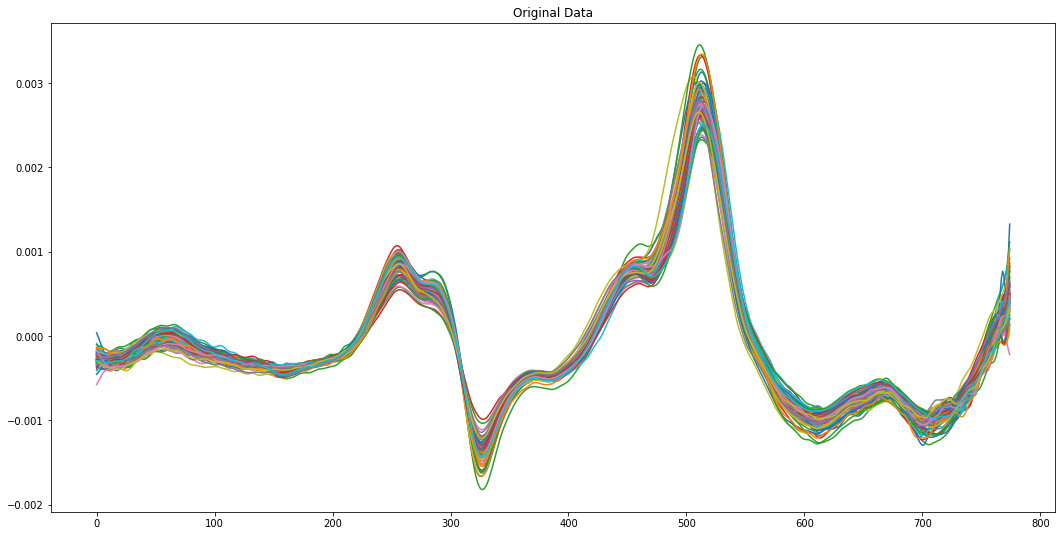

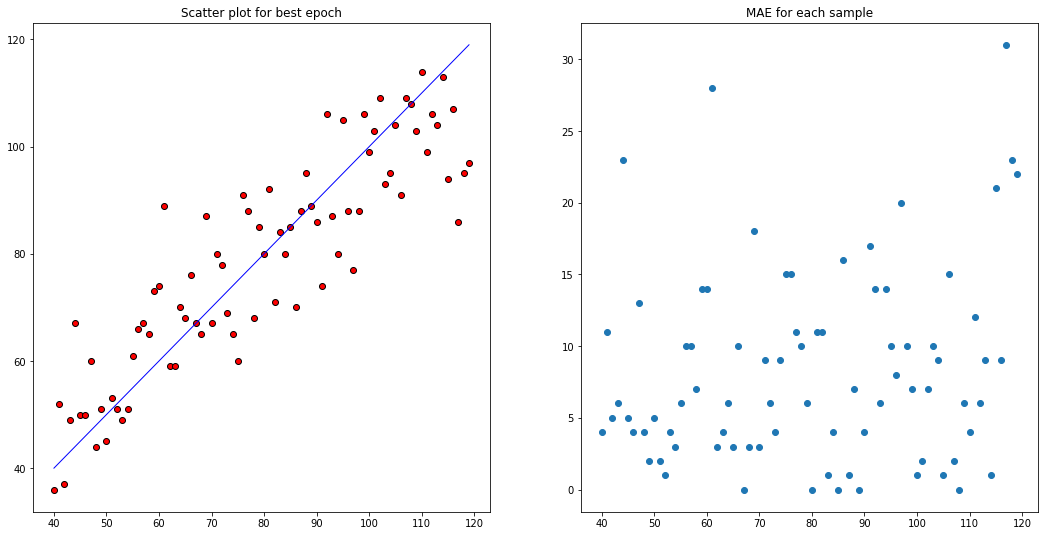

In [50]:
import numpy as np
import pandas as pd
import random
import torch
import sys
from torch import nn
from torch import optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from datetime import datetime
import matplotlib.pyplot as plt
import sklearn.metrics
#from google.colab import files
import io
from scipy import signal as sg
from scipy.signal import savgol_filter
from torch.autograd import Function
from scipy.stats import chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from scipy.ndimage import convolve1d
from scipy.signal.windows import triang
from scipy.ndimage import gaussian_filter1d
import torch.nn.functional as F
import sys

# pynvml import *

b_size = 32 #batch size
np.random.seed(100)

# the 1DCNN model on Asta for regression with added ANN layer and 0.00001 learning rate and with SNV preprocessing with Huberloss and adam optimizer with changed window length =11, polyorder = 2
class D1CNN(nn.Module):
    def __init__(self):
        super(D1CNN,self).__init__()
        self.features = nn.Sequential()
        self.features.add_module('1_conv1d',nn.Conv1d(in_channels=1,out_channels=32,kernel_size=21))
        self.features.add_module('1_relu',nn.ReLU())            
        self.features.add_module('1_batchnorm',nn.BatchNorm1d(32))
        self.features.add_module('1_maxpool',nn.MaxPool1d(kernel_size=2))
    
        self.features.add_module('2_conv1d',nn.Conv1d(in_channels=32,out_channels=64,kernel_size=21))
        self.features.add_module('2_relu',nn.ReLU())
        self.features.add_module('2_batchnorm',nn.BatchNorm1d(64))
        self.features.add_module('2_maxpool',nn.MaxPool1d(kernel_size=3))

        self.features.add_module('3_conv1d',nn.Conv1d(in_channels=64,out_channels=128,kernel_size=21))
        self.features.add_module('3_relu',nn.ReLU())
        self.features.add_module('3_batchnorm',nn.BatchNorm1d(128))
        self.features.add_module('3_maxpool',nn.MaxPool1d(kernel_size=3))

        self.features.add_module('4_conv1d',nn.Conv1d(in_channels=128,out_channels=256,kernel_size=21))
        self.features.add_module('4_relu',nn.ReLU())
        self.features.add_module('4_batchnorm',nn.BatchNorm1d(256))
        self.features.add_module('4_maxpool',nn.MaxPool1d(kernel_size=3))
        
        self.features.add_module('drop_1',nn.Dropout(p=0.4))
    
        self.regress = nn.Sequential()
        self.regress.add_module('an_1',nn.Linear(1024,512))
        self.regress.add_module('an_Relu_1',nn.ReLU())
        self.regress.add_module('an_drop_1',nn.Dropout(p=0.2))
        self.regress.add_module('an_2',nn.Linear(512,512))
        self.regress.add_module('an_Relu_2',nn.ReLU())
        self.regress.add_module('an_drop_2',nn.Dropout(p=0.2))
        self.regress.add_module('an_3',nn.Linear(512,128))
        self.regress.add_module('an_Relu_3',nn.ReLU())
        self.regress.add_module('an_drop_3',nn.Dropout(p=0.2))
        self.regress.add_module('an_4',nn.Linear(128,128))
        self.regress.add_module('an_Relu_4',nn.ReLU())
        self.regress.add_module('an_drop_4',nn.Dropout(p=0.2))
        self.regress.add_module('an_5',nn.Linear(128,64))
        self.regress.add_module('an_Relu_5',nn.ReLU())
        self.regress.add_module('an_drop_5',nn.Dropout(p=0.2))
        self.regress.add_module('an_6',nn.Linear(64,1))

    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x,start_dim=1)
        x_out = self.regress(x)
        return x_out

# preprocessing functions
def moving_smoothing(input_array, window_length):

    m_rows = len(range(window_length, input_array.shape[1] - window_length))
    m_cols = 2*window_length
    matrix = np.zeros((m_rows,m_cols),dtype=int)
    for j in range(0, len(matrix)):
        k = j+1
        matrix[j] = [x for x in range(k,k+2*window_length)]
    #Smoothing spectra using matrix operations:
    n_cols = m_rows
    newspectra = np.zeros((len(input_array),n_cols))
    for i in range(len(matrix)):
        newspectra[:,i] = np.mean(input_array[: ,matrix[i]],axis=1)
    #Add front and end tails (not smoothed):
    #new_spectra = np.asarray(newspectra)
    fronttail = newspectra[:,:1]
    endtail = newspectra[:,-1:]
    for k in range(1,window_length):
        fronttail=np.append(fronttail,newspectra[:,:1], axis=1)
        endtail = np.append(endtail,newspectra[:,-1:], axis =1)
    data = np.concatenate((fronttail, newspectra, endtail), axis=1)
    return data

def derivate_first(input_array, window_length, polyorder):
    der1 = savgol_filter(input_array, window_length, polyorder,deriv = 1)
    return der1

def MSC(input_array, reference = None):
    ''' Perform Multiplicative scatter correction'''

    #Mean correction
    for i in range(input_array.shape[0]):
        input_array[i,:] -= input_array[i,:].mean()

    # Get the reference spectrum. If not given, estimate from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_array, axis=0)
    else:
        ref = reference

    # Define a new data matrix and populate it with the corrected data    
    output_data = np.zeros_like(input_array)
    for i in range(input_array.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_array[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_array[i,:] - fit[0][1]) / fit[0][0] 
    #print(fit)
    return output_data

def detrending(input_array):
    X = np.arange(input_array.shape[1])
    base = np.zeros((len(input_array),len(X)))
    for i in range(len(input_array)):
        c = np.polyfit(X, input_array[i], 2)
        base[i] = np.polyval(c, X)
    #Baseline removal
    base_remove = input_array - base
    return base_remove

def savitzky(input_array, window_length, polyorder):
    savgol = savgol_filter(input_array, window_length, polyorder)
    return savgol

def weighted_l1_loss(inputs, targets, weights=None):
    '''You need to correct this'''
    loss = F.l1_loss(inputs, targets, reduction='none')
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

def data_1D(f):
    sed = 100
    d_asta = pd.read_csv(f,encoding='utf-8')
    d_asta = d_asta.loc[:, ~d_asta.columns.str.contains('^Unnamed')]
    #col = [str(x) for x in range(0,151)]+[str(x) for x in range(751,801)]+['Sample ID','Cap']
    #col = ['Sample ID','Cap','800']
    #d_asta = df.drop(columns=col)
    #d_asta = d_asta.dropna(subset=['ASTA'])
    #d_asta['ASTA'] = d_asta['ASTA'].round()
    #d_asta = d_asta[d_asta['ASTA']>=50]
    #d_asta = d_asta[d_asta['ASTA']<120]

    X_val = np.array(d_asta.drop(columns = ['ASTA']))
    Y_val = np.array(d_asta['ASTA'])

    X_val = savitzky(X_val,11,2)
    X_val = MSC(X_val)
    X_val = detrending(X_val)
    X_val = derivate_first(X_val,11,2)


    return X_val,Y_val

def run():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print('using'+device+'device')
    man_seed = 100
    torch.manual_seed(man_seed)
    model = D1CNN()
    model.load_state_dict(torch.load('model_asta_40_120_lds_dataaug_7_20220311_115112_476.pth',map_location = torch.device(device)))
    model.to(device)
    '''if float 64 is allowed then you can go with that too'''
    model.to(torch.float32)
    loss = weighted_l1_loss
    file_name = 'test_aug_test.csv'
    x_val,y_val = data_1D(file_name)
    fig_1 = plt.figure(figsize =(18,9))
    ax = fig_1.add_subplot(1,1,1)
    ax.plot(x_val[:,0:775].transpose())
    ax.title.set_text('Original Data')
    model.eval()
    
    with torch.no_grad():

        v_x_dt = torch.from_numpy(x_val)
        v_x_dt = torch.unsqueeze(v_x_dt,dim=1)
        #v_x_dt = torch.unsqueeze(v_x_dt,dim=0)
        
        v_x_dt = Variable(v_x_dt,requires_grad=False).to(device,dtype = torch.float32)
        print(v_x_dt.shape)
        v_y_dt = torch.from_numpy(np.array(y_val))
        v_y_dt = Variable(v_y_dt,requires_grad = False).to(device,dtype = torch.float32)
        v_yhat = model.forward(v_x_dt)
        v_yhat = torch.squeeze(v_yhat)
        v_yhat = torch.round(v_yhat)
        v_loss = loss(v_yhat,v_y_dt).item()

        b_yhat = v_yhat.to('cpu')
        b_y_t_1 = v_y_dt.to('cpu')
        r2_score = sklearn.metrics.r2_score(b_y_t_1,b_yhat)
        
    
        v_x_dt.detach()
        v_y_dt.detach()
        v_yhat.detach()
        
    print("\n the MAE is %.4f\n"%(v_loss)),#r2_score))
    print("\n the r2score is %.4f\n"%(r2_score)),#r2_score))
    
    ttt = abs(b_yhat - b_y_t_1)
    
    
    fig_4 = plt.figure(figsize =(18,9))
    ax4 = fig_4.add_subplot(1,2,1)
    ax5 = fig_4.add_subplot(1,2,2)
    ax4.title.set_text('Scatter plot for best epoch')
    ax5.title.set_text('MAE for each sample')
    ax5.plot(b_y_t_1,ttt,marker ='o',linestyle='')
    ax4.scatter(b_y_t_1,b_yhat,c='red',edgecolors='k')
    ax4.plot(b_y_t_1,b_y_t_1,c='blue',linewidth = 1)
    fig_4.show()
    
if __name__ == '__main__':
    run()

##### for a new model with same test and train dataset with r2 score of .806 something

usingcpudevice
torch.Size([740, 1, 800])

 the MAE is 5.1149


 the r2score is 0.8837



C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/3628860066.py:245: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_4.show()


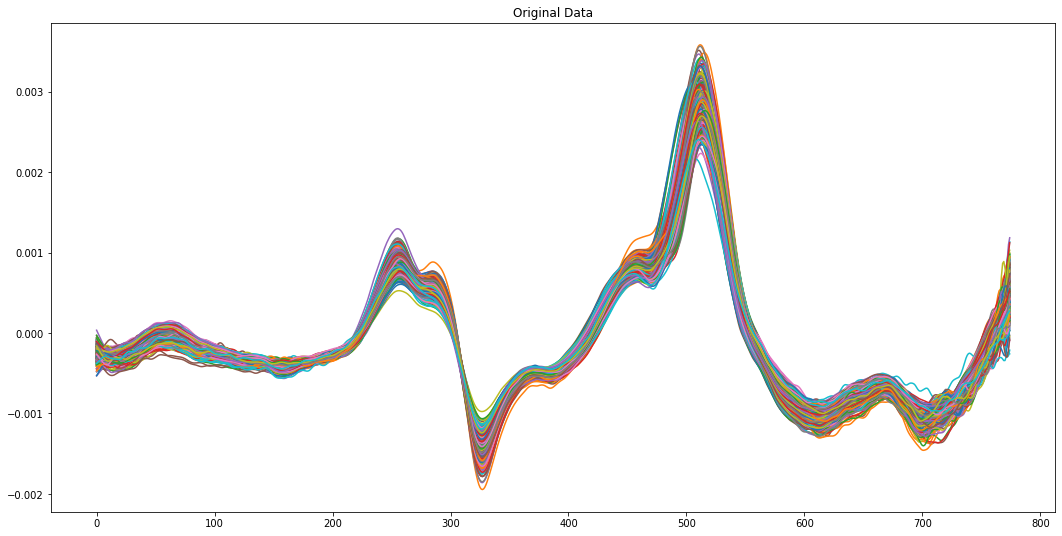

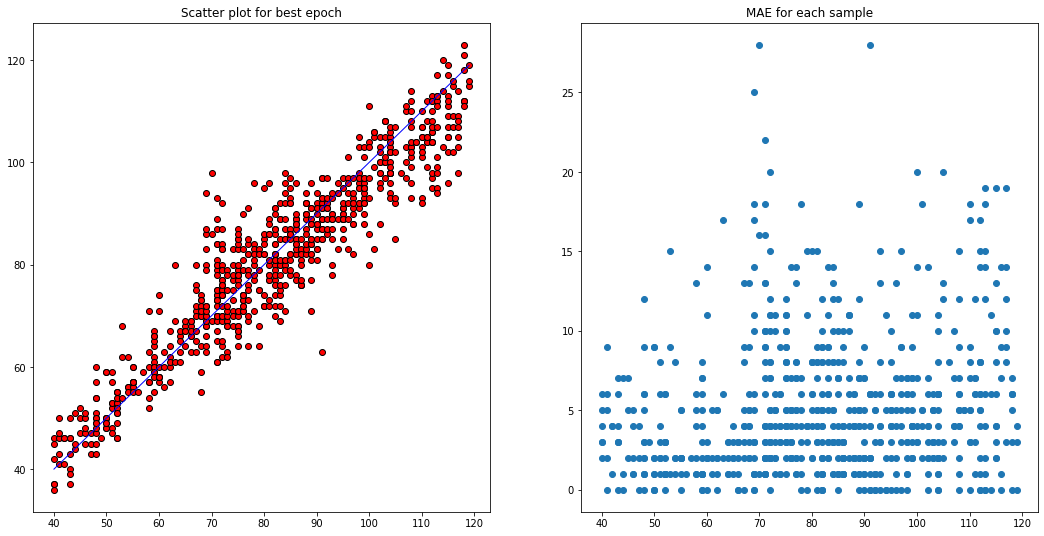

In [86]:
import numpy as np
import pandas as pd
import random
import torch
import sys
from torch import nn
from torch import optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from datetime import datetime
import matplotlib.pyplot as plt
import sklearn.metrics
#from google.colab import files
import io
from scipy import signal as sg
from scipy.signal import savgol_filter
from torch.autograd import Function
from scipy.stats import chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from scipy.ndimage import convolve1d
from scipy.signal.windows import triang
from scipy.ndimage import gaussian_filter1d
import torch.nn.functional as F
import sys

# pynvml import *

b_size = 32 #batch size
np.random.seed(100)

# the 1DCNN model on Asta for regression with added ANN layer and 0.00001 learning rate and with SNV preprocessing with Huberloss and adam optimizer with changed window length =11, polyorder = 2
class D1CNN(nn.Module):
    def __init__(self):
        super(D1CNN,self).__init__()
        self.features = nn.Sequential()
        self.features.add_module('1_conv1d',nn.Conv1d(in_channels=1,out_channels=32,kernel_size=21))
        self.features.add_module('1_relu',nn.ReLU())            
        self.features.add_module('1_batchnorm',nn.BatchNorm1d(32))
        self.features.add_module('1_maxpool',nn.MaxPool1d(kernel_size=2))
    
        self.features.add_module('2_conv1d',nn.Conv1d(in_channels=32,out_channels=64,kernel_size=21))
        self.features.add_module('2_relu',nn.ReLU())
        self.features.add_module('2_batchnorm',nn.BatchNorm1d(64))
        self.features.add_module('2_maxpool',nn.MaxPool1d(kernel_size=3))

        self.features.add_module('3_conv1d',nn.Conv1d(in_channels=64,out_channels=128,kernel_size=21))
        self.features.add_module('3_relu',nn.ReLU())
        self.features.add_module('3_batchnorm',nn.BatchNorm1d(128))
        self.features.add_module('3_maxpool',nn.MaxPool1d(kernel_size=3))

        self.features.add_module('4_conv1d',nn.Conv1d(in_channels=128,out_channels=256,kernel_size=21))
        self.features.add_module('4_relu',nn.ReLU())
        self.features.add_module('4_batchnorm',nn.BatchNorm1d(256))
        self.features.add_module('4_maxpool',nn.MaxPool1d(kernel_size=3))
        
        self.features.add_module('drop_1',nn.Dropout(p=0.4))
    
        self.regress = nn.Sequential()
        self.regress.add_module('an_1',nn.Linear(1024,512))
        self.regress.add_module('an_Relu_1',nn.ReLU())
        self.regress.add_module('an_drop_1',nn.Dropout(p=0.2))
        self.regress.add_module('an_2',nn.Linear(512,512))
        self.regress.add_module('an_Relu_2',nn.ReLU())
        self.regress.add_module('an_drop_2',nn.Dropout(p=0.2))
        self.regress.add_module('an_3',nn.Linear(512,128))
        self.regress.add_module('an_Relu_3',nn.ReLU())
        self.regress.add_module('an_drop_3',nn.Dropout(p=0.2))
        self.regress.add_module('an_4',nn.Linear(128,128))
        self.regress.add_module('an_Relu_4',nn.ReLU())
        self.regress.add_module('an_drop_4',nn.Dropout(p=0.2))
        self.regress.add_module('an_5',nn.Linear(128,64))
        self.regress.add_module('an_Relu_5',nn.ReLU())
        self.regress.add_module('an_drop_5',nn.Dropout(p=0.2))
        self.regress.add_module('an_6',nn.Linear(64,1))

    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x,start_dim=1)
        x_out = self.regress(x)
        return x_out

# preprocessing functions
def moving_smoothing(input_array, window_length):

    m_rows = len(range(window_length, input_array.shape[1] - window_length))
    m_cols = 2*window_length
    matrix = np.zeros((m_rows,m_cols),dtype=int)
    for j in range(0, len(matrix)):
        k = j+1
        matrix[j] = [x for x in range(k,k+2*window_length)]
    #Smoothing spectra using matrix operations:
    n_cols = m_rows
    newspectra = np.zeros((len(input_array),n_cols))
    for i in range(len(matrix)):
        newspectra[:,i] = np.mean(input_array[: ,matrix[i]],axis=1)
    #Add front and end tails (not smoothed):
    #new_spectra = np.asarray(newspectra)
    fronttail = newspectra[:,:1]
    endtail = newspectra[:,-1:]
    for k in range(1,window_length):
        fronttail=np.append(fronttail,newspectra[:,:1], axis=1)
        endtail = np.append(endtail,newspectra[:,-1:], axis =1)
    data = np.concatenate((fronttail, newspectra, endtail), axis=1)
    return data

def derivate_first(input_array, window_length, polyorder):
    der1 = savgol_filter(input_array, window_length, polyorder,deriv = 1)
    return der1

def MSC(input_array, reference = None):
    ''' Perform Multiplicative scatter correction'''

    #Mean correction
    for i in range(input_array.shape[0]):
        input_array[i,:] -= input_array[i,:].mean()

    # Get the reference spectrum. If not given, estimate from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_array, axis=0)
    else:
        ref = reference

    # Define a new data matrix and populate it with the corrected data    
    output_data = np.zeros_like(input_array)
    for i in range(input_array.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_array[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_array[i,:] - fit[0][1]) / fit[0][0] 
    #print(fit)
    return output_data

def detrending(input_array):
    X = np.arange(input_array.shape[1])
    base = np.zeros((len(input_array),len(X)))
    for i in range(len(input_array)):
        c = np.polyfit(X, input_array[i], 2)
        base[i] = np.polyval(c, X)
    #Baseline removal
    base_remove = input_array - base
    return base_remove

def savitzky(input_array, window_length, polyorder):
    savgol = savgol_filter(input_array, window_length, polyorder)
    return savgol

def weighted_l1_loss(inputs, targets, weights=None):
    '''You need to correct this'''
    loss = F.l1_loss(inputs, targets, reduction='none')
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

def data_1D(f):
    sed = 100
    d_asta = pd.read_csv(f,encoding='utf-8')
    d_asta = d_asta.loc[:, ~d_asta.columns.str.contains('^Unnamed')]
    #col = [str(x) for x in range(0,151)]+[str(x) for x in range(751,801)]+['Sample ID','Cap']
    #col = ['Sample ID','Cap','800']
    #d_asta = df.drop(columns=col)
    #d_asta = d_asta.dropna(subset=['ASTA'])
    #d_asta['ASTA'] = d_asta['ASTA'].round()
    #d_asta = d_asta[d_asta['ASTA']>=50]
    #d_asta = d_asta[d_asta['ASTA']<120]

    X_val = np.array(d_asta.drop(columns = ['ASTA']))
    Y_val = np.array(d_asta['ASTA'])

    X_val = savitzky(X_val,11,2)
    X_val = MSC(X_val)
    X_val = detrending(X_val)
    X_val = derivate_first(X_val,11,2)


    return X_val,Y_val

def run():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print('using'+device+'device')
    man_seed = 100
    torch.manual_seed(man_seed)
    model = D1CNN()
    model.load_state_dict(torch.load('model_asta_40_120_lds_dataaug_7_20220311_152247_568.pth',map_location = torch.device(device)))
    model.to(device)
    '''if float 64 is allowed then you can go with that too'''
    model.to(torch.float32)
    loss = weighted_l1_loss
    file_name = 'train_aug_test.csv'
    x_val,y_val = data_1D(file_name)
    fig_1 = plt.figure(figsize =(18,9))
    ax = fig_1.add_subplot(1,1,1)
    ax.plot(x_val[:,0:775].transpose())
    ax.title.set_text('Original Data')
    model.eval()
    
    with torch.no_grad():

        v_x_dt = torch.from_numpy(x_val)
        v_x_dt = torch.unsqueeze(v_x_dt,dim=1)
        #v_x_dt = torch.unsqueeze(v_x_dt,dim=0)
        
        v_x_dt = Variable(v_x_dt,requires_grad=False).to(device,dtype = torch.float32)
        print(v_x_dt.shape)
        v_y_dt = torch.from_numpy(np.array(y_val))
        v_y_dt = Variable(v_y_dt,requires_grad = False).to(device,dtype = torch.float32)
        v_yhat = model.forward(v_x_dt)
        v_yhat = torch.squeeze(v_yhat)
        v_yhat = torch.round(v_yhat)
        v_loss = loss(v_yhat,v_y_dt).item()

        b_yhat = v_yhat.to('cpu')
        b_y_t_1 = v_y_dt.to('cpu')
        r2_score = sklearn.metrics.r2_score(b_y_t_1,b_yhat)
        
    
        v_x_dt.detach()
        v_y_dt.detach()
        v_yhat.detach()
        
    print("\n the MAE is %.4f\n"%(v_loss)),#r2_score))
    print("\n the r2score is %.4f\n"%(r2_score)),#r2_score))
    
    ttt = abs(b_yhat - b_y_t_1)
    
    d_asta = pd.read_csv(file_name,encoding='utf-8')
    d_asta = d_asta.loc[:, ~d_asta.columns.str.contains('^Unnamed')]
    d_asta['actual'] = b_y_t_1
    d_asta['pred'] = b_yhat
    d_asta['AE'] = ttt
    d_asta.to_csv('train_aug_test_asta.csv')
    
    fig_4 = plt.figure(figsize =(18,9))
    ax4 = fig_4.add_subplot(1,2,1)
    ax5 = fig_4.add_subplot(1,2,2)
    ax4.title.set_text('Scatter plot for best epoch')
    ax5.title.set_text('MAE for each sample')
    ax5.plot(b_y_t_1,ttt,marker ='o',linestyle='')
    ax4.scatter(b_y_t_1,b_yhat,c='red',edgecolors='k')
    ax4.plot(b_y_t_1,b_y_t_1,c='blue',linewidth = 1)
    fig_4.show()
    
if __name__ == '__main__':
    run()

usingcpudevice
torch.Size([80, 1, 800])

 the MAE is 7.8625


 the r2score is 0.8078



C:\Users\Admin\AppData\Local\Temp/ipykernel_6460/3215589587.py:239: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_4.show()


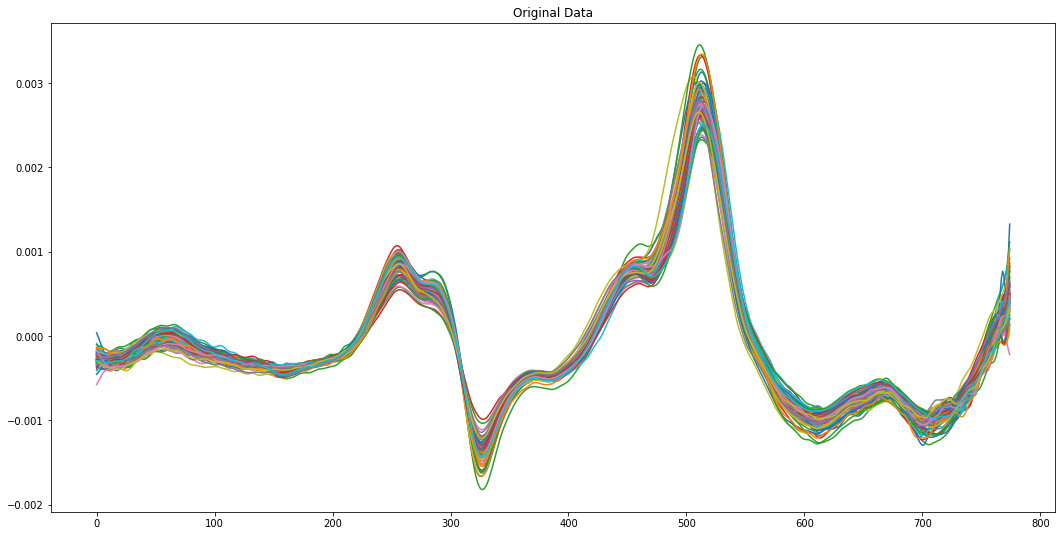

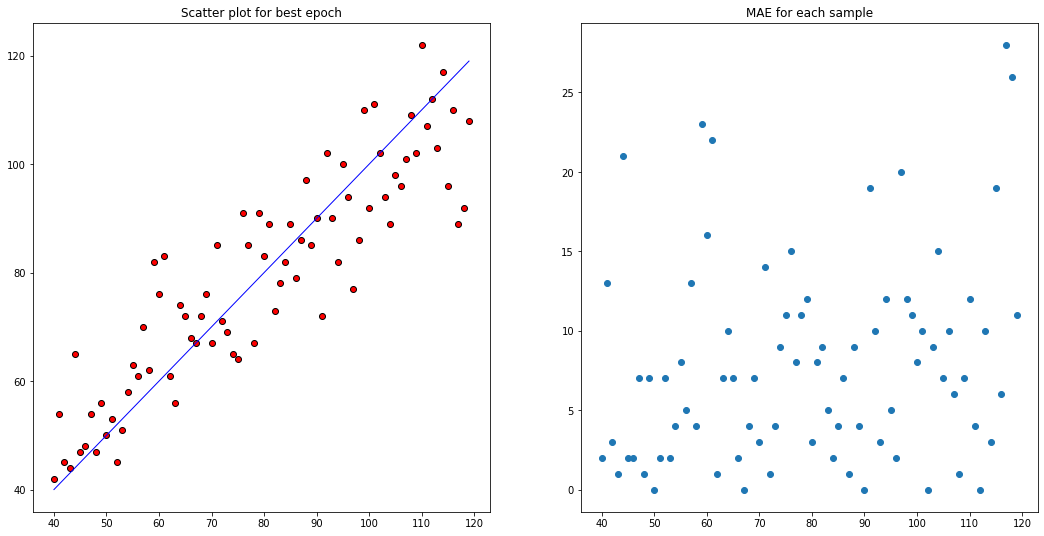

In [83]:
import numpy as np
import pandas as pd
import random
import torch
import sys
from torch import nn
from torch import optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from datetime import datetime
import matplotlib.pyplot as plt
import sklearn.metrics
#from google.colab import files
import io
from scipy import signal as sg
from scipy.signal import savgol_filter
from torch.autograd import Function
from scipy.stats import chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from scipy.ndimage import convolve1d
from scipy.signal.windows import triang
from scipy.ndimage import gaussian_filter1d
import torch.nn.functional as F
import sys

# pynvml import *

b_size = 32 #batch size
np.random.seed(100)

# the 1DCNN model on Asta for regression with added ANN layer and 0.00001 learning rate and with SNV preprocessing with Huberloss and adam optimizer with changed window length =11, polyorder = 2
class D1CNN(nn.Module):
    def __init__(self):
        super(D1CNN,self).__init__()
        self.features = nn.Sequential()
        self.features.add_module('1_conv1d',nn.Conv1d(in_channels=1,out_channels=32,kernel_size=21))
        self.features.add_module('1_relu',nn.ReLU())            
        self.features.add_module('1_batchnorm',nn.BatchNorm1d(32))
        self.features.add_module('1_maxpool',nn.MaxPool1d(kernel_size=2))
    
        self.features.add_module('2_conv1d',nn.Conv1d(in_channels=32,out_channels=64,kernel_size=21))
        self.features.add_module('2_relu',nn.ReLU())
        self.features.add_module('2_batchnorm',nn.BatchNorm1d(64))
        self.features.add_module('2_maxpool',nn.MaxPool1d(kernel_size=3))

        self.features.add_module('3_conv1d',nn.Conv1d(in_channels=64,out_channels=128,kernel_size=21))
        self.features.add_module('3_relu',nn.ReLU())
        self.features.add_module('3_batchnorm',nn.BatchNorm1d(128))
        self.features.add_module('3_maxpool',nn.MaxPool1d(kernel_size=3))

        self.features.add_module('4_conv1d',nn.Conv1d(in_channels=128,out_channels=256,kernel_size=21))
        self.features.add_module('4_relu',nn.ReLU())
        self.features.add_module('4_batchnorm',nn.BatchNorm1d(256))
        self.features.add_module('4_maxpool',nn.MaxPool1d(kernel_size=3))
        
        self.features.add_module('drop_1',nn.Dropout(p=0.4))
    
        self.regress = nn.Sequential()
        self.regress.add_module('an_1',nn.Linear(1024,512))
        self.regress.add_module('an_Relu_1',nn.ReLU())
        self.regress.add_module('an_drop_1',nn.Dropout(p=0.2))
        self.regress.add_module('an_2',nn.Linear(512,512))
        self.regress.add_module('an_Relu_2',nn.ReLU())
        self.regress.add_module('an_drop_2',nn.Dropout(p=0.2))
        self.regress.add_module('an_3',nn.Linear(512,128))
        self.regress.add_module('an_Relu_3',nn.ReLU())
        self.regress.add_module('an_drop_3',nn.Dropout(p=0.2))
        self.regress.add_module('an_4',nn.Linear(128,128))
        self.regress.add_module('an_Relu_4',nn.ReLU())
        self.regress.add_module('an_drop_4',nn.Dropout(p=0.2))
        self.regress.add_module('an_5',nn.Linear(128,64))
        self.regress.add_module('an_Relu_5',nn.ReLU())
        self.regress.add_module('an_drop_5',nn.Dropout(p=0.2))
        self.regress.add_module('an_6',nn.Linear(64,1))

    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x,start_dim=1)
        x_out = self.regress(x)
        return x_out

# preprocessing functions
def moving_smoothing(input_array, window_length):

    m_rows = len(range(window_length, input_array.shape[1] - window_length))
    m_cols = 2*window_length
    matrix = np.zeros((m_rows,m_cols),dtype=int)
    for j in range(0, len(matrix)):
        k = j+1
        matrix[j] = [x for x in range(k,k+2*window_length)]
    #Smoothing spectra using matrix operations:
    n_cols = m_rows
    newspectra = np.zeros((len(input_array),n_cols))
    for i in range(len(matrix)):
        newspectra[:,i] = np.mean(input_array[: ,matrix[i]],axis=1)
    #Add front and end tails (not smoothed):
    #new_spectra = np.asarray(newspectra)
    fronttail = newspectra[:,:1]
    endtail = newspectra[:,-1:]
    for k in range(1,window_length):
        fronttail=np.append(fronttail,newspectra[:,:1], axis=1)
        endtail = np.append(endtail,newspectra[:,-1:], axis =1)
    data = np.concatenate((fronttail, newspectra, endtail), axis=1)
    return data

def derivate_first(input_array, window_length, polyorder):
    der1 = savgol_filter(input_array, window_length, polyorder,deriv = 1)
    return der1

def MSC(input_array, reference = None):
    ''' Perform Multiplicative scatter correction'''

    #Mean correction
    for i in range(input_array.shape[0]):
        input_array[i,:] -= input_array[i,:].mean()

    # Get the reference spectrum. If not given, estimate from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_array, axis=0)
    else:
        ref = reference

    # Define a new data matrix and populate it with the corrected data    
    output_data = np.zeros_like(input_array)
    for i in range(input_array.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_array[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_array[i,:] - fit[0][1]) / fit[0][0] 
    #print(fit)
    return output_data

def detrending(input_array):
    X = np.arange(input_array.shape[1])
    base = np.zeros((len(input_array),len(X)))
    for i in range(len(input_array)):
        c = np.polyfit(X, input_array[i], 2)
        base[i] = np.polyval(c, X)
    #Baseline removal
    base_remove = input_array - base
    return base_remove

def savitzky(input_array, window_length, polyorder):
    savgol = savgol_filter(input_array, window_length, polyorder)
    return savgol

def weighted_l1_loss(inputs, targets, weights=None):
    '''You need to correct this'''
    loss = F.l1_loss(inputs, targets, reduction='none')
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

def data_1D(f):
    sed = 100
    d_asta = pd.read_csv(f,encoding='utf-8')
    d_asta = d_asta.loc[:, ~d_asta.columns.str.contains('^Unnamed')]
    #col = [str(x) for x in range(0,151)]+[str(x) for x in range(751,801)]+['Sample ID','Cap']
    #col = ['Sample ID','Cap','800']
    #d_asta = df.drop(columns=col)
    #d_asta = d_asta.dropna(subset=['ASTA'])
    #d_asta['ASTA'] = d_asta['ASTA'].round()
    #d_asta = d_asta[d_asta['ASTA']>=50]
    #d_asta = d_asta[d_asta['ASTA']<120]

    X_val = np.array(d_asta.drop(columns = ['ASTA']))
    Y_val = np.array(d_asta['ASTA'])

    X_val = savitzky(X_val,11,2)
    X_val = MSC(X_val)
    X_val = detrending(X_val)
    X_val = derivate_first(X_val,11,2)


    return X_val,Y_val

def run():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print('using'+device+'device')
    man_seed = 100
    torch.manual_seed(man_seed)
    model = D1CNN()
    model.load_state_dict(torch.load('model_asta_40_120_lds_dataaug_7_20220311_152247_568.pth',map_location = torch.device(device)))
    model.to(device)
    '''if float 64 is allowed then you can go with that too'''
    model.to(torch.float32)
    loss = weighted_l1_loss
    file_name = 'test_aug_test.csv'
    x_val,y_val = data_1D(file_name)
    fig_1 = plt.figure(figsize =(18,9))
    ax = fig_1.add_subplot(1,1,1)
    ax.plot(x_val[:,0:775].transpose())
    ax.title.set_text('Original Data')
    model.eval()
    
    with torch.no_grad():

        v_x_dt = torch.from_numpy(x_val)
        v_x_dt = torch.unsqueeze(v_x_dt,dim=1)
        #v_x_dt = torch.unsqueeze(v_x_dt,dim=0)
        
        v_x_dt = Variable(v_x_dt,requires_grad=False).to(device,dtype = torch.float32)
        print(v_x_dt.shape)
        v_y_dt = torch.from_numpy(np.array(y_val))
        v_y_dt = Variable(v_y_dt,requires_grad = False).to(device,dtype = torch.float32)
        v_yhat = model.forward(v_x_dt)
        v_yhat = torch.squeeze(v_yhat)
        v_yhat = torch.round(v_yhat)
        v_loss = loss(v_yhat,v_y_dt).item()

        b_yhat = v_yhat.to('cpu')
        b_y_t_1 = v_y_dt.to('cpu')
        r2_score = sklearn.metrics.r2_score(b_y_t_1,b_yhat)
        
    
        v_x_dt.detach()
        v_y_dt.detach()
        v_yhat.detach()
        
    print("\n the MAE is %.4f\n"%(v_loss)),#r2_score))
    print("\n the r2score is %.4f\n"%(r2_score)),#r2_score))
    
    ttt = abs(b_yhat - b_y_t_1)
    
    
    fig_4 = plt.figure(figsize =(18,9))
    ax4 = fig_4.add_subplot(1,2,1)
    ax5 = fig_4.add_subplot(1,2,2)
    ax4.title.set_text('Scatter plot for best epoch')
    ax5.title.set_text('MAE for each sample')
    ax5.plot(b_y_t_1,ttt,marker ='o',linestyle='')
    ax4.scatter(b_y_t_1,b_yhat,c='red',edgecolors='k')
    ax4.plot(b_y_t_1,b_y_t_1,c='blue',linewidth = 1)
    fig_4.show()
    
if __name__ == '__main__':
    run()

#### For r2 score of 0.806, checking spectra variation for values 53,63,69,83,70,91 on training dataset

usingcpudevice
torch.Size([3, 1, 800])

 the MAE is 9.3333


 the r2score is 0.0000



C:\Users\Admin\AppData\Local\Temp/ipykernel_18160/2850126609.py:247: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_4.show()


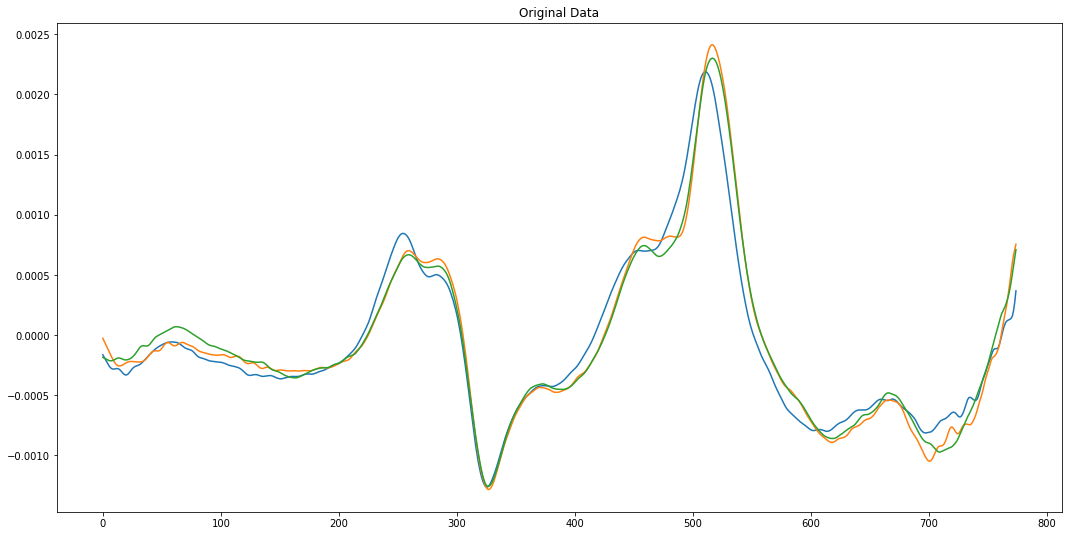

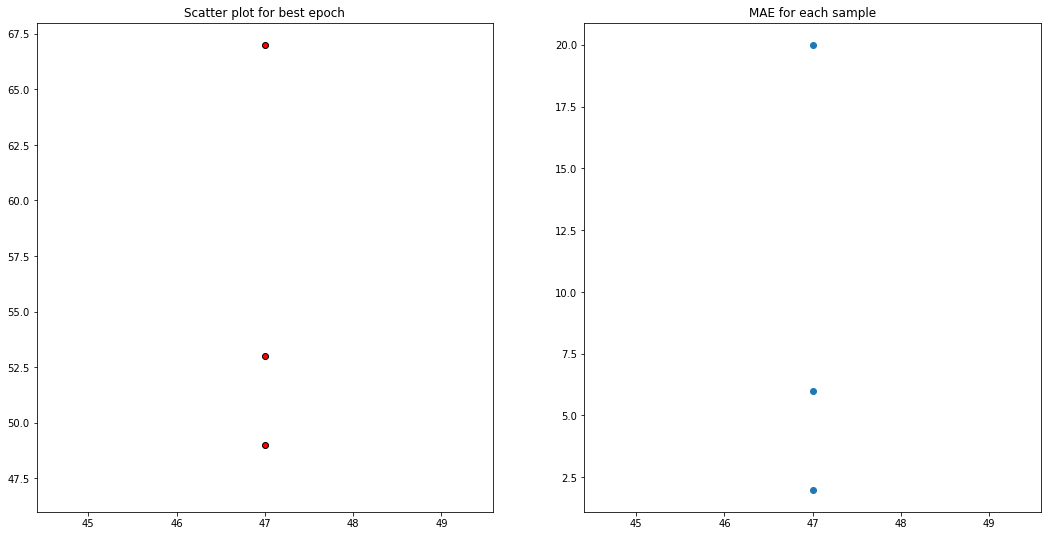

In [13]:
import numpy as np
import pandas as pd
import random
import torch
import sys
from torch import nn
from torch import optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from datetime import datetime
import matplotlib.pyplot as plt
import sklearn.metrics
#from google.colab import files
import io
from scipy import signal as sg
from scipy.signal import savgol_filter
from torch.autograd import Function
from scipy.stats import chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from scipy.ndimage import convolve1d
from scipy.signal.windows import triang
from scipy.ndimage import gaussian_filter1d
import torch.nn.functional as F
import sys

# pynvml import *

b_size = 32 #batch size
np.random.seed(100)

# the 1DCNN model on Asta for regression with added ANN layer and 0.00001 learning rate and with SNV preprocessing with Huberloss and adam optimizer with changed window length =11, polyorder = 2
class D1CNN(nn.Module):
    def __init__(self):
        super(D1CNN,self).__init__()
        self.features = nn.Sequential()
        self.features.add_module('1_conv1d',nn.Conv1d(in_channels=1,out_channels=32,kernel_size=21))
        self.features.add_module('1_relu',nn.ReLU())            
        self.features.add_module('1_batchnorm',nn.BatchNorm1d(32))
        self.features.add_module('1_maxpool',nn.MaxPool1d(kernel_size=2))
    
        self.features.add_module('2_conv1d',nn.Conv1d(in_channels=32,out_channels=64,kernel_size=21))
        self.features.add_module('2_relu',nn.ReLU())
        self.features.add_module('2_batchnorm',nn.BatchNorm1d(64))
        self.features.add_module('2_maxpool',nn.MaxPool1d(kernel_size=3))

        self.features.add_module('3_conv1d',nn.Conv1d(in_channels=64,out_channels=128,kernel_size=21))
        self.features.add_module('3_relu',nn.ReLU())
        self.features.add_module('3_batchnorm',nn.BatchNorm1d(128))
        self.features.add_module('3_maxpool',nn.MaxPool1d(kernel_size=3))

        self.features.add_module('4_conv1d',nn.Conv1d(in_channels=128,out_channels=256,kernel_size=21))
        self.features.add_module('4_relu',nn.ReLU())
        self.features.add_module('4_batchnorm',nn.BatchNorm1d(256))
        self.features.add_module('4_maxpool',nn.MaxPool1d(kernel_size=3))
        
        self.features.add_module('drop_1',nn.Dropout(p=0.4))
    
        self.regress = nn.Sequential()
        self.regress.add_module('an_1',nn.Linear(1024,512))
        self.regress.add_module('an_Relu_1',nn.ReLU())
        self.regress.add_module('an_drop_1',nn.Dropout(p=0.2))
        self.regress.add_module('an_2',nn.Linear(512,512))
        self.regress.add_module('an_Relu_2',nn.ReLU())
        self.regress.add_module('an_drop_2',nn.Dropout(p=0.2))
        self.regress.add_module('an_3',nn.Linear(512,128))
        self.regress.add_module('an_Relu_3',nn.ReLU())
        self.regress.add_module('an_drop_3',nn.Dropout(p=0.2))
        self.regress.add_module('an_4',nn.Linear(128,128))
        self.regress.add_module('an_Relu_4',nn.ReLU())
        self.regress.add_module('an_drop_4',nn.Dropout(p=0.2))
        self.regress.add_module('an_5',nn.Linear(128,64))
        self.regress.add_module('an_Relu_5',nn.ReLU())
        self.regress.add_module('an_drop_5',nn.Dropout(p=0.2))
        self.regress.add_module('an_6',nn.Linear(64,1))

    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x,start_dim=1)
        x_out = self.regress(x)
        return x_out

# preprocessing functions
def moving_smoothing(input_array, window_length):

    m_rows = len(range(window_length, input_array.shape[1] - window_length))
    m_cols = 2*window_length
    matrix = np.zeros((m_rows,m_cols),dtype=int)
    for j in range(0, len(matrix)):
        k = j+1
        matrix[j] = [x for x in range(k,k+2*window_length)]
    #Smoothing spectra using matrix operations:
    n_cols = m_rows
    newspectra = np.zeros((len(input_array),n_cols))
    for i in range(len(matrix)):
        newspectra[:,i] = np.mean(input_array[: ,matrix[i]],axis=1)
    #Add front and end tails (not smoothed):
    #new_spectra = np.asarray(newspectra)
    fronttail = newspectra[:,:1]
    endtail = newspectra[:,-1:]
    for k in range(1,window_length):
        fronttail=np.append(fronttail,newspectra[:,:1], axis=1)
        endtail = np.append(endtail,newspectra[:,-1:], axis =1)
    data = np.concatenate((fronttail, newspectra, endtail), axis=1)
    return data

def derivate_first(input_array, window_length, polyorder):
    der1 = savgol_filter(input_array, window_length, polyorder,deriv = 1)
    return der1

def MSC(input_array, reference = None):
    ''' Perform Multiplicative scatter correction'''

    #Mean correction
    for i in range(input_array.shape[0]):
        input_array[i,:] -= input_array[i,:].mean()

    # Get the reference spectrum. If not given, estimate from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_array, axis=0)
    else:
        ref = reference

    # Define a new data matrix and populate it with the corrected data    
    output_data = np.zeros_like(input_array)
    for i in range(input_array.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_array[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_array[i,:] - fit[0][1]) / fit[0][0] 
    #print(fit)
    return output_data

def detrending(input_array):
    X = np.arange(input_array.shape[1])
    base = np.zeros((len(input_array),len(X)))
    for i in range(len(input_array)):
        c = np.polyfit(X, input_array[i], 2)
        base[i] = np.polyval(c, X)
    #Baseline removal
    base_remove = input_array - base
    return base_remove

def savitzky(input_array, window_length, polyorder):
    savgol = savgol_filter(input_array, window_length, polyorder)
    return savgol

def weighted_l1_loss(inputs, targets, weights=None):
    '''You need to correct this'''
    loss = F.l1_loss(inputs, targets, reduction='none')
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

def data_1D(f,gg):
    sed = 100
    d_asta = pd.read_csv(f,encoding='utf-8')
    d_asta = d_asta.loc[:, ~d_asta.columns.str.contains('^Unnamed')]
    #col = [str(x) for x in range(0,151)]+[str(x) for x in range(751,801)]+['Sample ID','Cap']
    #col = ['Sample ID','Cap','800']
    #d_asta = df.drop(columns=col)
    #d_asta = d_asta.dropna(subset=['ASTA'])
    #d_asta['ASTA'] = d_asta['ASTA'].round()
    #d_asta = d_asta[d_asta['ASTA']>=50]
    #d_asta = d_asta[d_asta['ASTA']<120]
    
    d_asta = d_asta.query('ASTA =='+str(gg))

    X_val = np.array(d_asta.drop(columns = ['ASTA']))
    Y_val = np.array(d_asta['ASTA'])

    X_val = savitzky(X_val,11,2)
    X_val = MSC(X_val)
    X_val = detrending(X_val)
    X_val = derivate_first(X_val,11,2)


    return X_val,Y_val

def run(gg):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print('using'+device+'device')
    man_seed = 100
    torch.manual_seed(man_seed)
    model = D1CNN()
    model.load_state_dict(torch.load('model_asta_40_120_lds_dataaug_7_20220311_152247_568.pth',map_location = torch.device(device)))
    model.to(device)
    '''if float 64 is allowed then you can go with that too'''
    model.to(torch.float32)
    loss = weighted_l1_loss
    file_name = 'train_aug_test.csv'
    x_val,y_val = data_1D(file_name,gg)
    fig_1 = plt.figure(figsize =(18,9))
    ax = fig_1.add_subplot(1,1,1)
    ax.plot(x_val[:,0:775].transpose())
    ax.title.set_text('Original Data')
    model.eval()
    
    with torch.no_grad():

        v_x_dt = torch.from_numpy(x_val)
        v_x_dt = torch.unsqueeze(v_x_dt,dim=1)
        #v_x_dt = torch.unsqueeze(v_x_dt,dim=0)
        
        v_x_dt = Variable(v_x_dt,requires_grad=False).to(device,dtype = torch.float32)
        print(v_x_dt.shape)
        v_y_dt = torch.from_numpy(np.array(y_val))
        v_y_dt = Variable(v_y_dt,requires_grad = False).to(device,dtype = torch.float32)
        v_yhat = model.forward(v_x_dt)
        v_yhat = torch.squeeze(v_yhat)
        v_yhat = torch.round(v_yhat)
        v_loss = loss(v_yhat,v_y_dt).item()

        b_yhat = v_yhat.to('cpu')
        b_y_t_1 = v_y_dt.to('cpu')
        r2_score = sklearn.metrics.r2_score(b_y_t_1,b_yhat)
        
    
        v_x_dt.detach()
        v_y_dt.detach()
        v_yhat.detach()
        
    print("\n the MAE is %.4f\n"%(v_loss)),#r2_score))
    print("\n the r2score is %.4f\n"%(r2_score)),#r2_score))
    
    ttt = abs(b_yhat - b_y_t_1)
    
    #d_asta = pd.read_csv(file_name,encoding='utf-8')
    #d_asta = d_asta.loc[:, ~d_asta.columns.str.contains('^Unnamed')]
    #d_asta['actual'] = b_y_t_1
    #d_asta['pred'] = b_yhat
    #d_asta['AE'] = ttt
    #d_asta.to_csv('train_aug_test_asta.csv')
    
    fig_4 = plt.figure(figsize =(18,9))
    ax4 = fig_4.add_subplot(1,2,1)
    ax5 = fig_4.add_subplot(1,2,2)
    ax4.title.set_text('Scatter plot for best epoch')
    ax5.title.set_text('MAE for each sample')
    ax5.plot(b_y_t_1,ttt,marker ='o',linestyle='')
    ax4.scatter(b_y_t_1,b_yhat,c='red',edgecolors='k')
    ax4.plot(b_y_t_1,b_y_t_1,c='blue',linewidth = 1)
    fig_4.show()
    
if __name__ == '__main__':
    run(47)